In [1]:
# Importing packages
import requests  
import pandas as pd
import sklearn
import nltk
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import svm
import time

In [2]:
#Import the data frame
mtg = pd.read_csv("MTG_Cards")
mtg = mtg.drop(columns = "Unnamed: 0")
mtg

Name                                               Text  \
0                +2 Mace  Equipped creature gets +2/+2 Equip {3} {3}: At...   
1        Abbey Gargoyles                         Flying protection from red   
2          Abbey Griffin                                   Flying vigilance   
3           Abbey Matron  {W} {T}: Abbey Matron gets +0/+3 until end of ...   
4               Abeyance  Until end of turn target player can t cast ins...   
...                  ...                                                ...   
12039      Wolf's Quarry  Create three 1/1 green Boar creature tokens wi...   
12040        Wolf Strike  Target creature you control gets +2/+0 until e...   
12041     Wolverine Pack  Rampage 2 Whenever this creature becomes block...   
12042   Wolverine Riders  At the beginning of each upkeep create a 1/1 g...   
12043  Woodborn Behemoth  As long as you control eight or more lands Woo...   

                                                  Flavor  Color          Cost  \
0      The weight of this magic weapon falls heavy on...  White        {1}{W}   
1      Though Serra has not been seen for twenty year...  White  {2}{W}{W}{W}   
2      The darkness crawls with vampires and ghouls b...  White        {3}{W}   
3      The Matrons are kindly souls but don t ask one...  White        {2}{W}   
4      I m too modest a wizard to reveal the full ext...  White        {1}{W}   
...                                                  ...    ...           ...   
12039  The monster was gaining on them Twice it had f...  Green     {4}{G}{G}   
12040  Tovolar s howlpack had scattered but the Dire ...  Green        {2}{G}   
12041  Give them great meals of beef and iron and ste...  Green     {2}{G}{G}   
12042     We ll break their lines The rest of you follow  Green     {4}{G}{G}   
12043  It carries the hopes of Zendikar s embattled w...  Green     {3}{G}{G}   

                          Type    Rarity  
0         Artifact — Equipment    common  
1          Creature — Gargoyle  uncommon  
2           Creature — Griffin    common  
3      Creature — Human Cleric    common  
4                      Instant      rare  
...                        ...       ...  
12039                  Sorcery    common  
12040                  Instant    common  
12041     Creature — Wolverine  uncommon  
12042   Creature — Elf Warrior      rare  
12043     Creature — Elemental  uncommon  

[12044 rows x 7 columns]

In [3]:
## Preparing Data for Vectorization ##

In [4]:
#Initializing empty lists to hold the card texts and colors
TextList = []
ColorList = []

In [5]:
#Filling the lists with the elements from the data frame
for text, color in zip(mtg["Text"], mtg["Color"]):
    TextList.append(text)
    ColorList.append(color)

In [6]:
print(TextList[:5])

['Equipped creature gets +2/+2 Equip {3} {3}: Attach to target creature you control Equip only as a sorcery', 'Flying protection from red', 'Flying vigilance', '{W} {T}: Abbey Matron gets +0/+3 until end of turn', 'Until end of turn target player can t cast instant or sorcery spells and that player can t activate abilities that aren t mana abilities Draw a card']


In [7]:
#Cleaning the text
CleanTextList = []

for text in TextList:

    text=re.sub(r'[,:.\+;@#?!&$\-\\{\}\\\/\']+', ' ', text, flags=re.IGNORECASE)
    text=re.sub(' +', ' ', text, flags=re.IGNORECASE)
    text=re.sub(r'\"', ' ', text, flags=re.IGNORECASE)
    text=re.sub(r'[^a-zA-Z]', " ", text, flags=re.VERBOSE)
    text=text.replace(',', '')
    text=' '.join(text.split())
    text=re.sub("\n|\r", "", text) 
    text = ' '.join([wd for wd in text.split() if len(wd)>2])
    
    CleanTextList.append(text)

In [8]:
print(CleanTextList[:5])

['Equipped creature gets Equip Attach target creature you control Equip only sorcery', 'Flying protection from red', 'Flying vigilance', 'Abbey Matron gets until end turn', 'Until end turn target player can cast instant sorcery spells and that player can activate abilities that aren mana abilities Draw card']


In [9]:
mtgColors = ["red", "black", "blue", "green", "white"]

In [10]:
#Initializing another list
CleanTextListNoColors = []

In [11]:
#Removing any words that match the target variables to avoid confusion or overfitting
for text in CleanTextList:
    AllWords = text.split(" ")
    NewWordsList = []
    for word in AllWords:
        word = word.lower()
        if word not in mtgColors:
            NewWordsList.append(word)
    NewWords = " ".join(NewWordsList)
    CleanTextListNoColors.append(NewWords)

In [12]:
print(CleanTextListNoColors[:5])

['equipped creature gets equip attach target creature you control equip only sorcery', 'flying protection from', 'flying vigilance', 'abbey matron gets until end turn', 'until end turn target player can cast instant sorcery spells and that player can activate abilities that aren mana abilities draw card']


In [13]:
## Creating Vectorizers REGULAR STOP WORDS ##

In [14]:
#Defining lemmatization function
def MY_LEMMER(str_input):   
    #Using a regular expression to match any character that is not a letter or dash and replacing it with a space
    # to tokenize the text. Then making all the tokens lower space, and splitting them into separate elements in a list
    words = re.sub(r"[^A-Za-z\-]", " ", str_input).lower().split()
    #Using the WordNetLemmatizer to lemmatize all the words in the list
    words = [WordNetLemmatizer().lemmatize(w) for w in words]
    return words

In [15]:
# Creating instances of Count Vectorizer

#CountVectorizers for MultinomialNB
CV250 = CountVectorizer(input = "content", stop_words = "english", tokenizer = MY_LEMMER, max_features = 250)
CV350 = CountVectorizer(input = "content", stop_words = "english", tokenizer = MY_LEMMER, max_features = 350)

#CountVectorizers for BernoulliNB
CV250b = CountVectorizer(input = "content", stop_words = "english", 
                         tokenizer = MY_LEMMER, binary = True, max_features = 250)
CV350b = CountVectorizer(input = "content", stop_words = "english", 
                         tokenizer = MY_LEMMER, binary = True, max_features = 350)

#TfidfVectorizers for MultinomialNB
TF250 = TfidfVectorizer(input = "content", stop_words = "english", tokenizer = MY_LEMMER, max_features = 250)
TF350 = TfidfVectorizer(input = "content", stop_words = "english", tokenizer = MY_LEMMER, max_features = 350)

In [16]:
## MultinomialNB with CountVectorizers ##

In [17]:
## Count Vectorizer 250 to Train and Test ##

In [18]:
CVs_250 = CV250.fit_transform(CleanTextListNoColors)
colnames_CV250 = CV250.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [19]:
CV250_DF = pd.DataFrame(CVs_250.toarray(), columns = colnames_CV250)

In [20]:
CV250_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vigilance  wa  wall  warrior  way  win  wizard  wolf  \
0         0      0  ...          0   0     0        0    0    0       0     0   
1         0      0  ...          0   0     0        0    0    0       0     0   
2         0      0  ...          1   0     0        0    0    0       0     0   
3         0      0  ...          0   0     0        0    0    0       0     0   
4         0      0  ...          0   0     0        0    0    0       0     0   
...     ...    ...  ...        ...  ..   ...      ...  ...  ...     ...   ...   
12039     0      0  ...          0   0     0        0    0    0       0     0   
12040     0      0  ...          0   0     0        0    0    0       0     0   
12041     0      0  ...          0   0     0        0    0    0       0     0   
12042     0      0  ...          0   0     0        1    0    0       0     0   
12043     0      0  ...          0   0     0        0    0    0       0     0   

       word  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 250 columns]

In [21]:
#Get rid of column names with less than 3 characters
for nextcol in CV250_DF.columns:
    if (len(str(nextcol))<3):
        CV250_DF = CV250_DF.drop([nextcol], axis = 1)

In [22]:
CV250_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vehicle  vigilance  wall  warrior  way  win  wizard  \
0         0      0  ...        0          0     0        0    0    0       0   
1         0      0  ...        0          0     0        0    0    0       0   
2         0      0  ...        0          1     0        0    0    0       0   
3         0      0  ...        0          0     0        0    0    0       0   
4         0      0  ...        0          0     0        0    0    0       0   
...     ...    ...  ...      ...        ...   ...      ...  ...  ...     ...   
12039     0      0  ...        0          0     0        0    0    0       0   
12040     0      0  ...        0          0     0        0    0    0       0   
12041     0      0  ...        0          0     0        0    0    0       0   
12042     0      0  ...        0          0     0        1    0    0       0   
12043     0      0  ...        0          0     0        0    0    0       0   

       wolf  word  zombie  
0         0     0       0  
1         0     0       0  
2         0     0       0  
3         0     0       0  
4         0     0       0  
...     ...   ...     ...  
12039     0     0       0  
12040     0     0       0  
12041     0     0       0  
12042     0     0       0  
12043     0     0       0  

[12044 rows x 246 columns]

In [23]:
#Inserting the color labels into the dataframe
CV250_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [24]:
CV250_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vehicle  vigilance  wall  warrior  way  win  wizard  \
0        0     0  ...        0          0     0        0    0    0       0   
1        0     0  ...        0          0     0        0    0    0       0   
2        0     0  ...        0          1     0        0    0    0       0   
3        0     0  ...        0          0     0        0    0    0       0   
4        0     0  ...        0          0     0        0    0    0       0   
...    ...   ...  ...      ...        ...   ...      ...  ...  ...     ...   
12039    0     0  ...        0          0     0        0    0    0       0   
12040    0     0  ...        0          0     0        0    0    0       0   
12041    0     0  ...        0          0     0        0    0    0       0   
12042    0     0  ...        0          0     0        1    0    0       0   
12043    0     0  ...        0          0     0        0    0    0       0   

       wolf  word  zombie  
0         0     0       0  
1         0     0       0  
2         0     0       0  
3         0     0       0  
4         0     0       0  
...     ...   ...     ...  
12039     0     0       0  
12040     0     0       0  
12041     0     0       0  
12042     0     0       0  
12043     0     0       0  

[12044 rows x 247 columns]

In [25]:
#Removing any rows where the row sum is 0
CV250_DF = CV250_DF.loc[(CV250_DF.sum(axis=1, numeric_only = True) != 0)]

In [26]:
CV250_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vehicle  vigilance  wall  warrior  way  win  wizard  \
0        0     0  ...        0          0     0        0    0    0       0   
1        0     0  ...        0          0     0        0    0    0       0   
2        0     0  ...        0          1     0        0    0    0       0   
3        0     0  ...        0          0     0        0    0    0       0   
4        0     0  ...        0          0     0        0    0    0       0   
...    ...   ...  ...      ...        ...   ...      ...  ...  ...     ...   
12039    0     0  ...        0          0     0        0    0    0       0   
12040    0     0  ...        0          0     0        0    0    0       0   
12041    0     0  ...        0          0     0        0    0    0       0   
12042    0     0  ...        0          0     0        1    0    0       0   
12043    0     0  ...        0          0     0        0    0    0       0   

       wolf  word  zombie  
0         0     0       0  
1         0     0       0  
2         0     0       0  
3         0     0       0  
4         0     0       0  
...     ...   ...     ...  
12039     0     0       0  
12040     0     0       0  
12041     0     0       0  
12042     0     0       0  
12043     0     0       0  

[12043 rows x 247 columns]

In [27]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV250 , test_X_CV250, label_train_CV250, label_test_CV250 = train_test_split(CV250_DF.iloc[:, 1:], 
                                                                                 CV250_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV250_DF.iloc[:, 0])

In [28]:
#Create the MNB
nb_CV250 = MultinomialNB()

In [29]:
#Training the MNB
nb_CV250.fit(train_X_CV250, label_train_CV250)

MultinomialNB()

In [30]:
#Checking the balance of the labels present in the training data
unique, counts = np.unique(label_train_CV250, return_counts=True)
print(np.asarray((unique, counts)))

[['Black' 'Blue' 'Green' 'Red' 'White']
 [1926 1883 1894 1939 1992]]


In [31]:
## Most Informative Features for Naive Bayes based on CountVectorizer data ##

In [32]:
#Get the 20 most informative features for the cards
OrderedColors = ["Black", "Blue", "Green", "Red", "White"]

for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(nb_CV250.feature_log_prob_[i], train_X_CV250.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-4.300649895373871, 'flying'), (-4.291517411810598, 'damage'), (-4.171716211997977, 'discard'), (-4.159692019031176, 'destroy'), (-4.143881413004534, 'hand'), (-4.120624550840266, 'enters'), (-4.09789629976271, 'counter'), (-4.079342891866962, 'gain'), (-3.923093575382783, 'opponent'), (-3.8329424783884853, 'graveyard'), (-3.8329424783884853, 'sacrifice'), (-3.708794048865026, 'battlefield'), (-3.706259193261838, 'end'), (-3.6738777837587984, 'control'), (-3.498936334262466, 'player'), (-3.4448691129921905, 'turn'), (-3.3186745104315216, 'life'), (-2.9649248030276647, 'target'), (-2.7654611083155487, 'card'), (-2.2035892562534434, 'creature')]


The 20 most informative features for the Blue cards are:
[(-4.329988276300543, 'artifact'), (-4.292947004620193, 'library'), (-4.270474148768135, 'permanent'), (-4.157145463461132, 'end'), (-4.137498466077335, 'return'), (-4.118230047211458, 'enters'), (-4.066173685255405, 'owner'), (-

In [33]:
#Test the model against the testing data
nb_CV250.score(test_X_CV250, label_test_CV250)

0.5554171855541719

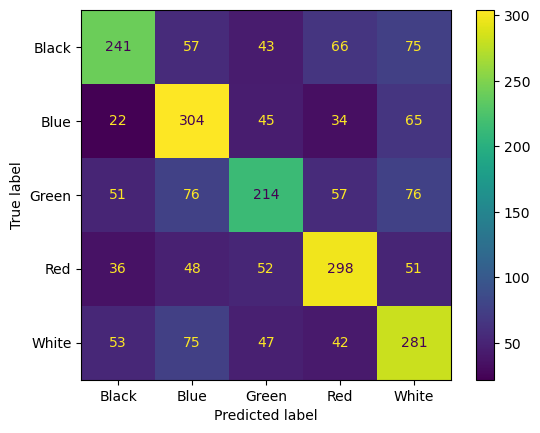

In [34]:
#Create confusion matrix of results
y_pred_CV250 = nb_CV250.predict(test_X_CV250)
cm_CV250=confusion_matrix(label_test_CV250, y_pred_CV250, labels=nb_CV250.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV250,
                              display_labels=nb_CV250.classes_)
disp.plot()
plt.show()

In [35]:
## Count Vectorizer 350 to Train and Test ##

In [36]:
CVs_350 = CV350.fit_transform(CleanTextListNoColors)
colnames_CV350 = CV350.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [37]:
CV350_DF = pd.DataFrame(CVs_350.toarray(), columns = colnames_CV350)

In [38]:
CV350_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0         0      0  ...    0         0    0       0     0    0     0     0   
1         0      0  ...    0         0    0       0     0    0     0     0   
2         0      0  ...    0         0    0       0     0    0     0     0   
3         0      0  ...    0         0    0       0     0    0     0     0   
4         0      0  ...    0         0    0       0     0    0     0     0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039     0      0  ...    0         0    0       0     0    0     0     0   
12040     0      0  ...    0         0    0       0     0    0     0     0   
12041     0      0  ...    0         0    0       0     0    0     0     0   
12042     0      0  ...    0         0    0       0     0    0     0     0   
12043     0      0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12044 rows x 350 columns]

In [39]:
#Get rid of column names with less than 3 characters
for nextcol in CV350_DF.columns:
    if (len(str(nextcol))<3):
        CV350_DF = CV350_DF.drop([nextcol], axis = 1)

In [40]:
CV350_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0         0      0  ...    0         0    0       0     0    0     0     0   
1         0      0  ...    0         0    0       0     0    0     0     0   
2         0      0  ...    0         0    0       0     0    0     0     0   
3         0      0  ...    0         0    0       0     0    0     0     0   
4         0      0  ...    0         0    0       0     0    0     0     0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039     0      0  ...    0         0    0       0     0    0     0     0   
12040     0      0  ...    0         0    0       0     0    0     0     0   
12041     0      0  ...    0         0    0       0     0    0     0     0   
12042     0      0  ...    0         0    0       0     0    0     0     0   
12043     0      0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12044 rows x 346 columns]

In [41]:
#Inserting the color labels into the dataframe
CV350_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [42]:
CV350_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0        0     0  ...    0         0    0       0     0    0     0     0   
1        0     0  ...    0         0    0       0     0    0     0     0   
2        0     0  ...    0         0    0       0     0    0     0     0   
3        0     0  ...    0         0    0       0     0    0     0     0   
4        0     0  ...    0         0    0       0     0    0     0     0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039    0     0  ...    0         0    0       0     0    0     0     0   
12040    0     0  ...    0         0    0       0     0    0     0     0   
12041    0     0  ...    0         0    0       0     0    0     0     0   
12042    0     0  ...    0         0    0       0     0    0     0     0   
12043    0     0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12044 rows x 347 columns]

In [43]:
#Removing any rows where the row sum is 0
CV350_DF = CV350_DF.loc[(CV350_DF.sum(axis=1, numeric_only = True) != 0)]

In [44]:
CV350_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0        0     0  ...    0         0    0       0     0    0     0     0   
1        0     0  ...    0         0    0       0     0    0     0     0   
2        0     0  ...    0         0    0       0     0    0     0     0   
3        0     0  ...    0         0    0       0     0    0     0     0   
4        0     0  ...    0         0    0       0     0    0     0     0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039    0     0  ...    0         0    0       0     0    0     0     0   
12040    0     0  ...    0         0    0       0     0    0     0     0   
12041    0     0  ...    0         0    0       0     0    0     0     0   
12042    0     0  ...    0         0    0       0     0    0     0     0   
12043    0     0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12043 rows x 347 columns]

In [45]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350 , test_X_CV350, label_train_CV350, label_test_CV350 = train_test_split(CV350_DF.iloc[:, 1:], 
                                                                                 CV350_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV350_DF.iloc[:, 0])

In [46]:
#Create the MNB
nb_CV350 = MultinomialNB()

In [47]:
#Training the MNB
nb_CV350.fit(train_X_CV350, label_train_CV350)

MultinomialNB()

In [48]:
#Test the model against the testing data
nb_CV350.score(test_X_CV350, label_test_CV350)

0.5574927355749274

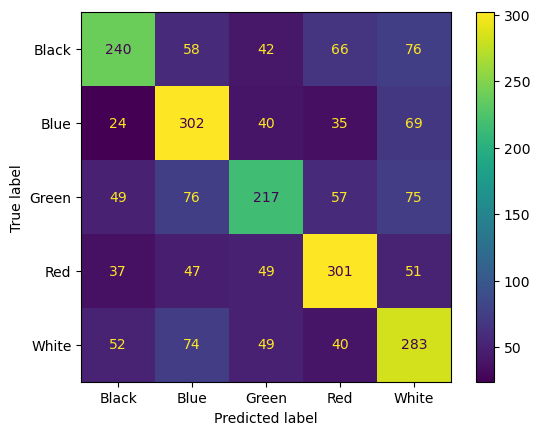

In [49]:
#Create confusion matrix of results
y_pred_CV350 = nb_CV350.predict(test_X_CV350)
cm_CV350=confusion_matrix(label_test_CV350, y_pred_CV350, labels=nb_CV350.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV350,
                              display_labels=nb_CV350.classes_)
disp.plot()
plt.show()

In [50]:
## BernoulliNB with Binary CountVectorizers ##

In [51]:
## Binary Count Vectorizer 250 to Train and Test ##

In [52]:
CVs_250b = CV250b.fit_transform(CleanTextListNoColors)
colnames_CV250b = CV250b.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [53]:
CV250b_DF = pd.DataFrame(CVs_250b.toarray(), columns = colnames_CV250b)

In [54]:
CV250b_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vehicle  vigilance  wa  wall  warrior  way  win  \
0         0      0  ...        0          0   0     0        0    0    0   
1         0      0  ...        0          0   0     0        0    0    0   
2         0      0  ...        0          1   0     0        0    0    0   
3         0      0  ...        0          0   0     0        0    0    0   
4         0      0  ...        0          0   0     0        0    0    0   
...     ...    ...  ...      ...        ...  ..   ...      ...  ...  ...   
12039     0      0  ...        0          0   0     0        0    0    0   
12040     0      0  ...        0          0   0     0        0    0    0   
12041     0      0  ...        0          0   0     0        0    0    0   
12042     0      0  ...        0          0   0     0        1    0    0   
12043     0      0  ...        0          0   0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12044 rows x 250 columns]

In [55]:
#Get rid of column names with less than 3 characters
for nextcol in CV250b_DF.columns:
    if (len(str(nextcol))<3):
        CV250b_DF = CV250b_DF.drop([nextcol], axis = 1)

In [56]:
CV250b_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vampire  vehicle  vigilance  wall  warrior  way  win  \
0         0      0  ...        0        0          0     0        0    0    0   
1         0      0  ...        0        0          0     0        0    0    0   
2         0      0  ...        0        0          1     0        0    0    0   
3         0      0  ...        0        0          0     0        0    0    0   
4         0      0  ...        0        0          0     0        0    0    0   
...     ...    ...  ...      ...      ...        ...   ...      ...  ...  ...   
12039     0      0  ...        0        0          0     0        0    0    0   
12040     0      0  ...        0        0          0     0        0    0    0   
12041     0      0  ...        0        0          0     0        0    0    0   
12042     0      0  ...        0        0          0     0        1    0    0   
12043     0      0  ...        0        0          0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12044 rows x 246 columns]

In [57]:
#Inserting the color labels into the dataframe
CV250b_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [58]:
CV250b_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vampire  vehicle  vigilance  wall  warrior  way  win  \
0        0     0  ...        0        0          0     0        0    0    0   
1        0     0  ...        0        0          0     0        0    0    0   
2        0     0  ...        0        0          1     0        0    0    0   
3        0     0  ...        0        0          0     0        0    0    0   
4        0     0  ...        0        0          0     0        0    0    0   
...    ...   ...  ...      ...      ...        ...   ...      ...  ...  ...   
12039    0     0  ...        0        0          0     0        0    0    0   
12040    0     0  ...        0        0          0     0        0    0    0   
12041    0     0  ...        0        0          0     0        0    0    0   
12042    0     0  ...        0        0          0     0        1    0    0   
12043    0     0  ...        0        0          0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12044 rows x 247 columns]

In [59]:
#Removing any rows where the row sum is 0
CV250b_DF = CV250b_DF.loc[(CV250b_DF.sum(axis=1, numeric_only = True) != 0)]

In [60]:
CV250b_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vampire  vehicle  vigilance  wall  warrior  way  win  \
0        0     0  ...        0        0          0     0        0    0    0   
1        0     0  ...        0        0          0     0        0    0    0   
2        0     0  ...        0        0          1     0        0    0    0   
3        0     0  ...        0        0          0     0        0    0    0   
4        0     0  ...        0        0          0     0        0    0    0   
...    ...   ...  ...      ...      ...        ...   ...      ...  ...  ...   
12039    0     0  ...        0        0          0     0        0    0    0   
12040    0     0  ...        0        0          0     0        0    0    0   
12041    0     0  ...        0        0          0     0        0    0    0   
12042    0     0  ...        0        0          0     0        1    0    0   
12043    0     0  ...        0        0          0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12043 rows x 247 columns]

In [61]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV250b, test_X_CV250b, label_train_CV250b, label_test_CV250b = train_test_split(CV250b_DF.iloc[:, 1:], 
                                                                                 CV250b_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV250b_DF.iloc[:, 0])

In [62]:
#Create the BernoulliNB
bern_CV250 = BernoulliNB()

In [63]:
#Training the BernoulliNB
bern_CV250.fit(train_X_CV250b, label_train_CV250b)

BernoulliNB()

In [64]:
## Most Informative Features for Bernoulli Naive Bayes based on CountVectorizer data ##

In [65]:
for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(bern_CV250.feature_log_prob_[i], train_X_CV250b.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-2.255970777769286, 'damage'), (-2.226700395469173, 'flying'), (-2.1936004470428285, 'counter'), (-2.1437034758982048, 'discard'), (-2.130516471616251, 'hand'), (-2.091967801499016, 'destroy'), (-2.0074104134709536, 'enters'), (-1.9807421663887919, 'gain'), (-1.8806587078318096, 'opponent'), (-1.783494959378162, 'sacrifice'), (-1.7773410938037832, 'graveyard'), (-1.6725942633447195, 'control'), (-1.661605141769125, 'player'), (-1.6399826777559587, 'battlefield'), (-1.63199328772248, 'end'), (-1.4373692910563056, 'turn'), (-1.4243539229442357, 'life'), (-0.986377117449444, 'card'), (-0.9087981248028436, 'target'), (-0.4833705784797093, 'creature')]


The 20 most informative features for the Blue cards are:
[(-2.388391505384332, 'discard'), (-2.3655333673082826, 'library'), (-2.2894096718354815, 'permanent'), (-2.040424889337384, 'end'), (-2.028254353717129, 'return'), (-1.988723514960494, 'enters'), (-1.9506961193712549, 'owner

In [66]:
#Test the model against the testing data
bern_CV250.score(test_X_CV250b, label_test_CV250b)

0.552096305520963

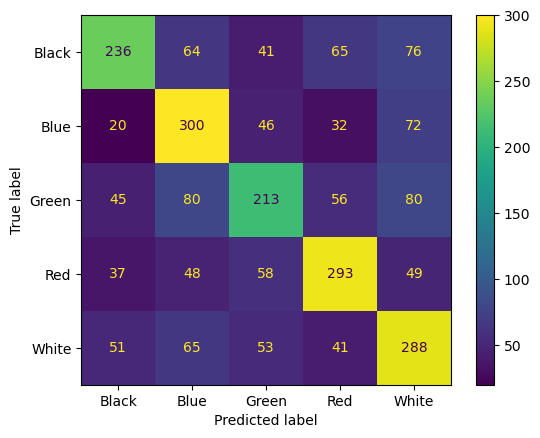

In [67]:
#Create confusion matrix of results
y_pred_CV250b = bern_CV250.predict(test_X_CV250b)
cm_CV250b=confusion_matrix(label_test_CV250b, y_pred_CV250b, labels=bern_CV250.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV250b,
                              display_labels=bern_CV250.classes_)
disp.plot()
plt.show()

In [68]:
## Binary Count Vectorizer 350 to Train and Test ##

In [69]:
CVs_350b = CV350b.fit_transform(CleanTextListNoColors)
colnames_CV350b = CV350b.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [70]:
CV350b_DF = pd.DataFrame(CVs_350b.toarray(), columns = colnames_CV350b)

In [71]:
CV350b_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0         0      0  ...        0    0         0    0       0     0    0     0   
1         0      0  ...        0    0         0    0       0     0    0     0   
2         0      0  ...        0    0         0    0       0     0    0     0   
3         0      0  ...        0    0         0    0       0     0    0     0   
4         0      0  ...        0    0         0    0       0     0    0     0   
...     ...    ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039     0      0  ...        0    0         0    0       0     0    0     0   
12040     0      0  ...        0    0         0    0       0     0    0     0   
12041     0      0  ...        0    0         0    0       0     0    0     0   
12042     0      0  ...        1    0         0    0       0     0    0     0   
12043     0      0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 350 columns]

In [72]:
#Get rid of column names with less than 3 characters
for nextcol in CV350b_DF.columns:
    if (len(str(nextcol))<3):
        CV350b_DF = CV350b_DF.drop([nextcol], axis = 1)

In [73]:
CV350b_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0         0      0  ...        0    0         0    0       0     0    0     0   
1         0      0  ...        0    0         0    0       0     0    0     0   
2         0      0  ...        0    0         0    0       0     0    0     0   
3         0      0  ...        0    0         0    0       0     0    0     0   
4         0      0  ...        0    0         0    0       0     0    0     0   
...     ...    ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039     0      0  ...        0    0         0    0       0     0    0     0   
12040     0      0  ...        0    0         0    0       0     0    0     0   
12041     0      0  ...        0    0         0    0       0     0    0     0   
12042     0      0  ...        1    0         0    0       0     0    0     0   
12043     0      0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 346 columns]

In [74]:
#Inserting the color labels into the dataframe
CV350b_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [75]:
CV350b_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0        0     0  ...        0    0         0    0       0     0    0     0   
1        0     0  ...        0    0         0    0       0     0    0     0   
2        0     0  ...        0    0         0    0       0     0    0     0   
3        0     0  ...        0    0         0    0       0     0    0     0   
4        0     0  ...        0    0         0    0       0     0    0     0   
...    ...   ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039    0     0  ...        0    0         0    0       0     0    0     0   
12040    0     0  ...        0    0         0    0       0     0    0     0   
12041    0     0  ...        0    0         0    0       0     0    0     0   
12042    0     0  ...        1    0         0    0       0     0    0     0   
12043    0     0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 347 columns]

In [76]:
#Removing any rows where the row sum is 0
CV350b_DF = CV350b_DF.loc[(CV350b_DF.sum(axis=1, numeric_only = True) != 0)]

In [77]:
CV350b_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0        0     0  ...        0    0         0    0       0     0    0     0   
1        0     0  ...        0    0         0    0       0     0    0     0   
2        0     0  ...        0    0         0    0       0     0    0     0   
3        0     0  ...        0    0         0    0       0     0    0     0   
4        0     0  ...        0    0         0    0       0     0    0     0   
...    ...   ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039    0     0  ...        0    0         0    0       0     0    0     0   
12040    0     0  ...        0    0         0    0       0     0    0     0   
12041    0     0  ...        0    0         0    0       0     0    0     0   
12042    0     0  ...        1    0         0    0       0     0    0     0   
12043    0     0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12043 rows x 347 columns]

In [78]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350b, test_X_CV350b, label_train_CV350b, label_test_CV350b = train_test_split(CV350b_DF.iloc[:, 1:], 
                                                                                 CV350b_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV350b_DF.iloc[:, 0])

In [79]:
#Create the BernoulliNB
bern_CV350 = BernoulliNB()

In [80]:
#Training the BernoulliNB
bern_CV350.fit(train_X_CV350b, label_train_CV350b)

BernoulliNB()

In [81]:
#Test the model against the testing data
bern_CV350.score(test_X_CV350b, label_test_CV350b)

0.5649647156496471

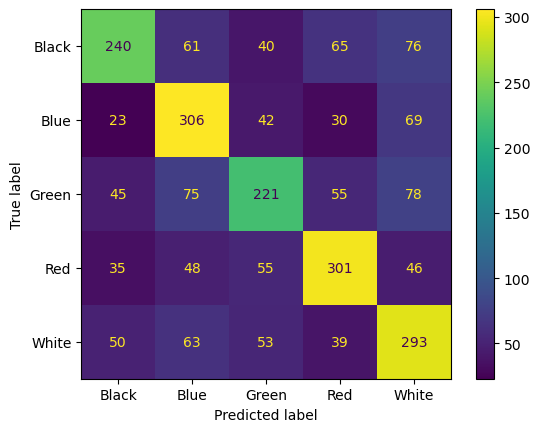

In [82]:
#Create confusion matrix of results
y_pred_CV350b = bern_CV350.predict(test_X_CV350b)
cm_CV350b=confusion_matrix(label_test_CV350b, y_pred_CV350b, labels=bern_CV350.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV350b,
                              display_labels=bern_CV350.classes_)
disp.plot()
plt.show()

In [83]:
## MultinomialNB with TFIDFVectorizers ##

In [84]:
## TFIDF Vectorizer 250 to Train and Test ##

In [85]:
CVs_250TF = TF250.fit_transform(CleanTextListNoColors)
colnames_TF250 = TF250.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [86]:
TF250_DF = pd.DataFrame(CVs_250TF.toarray(), columns = colnames_TF250)

In [87]:
TF250_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.559536   0.0  0.296989        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  angel  ...  vigilance   wa  wall   warrior  way  win  wizard  \
0       0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
1       0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
2       0.0    0.0  ...    0.84981  0.0   0.0  0.000000  0.0  0.0     0.0   
3       0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
4       0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
...     ...    ...  ...        ...  ...   ...       ...  ...  ...     ...   
12039   0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
12040   0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
12041   0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   
12042   0.0    0.0  ...    0.00000  0.0   0.0  0.317966  0.0  0.0     0.0   
12043   0.0    0.0  ...    0.00000  0.0   0.0  0.000000  0.0  0.0     0.0   

       wolf  word  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
3       0.0   0.0     0.0  
4       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[12044 rows x 250 columns]

In [88]:
#Get rid of column names with less than 3 characters
for nextcol in TF250_DF.columns:
    if (len(str(nextcol))<3):
        TF250_DF = TF250_DF.drop([nextcol], axis = 1)

In [89]:
TF250_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.559536   0.0  0.296989        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  angel  ...  vehicle  vigilance  wall   warrior  way  win  wizard  \
0       0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
1       0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
2       0.0    0.0  ...      0.0    0.84981   0.0  0.000000  0.0  0.0     0.0   
3       0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
4       0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
...     ...    ...  ...      ...        ...   ...       ...  ...  ...     ...   
12039   0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12040   0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12041   0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12042   0.0    0.0  ...      0.0    0.00000   0.0  0.317966  0.0  0.0     0.0   
12043   0.0    0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   

       wolf  word  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
3       0.0   0.0     0.0  
4       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[12044 rows x 246 columns]

In [90]:
#Inserting the color labels into the dataframe
TF250_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [91]:
TF250_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.559536   0.0  0.296989        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  vehicle  vigilance  wall   warrior  way  win  wizard  \
0      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
1      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
2      0.0   0.0  ...      0.0    0.84981   0.0  0.000000  0.0  0.0     0.0   
3      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
4      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
...    ...   ...  ...      ...        ...   ...       ...  ...  ...     ...   
12039  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12040  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12041  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12042  0.0   0.0  ...      0.0    0.00000   0.0  0.317966  0.0  0.0     0.0   
12043  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   

       wolf  word  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
3       0.0   0.0     0.0  
4       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[12044 rows x 247 columns]

In [92]:
#Removing any rows where the row sum is 0
TF250_DF = TF250_DF.loc[(TF250_DF.sum(axis=1, numeric_only = True) != 0)]

In [93]:
TF250_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.559536   0.0  0.296989        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  vehicle  vigilance  wall   warrior  way  win  wizard  \
0      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
1      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
2      0.0   0.0  ...      0.0    0.84981   0.0  0.000000  0.0  0.0     0.0   
3      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
4      0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
...    ...   ...  ...      ...        ...   ...       ...  ...  ...     ...   
12039  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12040  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12041  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   
12042  0.0   0.0  ...      0.0    0.00000   0.0  0.317966  0.0  0.0     0.0   
12043  0.0   0.0  ...      0.0    0.00000   0.0  0.000000  0.0  0.0     0.0   

       wolf  word  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
3       0.0   0.0     0.0  
4       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[12043 rows x 247 columns]

In [94]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_TF250 , test_X_TF250, label_train_TF250, label_test_TF250 = train_test_split(TF250_DF.iloc[:, 1:], 
                                                                                 TF250_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = TF250_DF.iloc[:, 0])

In [95]:
#Create the MNB
nb_TF250 = MultinomialNB()

In [96]:
#Training the MNB
nb_TF250.fit(train_X_TF250, label_train_TF250)

MultinomialNB()

In [97]:
#Checking the balance of the labels present in the training data
unique, counts = np.unique(label_train_TF250, return_counts=True)
print(np.asarray((unique, counts)))

[['Black' 'Blue' 'Green' 'Red' 'White']
 [1926 1883 1894 1939 1992]]


In [98]:
## Most Informative Features for Naive Bayes based on CountVectorizer data ##

In [99]:
#Get the 20 most informative features for the cards
OrderedColors = ["Black", "Blue", "Green", "Red", "White"]

for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(nb_TF250.feature_log_prob_[i], train_X_TF250.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-4.218112304911162, 'hand'), (-4.186713614695312, 'gain'), (-4.170702779605082, 'flying'), (-4.156587377865752, 'enters'), (-4.132580948674304, 'counter'), (-4.131752263947921, 'loses'), (-4.054658843136033, 'discard'), (-4.050520554979661, 'control'), (-3.9671957529202606, 'destroy'), (-3.924547119988034, 'opponent'), (-3.888680937923584, 'battlefield'), (-3.8370389885078904, 'graveyard'), (-3.789941236672216, 'sacrifice'), (-3.682021848644606, 'end'), (-3.6625836766391373, 'player'), (-3.611412723679103, 'turn'), (-3.394093500961427, 'target'), (-3.370173063136649, 'life'), (-3.18901010458731, 'card'), (-2.8836923388688334, 'creature')]


The 20 most informative features for the Blue cards are:
[(-4.305408179774798, 'discard'), (-4.288477922336326, 'untap'), (-4.2566394394869045, 'permanent'), (-4.242525657633873, 'library'), (-4.222066704791444, 'enters'), (-4.120126916096494, 'cast'), (-4.064865444508632, 'battlefield'), (

In [100]:
#Test the model against the testing data
nb_TF250.score(test_X_TF250, label_test_TF250)

0.5695309256953093

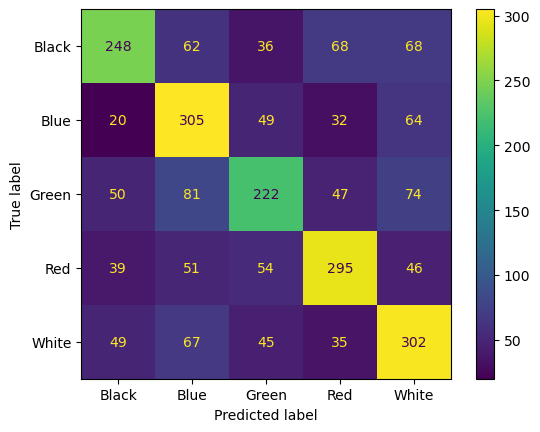

In [101]:
#Create confusion matrix of results
y_pred_TF250 = nb_TF250.predict(test_X_TF250)
cm_TF250=confusion_matrix(label_test_TF250, y_pred_TF250, labels=nb_TF250.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TF250,
                              display_labels=nb_TF250.classes_)
disp.plot()
plt.show()

In [102]:
## TFIDF Vectorizer 350 to Train and Test ##

In [103]:
CVs_350TF = TF350.fit_transform(CleanTextListNoColors)
colnames_TF350 = TF350.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [104]:
TF350_DF = pd.DataFrame(CVs_350TF.toarray(), columns = colnames_TF350)

In [105]:
TF350_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.559536   0.0  0.296989        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12044 rows x 350 columns]

In [106]:
#Get rid of column names with less than 3 characters
for nextcol in TF350_DF.columns:
    if (len(str(nextcol))<3):
        TF350_DF = TF350_DF.drop([nextcol], axis = 1)

In [107]:
TF350_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.559536   0.0  0.296989        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12044 rows x 346 columns]

In [108]:
#Inserting the color labels into the dataframe
TF350_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [109]:
TF350_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.559536   0.0  0.296989        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12044 rows x 347 columns]

In [110]:
#Removing any rows where the row sum is 0
TF350_DF = TF350_DF.loc[(TF350_DF.sum(axis=1, numeric_only = True) != 0)]

In [111]:
TF350_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.559536   0.0  0.296989        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12043 rows x 347 columns]

In [112]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_TF350 , test_X_TF350, label_train_TF350, label_test_TF350 = train_test_split(TF350_DF.iloc[:, 1:], 
                                                                                 TF350_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = TF350_DF.iloc[:, 0])

In [113]:
#Create the MNB
nb_TF350 = MultinomialNB()

In [114]:
#Training the MNB
nb_TF350.fit(train_X_TF350, label_train_TF350)

MultinomialNB()

In [115]:
#Test the model against the testing data
nb_TF350.score(test_X_TF350, label_test_TF350)

0.5699460356994603

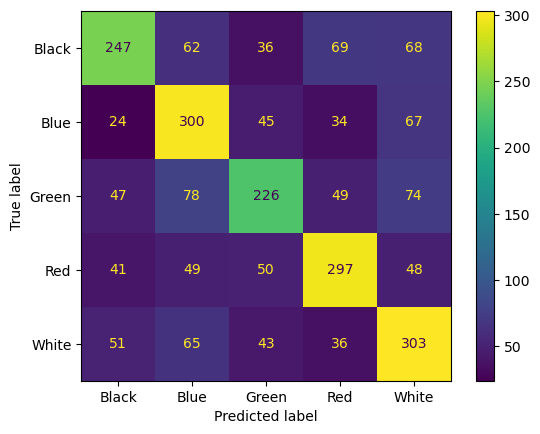

In [116]:
#Create confusion matrix of results
y_pred_TF350 = nb_TF350.predict(test_X_TF350)
cm_TF350=confusion_matrix(label_test_TF350, y_pred_TF350, labels=nb_TF350.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TF350,
                              display_labels=nb_TF350.classes_)
disp.plot()
plt.show()

In [117]:
## Running Naive Bayes with Common MTG Words Removed ##

In [118]:
#Getting the default list of English stop words used in the CountVectorizer functions
sets = [sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]

In [119]:
#Creating a new list that is not a frozen set so it can be edited
stop_words = [list(x) for x in sets]
stop_words = stop_words[0]
print(stop_words)

['such', 'can', 'under', 'most', 'front', 'if', 'top', 'now', 'yours', 'whole', 'its', 'it', 'describe', 'amount', 'these', 'thereby', 'is', 'some', 'others', 'un', 'therefore', 'serious', 'yet', 'both', 'twenty', 'formerly', 'all', 'and', 'towards', 'otherwise', 'between', 'wherever', 'alone', 'becomes', 'hasnt', 'everything', 'her', 'had', 'i', 'over', 'who', 'latter', 'cant', 'fire', 'your', 'us', 'mostly', 'together', 'side', 'we', 'almost', 'whoever', 'often', 'upon', 'eleven', 'even', 'me', 'where', 'twelve', 'eight', 'amongst', 'namely', 'never', 'except', 'hereafter', 'ie', 'down', 'none', 'until', 'empty', 'enough', 'any', 'nine', 'that', 'sometime', 'found', 'keep', 'of', 'against', 'indeed', 'anyhow', 'toward', 'whereafter', 'hereupon', 'somewhere', 'hereby', 'another', 'couldnt', 'no', 'thence', 'here', 'during', 'anything', 'co', 'other', 'anyone', 'off', 'either', 'somehow', 'hers', 'once', 'etc', 'through', 'several', 'nevertheless', 'see', 'back', 'thru', 'one', 'howeve

In [120]:
CommonMTGWords = ["target", "creature", "control", "battlefield", "turn", "end", "opponent",
                 "player", "card", "artifact", "cast", "counter", "spell"]

In [431]:
print(CommonMTGWords)

['target', 'creature', 'control', 'battlefield', 'turn', 'end', 'opponent', 'player', 'card', 'artifact', 'cast', 'counter', 'spell']


In [121]:
for word in CommonMTGWords:
    stop_words.append(word)

In [122]:
print(stop_words)

['such', 'can', 'under', 'most', 'front', 'if', 'top', 'now', 'yours', 'whole', 'its', 'it', 'describe', 'amount', 'these', 'thereby', 'is', 'some', 'others', 'un', 'therefore', 'serious', 'yet', 'both', 'twenty', 'formerly', 'all', 'and', 'towards', 'otherwise', 'between', 'wherever', 'alone', 'becomes', 'hasnt', 'everything', 'her', 'had', 'i', 'over', 'who', 'latter', 'cant', 'fire', 'your', 'us', 'mostly', 'together', 'side', 'we', 'almost', 'whoever', 'often', 'upon', 'eleven', 'even', 'me', 'where', 'twelve', 'eight', 'amongst', 'namely', 'never', 'except', 'hereafter', 'ie', 'down', 'none', 'until', 'empty', 'enough', 'any', 'nine', 'that', 'sometime', 'found', 'keep', 'of', 'against', 'indeed', 'anyhow', 'toward', 'whereafter', 'hereupon', 'somewhere', 'hereby', 'another', 'couldnt', 'no', 'thence', 'here', 'during', 'anything', 'co', 'other', 'anyone', 'off', 'either', 'somehow', 'hers', 'once', 'etc', 'through', 'several', 'nevertheless', 'see', 'back', 'thru', 'one', 'howeve

In [123]:
# Creating instances of Count Vectorizer

#CountVectorizers for MultinomialNB
CV250sw = CountVectorizer(input = "content", stop_words = stop_words, tokenizer = MY_LEMMER, max_features = 250)
CV350sw = CountVectorizer(input = "content", stop_words = stop_words, tokenizer = MY_LEMMER, max_features = 350)

#CountVectorizers for BernoulliNB
CV250bsw = CountVectorizer(input = "content", stop_words = stop_words, 
                         tokenizer = MY_LEMMER, binary = True, max_features = 250)
CV350bsw = CountVectorizer(input = "content", stop_words = stop_words, 
                         tokenizer = MY_LEMMER, binary = True, max_features = 350)

#TfidfVectorizers for MultinomialNB
TF250sw = TfidfVectorizer(input = "content", stop_words = stop_words, tokenizer = MY_LEMMER, max_features = 250)
TF350sw = TfidfVectorizer(input = "content", stop_words = stop_words, tokenizer = MY_LEMMER, max_features = 350)

In [124]:
## MultinomialNB with CountVectorizers ##

In [125]:
## Count Vectorizer 250 to Train and Test ##

In [126]:
CVs_250sw = CV250sw.fit_transform(CleanTextListNoColors)
colnames_CV250sw = CV250sw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [127]:
CV250sw_DF = pd.DataFrame(CVs_250sw.toarray(), columns = colnames_CV250sw)

In [128]:
CV250sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  wa  wall  warrior  way  win  wizard  wolf  word  \
0         0      0  ...   0     0        0    0    0       0     0     0   
1         0      0  ...   0     0        0    0    0       0     0     0   
2         0      0  ...   0     0        0    0    0       0     0     0   
3         0      0  ...   0     0        0    0    0       0     0     0   
4         0      0  ...   0     0        0    0    0       0     0     0   
...     ...    ...  ...  ..   ...      ...  ...  ...     ...   ...   ...   
12039     0      0  ...   0     0        0    0    0       0     0     0   
12040     0      0  ...   0     0        0    0    0       0     0     0   
12041     0      0  ...   0     0        0    0    0       0     0     0   
12042     0      0  ...   0     0        1    0    0       0     0     0   
12043     0      0  ...   0     0        0    0    0       0     0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 250 columns]

In [129]:
#Get rid of column names with less than 3 characters
for nextcol in CV250sw_DF.columns:
    if (len(str(nextcol))<3):
        CV250sw_DF = CV250sw_DF.drop([nextcol], axis = 1)

In [130]:
CV250sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vigilance  wall  warrior  way  win  wizard  wolf  \
0         0      0  ...          0     0        0    0    0       0     0   
1         0      0  ...          0     0        0    0    0       0     0   
2         0      0  ...          1     0        0    0    0       0     0   
3         0      0  ...          0     0        0    0    0       0     0   
4         0      0  ...          0     0        0    0    0       0     0   
...     ...    ...  ...        ...   ...      ...  ...  ...     ...   ...   
12039     0      0  ...          0     0        0    0    0       0     0   
12040     0      0  ...          0     0        0    0    0       0     0   
12041     0      0  ...          0     0        0    0    0       0     0   
12042     0      0  ...          0     0        1    0    0       0     0   
12043     0      0  ...          0     0        0    0    0       0     0   

       word  wurm  zombie  
0         0     0       0  
1         0     0       0  
2         0     0       0  
3         0     0       0  
4         0     0       0  
...     ...   ...     ...  
12039     0     0       0  
12040     0     0       0  
12041     0     0       0  
12042     0     0       0  
12043     0     0       0  

[12044 rows x 246 columns]

In [131]:
#Inserting the color labels into the dataframe
CV250sw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [132]:
CV250sw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vigilance  wall  warrior  way  win  wizard  wolf  word  \
0        0     0  ...          0     0        0    0    0       0     0     0   
1        0     0  ...          0     0        0    0    0       0     0     0   
2        0     0  ...          1     0        0    0    0       0     0     0   
3        0     0  ...          0     0        0    0    0       0     0     0   
4        0     0  ...          0     0        0    0    0       0     0     0   
...    ...   ...  ...        ...   ...      ...  ...  ...     ...   ...   ...   
12039    0     0  ...          0     0        0    0    0       0     0     0   
12040    0     0  ...          0     0        0    0    0       0     0     0   
12041    0     0  ...          0     0        0    0    0       0     0     0   
12042    0     0  ...          0     0        1    0    0       0     0     0   
12043    0     0  ...          0     0        0    0    0       0     0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 247 columns]

In [133]:
#Removing any rows where the row sum is 0
CV250sw_DF = CV250sw_DF.loc[(CV250sw_DF.sum(axis=1, numeric_only = True) != 0)]

In [134]:
CV250sw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
5      White        0     0         0          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vigilance  wall  warrior  way  win  wizard  wolf  word  \
0        0     0  ...          0     0        0    0    0       0     0     0   
1        0     0  ...          0     0        0    0    0       0     0     0   
2        0     0  ...          1     0        0    0    0       0     0     0   
4        0     0  ...          0     0        0    0    0       0     0     0   
5        0     0  ...          0     0        0    0    0       0     0     0   
...    ...   ...  ...        ...   ...      ...  ...  ...     ...   ...   ...   
12039    0     0  ...          0     0        0    0    0       0     0     0   
12040    0     0  ...          0     0        0    0    0       0     0     0   
12041    0     0  ...          0     0        0    0    0       0     0     0   
12042    0     0  ...          0     0        1    0    0       0     0     0   
12043    0     0  ...          0     0        0    0    0       0     0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
4         0       0  
5         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[11743 rows x 247 columns]

In [135]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV250sw, test_X_CV250sw, label_train_CV250sw, label_test_CV250sw = train_test_split(CV250sw_DF.iloc[:, 1:], 
                                                                                 CV250sw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV250sw_DF.iloc[:, 0])

In [136]:
#Create the MNB
nb_CV250sw = MultinomialNB()

In [137]:
#Training the MNB
nb_CV250sw.fit(train_X_CV250sw, label_train_CV250sw)

MultinomialNB()

In [138]:
#Checking the balance of the labels present in the training data
unique, counts = np.unique(label_train_CV250sw, return_counts=True)
print(np.asarray((unique, counts)))

[['Black' 'Blue' 'Green' 'Red' 'White']
 [1858 1845 1840 1902 1949]]


In [139]:
## Most Informative Features for Naive Bayes based on CountVectorizer data ##

In [140]:
#Get the 20 most informative features for the cards

for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(nb_CV250sw.feature_log_prob_[i], train_X_CV250sw.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-4.354860095805802, 'token'), (-4.31336036489905, 'beginning'), (-4.289262813319989, 'cost'), (-4.265732315909795, 'pay'), (-4.235195592049713, 'blocked'), (-4.16270009001156, 'deal'), (-4.108264883456543, 'exile'), (-3.9956460053483935, 'return'), (-3.889102757441518, 'draw'), (-3.8322398955469748, 'loses'), (-3.7736865867954004, 'flying'), (-3.741049657482378, 'damage'), (-3.6121159741064846, 'hand'), (-3.6000917811396835, 'destroy'), (-3.5882104532529304, 'discard'), (-3.5725851353498497, 'enters'), (-3.49792360658083, 'gain'), (-3.282000303240107, 'sacrifice'), (-3.2791059452137423, 'graveyard'), (-2.7505199004433702, 'life')]


The 20 most informative features for the Blue cards are:
[(-4.3154430129903565, 'enchant'), (-4.260527255394242, 'mana'), (-4.252922656009023, 'controller'), (-4.252922656009023, 'land'), (-4.237884778644482, 'sacrifice'), (-4.158990836174819, 'blocked'), (-4.105286657202958, 'enchanted'), (-4.0987

In [141]:
#Test the model against the testing data
nb_CV250sw.score(test_X_CV250sw, label_test_CV250sw)

0.5725840783312047

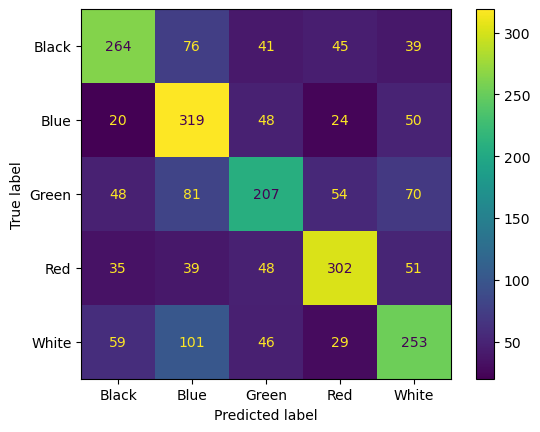

In [142]:
#Create confusion matrix of results
y_pred_CV250sw = nb_CV250sw.predict(test_X_CV250sw)
cm_CV250sw=confusion_matrix(label_test_CV250sw, y_pred_CV250sw, labels=nb_CV250sw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV250sw,
                              display_labels=nb_CV250sw.classes_)
disp.plot()
plt.show()

In [143]:
## Count Vectorizer 350 to Train and Test ##

In [144]:
CVs_350sw = CV350sw.fit_transform(CleanTextListNoColors)
colnames_CV350sw = CV350sw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [145]:
CV350sw_DF = pd.DataFrame(CVs_350sw.toarray(), columns = colnames_CV350sw)

In [146]:
CV350sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0         0      0  ...    0         0    0       0     0    0     0     0   
1         0      0  ...    0         0    0       0     0    0     0     0   
2         0      0  ...    0         0    0       0     0    0     0     0   
3         0      0  ...    0         0    0       0     0    0     0     0   
4         0      0  ...    0         0    0       0     0    0     0     0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039     0      0  ...    0         0    0       0     0    0     0     0   
12040     0      0  ...    0         0    0       0     0    0     0     0   
12041     0      0  ...    0         0    0       0     0    0     0     0   
12042     0      0  ...    0         0    0       0     0    0     0     0   
12043     0      0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12044 rows x 350 columns]

In [147]:
#Get rid of column names with less than 3 characters
for nextcol in CV350sw_DF.columns:
    if (len(str(nextcol))<3):
        CV350sw_DF = CV350sw_DF.drop([nextcol], axis = 1)

In [148]:
CV350sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            2     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0         0      0  ...    0         0    0       0     0    0     0     0   
1         0      0  ...    0         0    0       0     0    0     0     0   
2         0      0  ...    0         0    0       0     0    0     0     0   
3         0      0  ...    0         0    0       0     0    0     0     0   
4         0      0  ...    0         0    0       0     0    0     0     0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039     0      0  ...    0         0    0       0     0    0     0     0   
12040     0      0  ...    0         0    0       0     0    0     0     0   
12041     0      0  ...    0         0    0       0     0    0     0     0   
12042     0      0  ...    0         0    0       0     0    0     0     0   
12043     0      0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12044 rows x 346 columns]

In [149]:
#Inserting the color labels into the dataframe
CV350sw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [150]:
CV350sw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0        0     0  ...    0         0    0       0     0    0     0     0   
1        0     0  ...    0         0    0       0     0    0     0     0   
2        0     0  ...    0         0    0       0     0    0     0     0   
3        0     0  ...    0         0    0       0     0    0     0     0   
4        0     0  ...    0         0    0       0     0    0     0     0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039    0     0  ...    0         0    0       0     0    0     0     0   
12040    0     0  ...    0         0    0       0     0    0     0     0   
12041    0     0  ...    0         0    0       0     0    0     0     0   
12042    0     0  ...    0         0    0       0     0    0     0     0   
12043    0     0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
3           0     0  
4           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[12044 rows x 347 columns]

In [151]:
#Removing any rows where the row sum is 0
CV350sw_DF = CV350sw_DF.loc[(CV350sw_DF.sum(axis=1, numeric_only = True) != 0)]

In [152]:
CV350sw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
5      White        0     0         0          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0        0     0  ...    0         0    0       0     0    0     0     0   
1        0     0  ...    0         0    0       0     0    0     0     0   
2        0     0  ...    0         0    0       0     0    0     0     0   
4        0     0  ...    0         0    0       0     0    0     0     0   
5        0     0  ...    0         0    0       0     0    0     0     0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039    0     0  ...    0         0    0       0     0    0     0     0   
12040    0     0  ...    0         0    0       0     0    0     0     0   
12041    0     0  ...    0         0    0       0     0    0     0     0   
12042    0     0  ...    0         0    0       0     0    0     0     0   
12043    0     0  ...    0         0    0       0     0    0     0     0   

       zombie  zone  
0           0     0  
1           0     0  
2           0     0  
4           0     0  
5           0     0  
...       ...   ...  
12039       0     0  
12040       0     0  
12041       0     0  
12042       0     0  
12043       0     0  

[11764 rows x 347 columns]

In [153]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350sw, test_X_CV350sw, label_train_CV350sw, label_test_CV350sw = train_test_split(CV350sw_DF.iloc[:, 1:], 
                                                                                 CV350sw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV350sw_DF.iloc[:, 0])

In [154]:
#Create the MNB
nb_CV350sw = MultinomialNB()

In [155]:
#Training the MNB
nb_CV350sw.fit(train_X_CV350sw, label_train_CV350sw)

MultinomialNB()

In [156]:
#Test the model against the testing data
nb_CV350sw.score(test_X_CV350sw, label_test_CV350sw)

0.5750106247343817

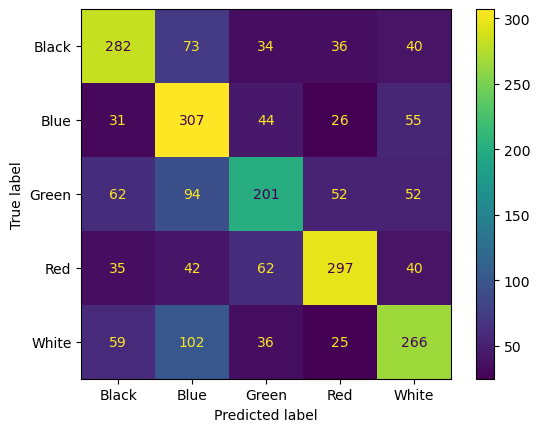

In [157]:
#Create confusion matrix of results
y_pred_CV350sw = nb_CV350sw.predict(test_X_CV350sw)
cm_CV350sw=confusion_matrix(label_test_CV350sw, y_pred_CV350sw, labels=nb_CV350sw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV350sw,
                              display_labels=nb_CV350sw.classes_)
disp.plot()
plt.show()

In [158]:
## BernoulliNB with Binary CountVectorizers ##

In [159]:
## Binary Count Vectorizer 250 to Train and Test ##

In [160]:
CVs_250bsw = CV250bsw.fit_transform(CleanTextListNoColors)
colnames_CV250bsw = CV250bsw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [161]:
CV250bsw_DF = pd.DataFrame(CVs_250bsw.toarray(), columns = colnames_CV250bsw)

In [162]:
CV250bsw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vehicle  vigilance  wa  wall  warrior  way  win  \
0         0      0  ...        0          0   0     0        0    0    0   
1         0      0  ...        0          0   0     0        0    0    0   
2         0      0  ...        0          1   0     0        0    0    0   
3         0      0  ...        0          0   0     0        0    0    0   
4         0      0  ...        0          0   0     0        0    0    0   
...     ...    ...  ...      ...        ...  ..   ...      ...  ...  ...   
12039     0      0  ...        0          0   0     0        0    0    0   
12040     0      0  ...        0          0   0     0        0    0    0   
12041     0      0  ...        0          0   0     0        0    0    0   
12042     0      0  ...        0          0   0     0        1    0    0   
12043     0      0  ...        0          0   0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12044 rows x 250 columns]

In [163]:
#Get rid of column names with less than 3 characters
for nextcol in CV250bsw_DF.columns:
    if (len(str(nextcol))<3):
        CV250bsw_DF = CV250bsw_DF.drop([nextcol], axis = 1)

In [164]:
CV250bsw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  angel  ...  vampire  vehicle  vigilance  wall  warrior  way  win  \
0         0      0  ...        0        0          0     0        0    0    0   
1         0      0  ...        0        0          0     0        0    0    0   
2         0      0  ...        0        0          1     0        0    0    0   
3         0      0  ...        0        0          0     0        0    0    0   
4         0      0  ...        0        0          0     0        0    0    0   
...     ...    ...  ...      ...      ...        ...   ...      ...  ...  ...   
12039     0      0  ...        0        0          0     0        0    0    0   
12040     0      0  ...        0        0          0     0        0    0    0   
12041     0      0  ...        0        0          0     0        0    0    0   
12042     0      0  ...        0        0          0     0        1    0    0   
12043     0      0  ...        0        0          0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12044 rows x 246 columns]

In [165]:
#Inserting the color labels into the dataframe
CV250bsw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [166]:
CV250bsw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vampire  vehicle  vigilance  wall  warrior  way  win  \
0        0     0  ...        0        0          0     0        0    0    0   
1        0     0  ...        0        0          0     0        0    0    0   
2        0     0  ...        0        0          1     0        0    0    0   
3        0     0  ...        0        0          0     0        0    0    0   
4        0     0  ...        0        0          0     0        0    0    0   
...    ...   ...  ...      ...      ...        ...   ...      ...  ...  ...   
12039    0     0  ...        0        0          0     0        0    0    0   
12040    0     0  ...        0        0          0     0        0    0    0   
12041    0     0  ...        0        0          0     0        0    0    0   
12042    0     0  ...        0        0          0     0        1    0    0   
12043    0     0  ...        0        0          0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
3           0     0       0  
4           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[12044 rows x 247 columns]

In [167]:
#Removing any rows where the row sum is 0
CV250bsw_DF = CV250bsw_DF.loc[(CV250bsw_DF.sum(axis=1, numeric_only = True) != 0)]

In [168]:
CV250bsw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
5      White        0     0         0          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  vampire  vehicle  vigilance  wall  warrior  way  win  \
0        0     0  ...        0        0          0     0        0    0    0   
1        0     0  ...        0        0          0     0        0    0    0   
2        0     0  ...        0        0          1     0        0    0    0   
4        0     0  ...        0        0          0     0        0    0    0   
5        0     0  ...        0        0          0     0        0    0    0   
...    ...   ...  ...      ...      ...        ...   ...      ...  ...  ...   
12039    0     0  ...        0        0          0     0        0    0    0   
12040    0     0  ...        0        0          0     0        0    0    0   
12041    0     0  ...        0        0          0     0        0    0    0   
12042    0     0  ...        0        0          0     0        1    0    0   
12043    0     0  ...        0        0          0     0        0    0    0   

       wizard  wolf  zombie  
0           0     0       0  
1           0     0       0  
2           0     0       0  
4           0     0       0  
5           0     0       0  
...       ...   ...     ...  
12039       0     0       0  
12040       0     0       0  
12041       0     0       0  
12042       0     0       0  
12043       0     0       0  

[11748 rows x 247 columns]

In [169]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV250bsw, test_X_CV250bsw, label_train_CV250bsw, label_test_CV250bsw = train_test_split(CV250bsw_DF.iloc[:, 1:], 
                                                                                 CV250bsw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV250bsw_DF.iloc[:, 0])

In [170]:
#Create the BernoulliNB
bern_CV250sw = BernoulliNB()

In [171]:
#Training the BernoulliNB
bern_CV250sw.fit(train_X_CV250bsw, label_train_CV250bsw)

BernoulliNB()

In [172]:
## Most Informative Features for Bernoulli Naive Bayes based on CountVectorizer data ##

In [173]:
for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(bern_CV250sw.feature_log_prob_[i], train_X_CV250bsw.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-2.7661578319094904, 'lose'), (-2.7325412211105053, 'beginning'), (-2.7325412211105053, 'cost'), (-2.7080502011022096, 'pay'), (-2.637982638485493, 'blocked'), (-2.586689344097943, 'deal'), (-2.586689344097943, 'exile'), (-2.4469274017227836, 'return'), (-2.3298347354414206, 'draw'), (-2.2350269419827544, 'loses'), (-2.2300144001592104, 'flying'), (-2.2151257876654595, 'damage'), (-2.116685714852207, 'hand'), (-2.090252457784051, 'discard'), (-2.0560610930357717, 'destroy'), (-1.987068221548821, 'enters'), (-1.922529700411249, 'gain'), (-1.7631406639224023, 'graveyard'), (-1.756890643577231, 'sacrifice'), (-1.3777289982609675, 'life')]


The 20 most informative features for the Blue cards are:
[(-2.7602262965893685, 'unless'), (-2.734908488605079, 'enchant'), (-2.734908488605079, 'mana'), (-2.7102158760147077, 'enchanted'), (-2.6782131449285336, 'controller'), (-2.6782131449285336, 'untap'), (-2.580757808777821, 'sacrifice'), 

In [174]:
#Test the model against the testing data
bern_CV250sw.score(test_X_CV250bsw, label_test_CV250bsw)

0.5697872340425532

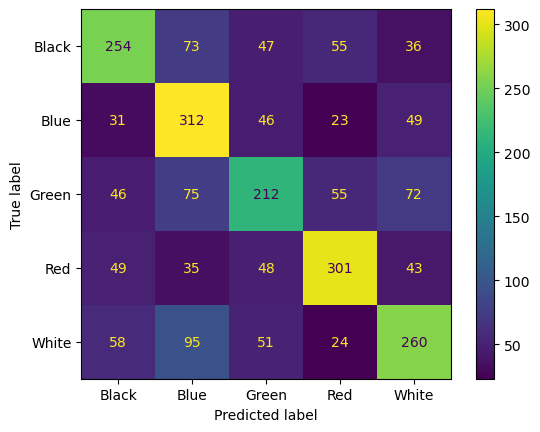

In [175]:
#Create confusion matrix of results
y_pred_CV250bsw = bern_CV250sw.predict(test_X_CV250bsw)
cm_CV250bsw=confusion_matrix(label_test_CV250bsw, y_pred_CV250bsw, labels=bern_CV250sw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV250bsw,
                              display_labels=bern_CV250sw.classes_)
disp.plot()
plt.show()

In [176]:
## Binary Count Vectorizer 350 to Train and Test ##

In [177]:
CVs_350bsw = CV350bsw.fit_transform(CleanTextListNoColors)
colnames_CV350bsw = CV350bsw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [178]:
CV350bsw_DF = pd.DataFrame(CVs_350bsw.toarray(), columns = colnames_CV350bsw)

In [179]:
CV350bsw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0         0      0  ...        0    0         0    0       0     0    0     0   
1         0      0  ...        0    0         0    0       0     0    0     0   
2         0      0  ...        0    0         0    0       0     0    0     0   
3         0      0  ...        0    0         0    0       0     0    0     0   
4         0      0  ...        0    0         0    0       0     0    0     0   
...     ...    ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039     0      0  ...        0    0         0    0       0     0    0     0   
12040     0      0  ...        0    0         0    0       0     0    0     0   
12041     0      0  ...        0    0         0    0       0     0    0     0   
12042     0      0  ...        1    0         0    0       0     0    0     0   
12043     0      0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 350 columns]

In [180]:
#Get rid of column names with less than 3 characters
for nextcol in CV350bsw_DF.columns:
    if (len(str(nextcol))<3):
        CV350bsw_DF = CV350bsw_DF.drop([nextcol], axis = 1)

In [181]:
CV350bsw_DF

ability  able  activate  activated  add  addition  additional  age  \
0            0     0         0          0    0         0           0    0   
1            0     0         0          0    0         0           0    0   
2            0     0         0          0    0         0           0    0   
3            0     0         0          0    0         0           0    0   
4            1     0         1          0    0         0           0    0   
...        ...   ...       ...        ...  ...       ...         ...  ...   
12039        0     0         0          0    0         0           0    0   
12040        0     0         0          0    0         0           0    0   
12041        0     0         0          0    0         0           0    0   
12042        0     0         0          0    0         0           0    0   
12043        0     0         0          0    0         0           0    0   

       ally  amass  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0         0      0  ...        0    0         0    0       0     0    0     0   
1         0      0  ...        0    0         0    0       0     0    0     0   
2         0      0  ...        0    0         0    0       0     0    0     0   
3         0      0  ...        0    0         0    0       0     0    0     0   
4         0      0  ...        0    0         0    0       0     0    0     0   
...     ...    ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039     0      0  ...        0    0         0    0       0     0    0     0   
12040     0      0  ...        0    0         0    0       0     0    0     0   
12041     0      0  ...        0    0         0    0       0     0    0     0   
12042     0      0  ...        1    0         0    0       0     0    0     0   
12043     0      0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 346 columns]

In [182]:
#Inserting the color labels into the dataframe
CV350bsw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [183]:
CV350bsw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0        0     0  ...        0    0         0    0       0     0    0     0   
1        0     0  ...        0    0         0    0       0     0    0     0   
2        0     0  ...        0    0         0    0       0     0    0     0   
3        0     0  ...        0    0         0    0       0     0    0     0   
4        0     0  ...        0    0         0    0       0     0    0     0   
...    ...   ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039    0     0  ...        0    0         0    0       0     0    0     0   
12040    0     0  ...        0    0         0    0       0     0    0     0   
12041    0     0  ...        0    0         0    0       0     0    0     0   
12042    0     0  ...        1    0         0    0       0     0    0     0   
12043    0     0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[12044 rows x 347 columns]

In [184]:
#Removing any rows where the row sum is 0
CV350bsw_DF = CV350bsw_DF.loc[(CV350bsw_DF.sum(axis=1, numeric_only = True) != 0)]

In [185]:
CV350bsw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
5      White        0     0         0          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       age  ally  ...  warrior  way  werewolf  win  wizard  wolf  won  word  \
0        0     0  ...        0    0         0    0       0     0    0     0   
1        0     0  ...        0    0         0    0       0     0    0     0   
2        0     0  ...        0    0         0    0       0     0    0     0   
4        0     0  ...        0    0         0    0       0     0    0     0   
5        0     0  ...        0    0         0    0       0     0    0     0   
...    ...   ...  ...      ...  ...       ...  ...     ...   ...  ...   ...   
12039    0     0  ...        0    0         0    0       0     0    0     0   
12040    0     0  ...        0    0         0    0       0     0    0     0   
12041    0     0  ...        0    0         0    0       0     0    0     0   
12042    0     0  ...        1    0         0    0       0     0    0     0   
12043    0     0  ...        0    0         0    0       0     0    0     0   

       wurm  zombie  
0         0       0  
1         0       0  
2         0       0  
4         0       0  
5         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     0       0  
12043     0       0  

[11773 rows x 347 columns]

In [186]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350bsw, test_X_CV350bsw, label_train_CV350bsw, label_test_CV350bsw = train_test_split(CV350bsw_DF.iloc[:, 1:], 
                                                                                 CV350bsw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV350bsw_DF.iloc[:, 0])

In [187]:
#Create the BernoulliNB
bern_CV350sw = BernoulliNB()

In [188]:
#Training the BernoulliNB
bern_CV350sw.fit(train_X_CV350bsw, label_train_CV350bsw)

BernoulliNB()

In [189]:
#Test the model against the testing data
bern_CV350sw.score(test_X_CV350bsw, label_test_CV350bsw)

0.5817409766454352

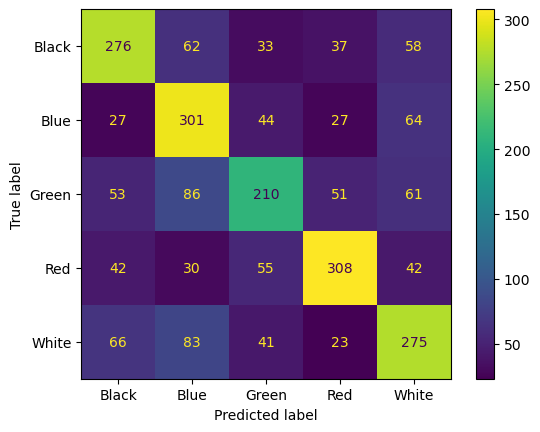

In [190]:
#Create confusion matrix of results
y_pred_CV350bsw = bern_CV350sw.predict(test_X_CV350bsw)
cm_CV350bsw=confusion_matrix(label_test_CV350bsw, y_pred_CV350bsw, labels=bern_CV350sw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV350bsw,
                              display_labels=bern_CV350sw.classes_)
disp.plot()
plt.show()

In [191]:
## MultinomialNB with TFIDFVectorizers ##

In [192]:
## TFIDF Vectorizer 250 to Train and Test ##

In [193]:
CVs_250TFsw = TF250sw.fit_transform(CleanTextListNoColors)
colnames_TF250sw = TF250sw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [194]:
TF250sw_DF = pd.DataFrame(CVs_250TFsw.toarray(), columns = colnames_TF250sw)

In [195]:
TF250sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.671701   0.0  0.356523        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  angel  ...   wa  wall   warrior  way  win  wizard  wolf  word  \
0       0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
1       0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
2       0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
3       0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
4       0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
...     ...    ...  ...  ...   ...       ...  ...  ...     ...   ...   ...   
12039   0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
12040   0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
12041   0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   
12042   0.0    0.0  ...  0.0   0.0  0.325486  0.0  0.0     0.0   0.0   0.0   
12043   0.0    0.0  ...  0.0   0.0  0.000000  0.0  0.0     0.0   0.0   0.0   

       wurm  zombie  
0       0.0     0.0  
1       0.0     0.0  
2       0.0     0.0  
3       0.0     0.0  
4       0.0     0.0  
...     ...     ...  
12039   0.0     0.0  
12040   0.0     0.0  
12041   0.0     0.0  
12042   0.0     0.0  
12043   0.0     0.0  

[12044 rows x 250 columns]

In [196]:
#Get rid of column names with less than 3 characters
for nextcol in TF250sw_DF.columns:
    if (len(str(nextcol))<3):
        TF250sw_DF = TF250sw_DF.drop([nextcol], axis = 1)

In [197]:
TF250sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.671701   0.0  0.356523        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  angel  ...  vigilance  wall   warrior  way  win  wizard  wolf  \
0       0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
1       0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
2       0.0    0.0  ...    0.84981   0.0  0.000000  0.0  0.0     0.0   0.0   
3       0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
4       0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
...     ...    ...  ...        ...   ...       ...  ...  ...     ...   ...   
12039   0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12040   0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12041   0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12042   0.0    0.0  ...    0.00000   0.0  0.325486  0.0  0.0     0.0   0.0   
12043   0.0    0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   

       word  wurm  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
3       0.0   0.0     0.0  
4       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[12044 rows x 246 columns]

In [198]:
#Inserting the color labels into the dataframe
TF250sw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [199]:
TF250sw_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.671701   0.0  0.356523        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  vigilance  wall   warrior  way  win  wizard  wolf  \
0      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
1      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
2      0.0   0.0  ...    0.84981   0.0  0.000000  0.0  0.0     0.0   0.0   
3      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
4      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
...    ...   ...  ...        ...   ...       ...  ...  ...     ...   ...   
12039  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12040  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12041  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12042  0.0   0.0  ...    0.00000   0.0  0.325486  0.0  0.0     0.0   0.0   
12043  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   

       word  wurm  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
3       0.0   0.0     0.0  
4       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[12044 rows x 247 columns]

In [200]:
#Removing any rows where the row sum is 0
TF250sw_DF = TF250sw_DF.loc[(TF250sw_DF.sum(axis=1, numeric_only = True) != 0)]

In [201]:
TF250sw_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.671701   0.0  0.356523        0.0  0.0       0.0         0.0   
5      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  vigilance  wall   warrior  way  win  wizard  wolf  \
0      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
1      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
2      0.0   0.0  ...    0.84981   0.0  0.000000  0.0  0.0     0.0   0.0   
4      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
5      0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
...    ...   ...  ...        ...   ...       ...  ...  ...     ...   ...   
12039  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12040  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12041  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   
12042  0.0   0.0  ...    0.00000   0.0  0.325486  0.0  0.0     0.0   0.0   
12043  0.0   0.0  ...    0.00000   0.0  0.000000  0.0  0.0     0.0   0.0   

       word  wurm  zombie  
0       0.0   0.0     0.0  
1       0.0   0.0     0.0  
2       0.0   0.0     0.0  
4       0.0   0.0     0.0  
5       0.0   0.0     0.0  
...     ...   ...     ...  
12039   0.0   0.0     0.0  
12040   0.0   0.0     0.0  
12041   0.0   0.0     0.0  
12042   0.0   0.0     0.0  
12043   0.0   0.0     0.0  

[11743 rows x 247 columns]

In [202]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_TF250sw, test_X_TF250sw, label_train_TF250sw, label_test_TF250sw = train_test_split(TF250sw_DF.iloc[:, 1:], 
                                                                                 TF250sw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = TF250sw_DF.iloc[:, 0])

In [203]:
#Create the MNB
nb_TF250sw = MultinomialNB()

In [204]:
#Training the MNB
nb_TF250sw.fit(train_X_TF250sw, label_train_TF250sw)

MultinomialNB()

In [205]:
#Checking the balance of the labels present in the training data
unique, counts = np.unique(label_train_TF250sw, return_counts=True)
print(np.asarray((unique, counts)))

[['Black' 'Blue' 'Green' 'Red' 'White']
 [1858 1845 1840 1902 1949]]


In [206]:
## Most Informative Features for Naive Bayes based on CountVectorizer data ##

In [207]:
#Get the 20 most informative features for the cards
for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(nb_TF250sw.feature_log_prob_[i], train_X_TF250sw.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-4.483939304445422, 'beginning'), (-4.4145428351179925, 'enchanted'), (-4.3531700278184005, 'deal'), (-4.347286908859571, 'pay'), (-4.309804445742293, 'blocked'), (-4.221404435962324, 'exile'), (-4.199661572205556, 'lose'), (-4.10570601030461, 'damage'), (-4.057849111949177, 'draw'), (-4.047677543352934, 'return'), (-3.849597783459851, 'hand'), (-3.8024472601853656, 'flying'), (-3.7844687861015185, 'gain'), (-3.741183409296065, 'loses'), (-3.6742028986994466, 'enters'), (-3.6180947156383096, 'destroy'), (-3.5587672081999715, 'discard'), (-3.4266602257754606, 'graveyard'), (-3.376066275388463, 'sacrifice'), (-2.996701786063846, 'life')]


The 20 most informative features for the Blue cards are:
[(-4.410006954059397, 'enchant'), (-4.378616459228181, 'sacrifice'), (-4.348582765578788, 'tap'), (-4.3173266909244585, 'unless'), (-4.300270758495509, 'cost'), (-4.286864544484522, 'controller'), (-4.238834674728764, 'graveyard'), (-4.2

In [208]:
#Test the model against the testing data
nb_TF250sw.score(test_X_TF250sw, label_test_TF250sw)

0.5734355044699873

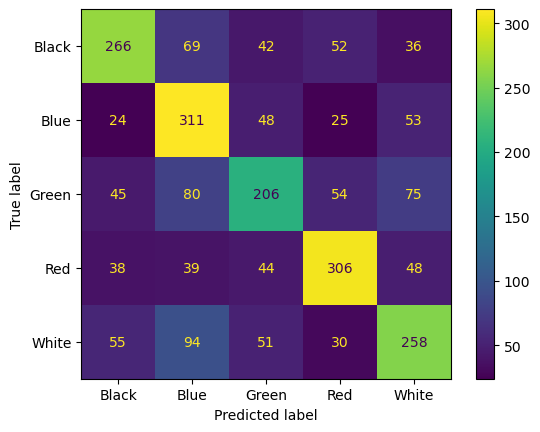

In [209]:
#Create confusion matrix of results
y_pred_TF250sw = nb_TF250sw.predict(test_X_TF250sw)
cm_TF250sw=confusion_matrix(label_test_TF250sw, y_pred_TF250sw, labels=nb_TF250sw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TF250sw,
                              display_labels=nb_TF250sw.classes_)
disp.plot()
plt.show()

In [210]:
## TFIDF Vectorizer 350 to Train and Test ##

In [211]:
CVs_350TFsw = TF350sw.fit_transform(CleanTextListNoColors)
colnames_TF350sw = TF350sw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [212]:
TF350sw_DF = pd.DataFrame(CVs_350TFsw.toarray(), columns = colnames_TF350sw)

In [213]:
TF350sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.671701   0.0  0.356523        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12044 rows x 350 columns]

In [214]:
#Get rid of column names with less than 3 characters
for nextcol in TF350sw_DF.columns:
    if (len(str(nextcol))<3):
        TF350sw_DF = TF350sw_DF.drop([nextcol], axis = 1)

In [215]:
TF350sw_DF

ability  able  activate  activated  add  addition  additional  age  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
4      0.671701   0.0  0.356523        0.0  0.0       0.0         0.0  0.0   
...         ...   ...       ...        ...  ...       ...         ...  ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0  0.0   

       ally  amass  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4       0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...     ...    ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043   0.0    0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12044 rows x 346 columns]

In [216]:
#Inserting the color labels into the dataframe
TF350sw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [217]:
TF350sw_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.671701   0.0  0.356523        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
3      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
3         0.0   0.0  
4         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[12044 rows x 347 columns]

In [218]:
#Removing any rows where the row sum is 0
TF350sw_DF = TF350sw_DF.loc[(TF350sw_DF.sum(axis=1, numeric_only = True) != 0)]

In [219]:
TF350sw_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.671701   0.0  0.356523        0.0  0.0       0.0         0.0   
5      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       age  ally  ...  way  werewolf  win  wizard  wolf  won  word  wurm  \
0      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
1      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
2      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
4      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
5      0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
...    ...   ...  ...  ...       ...  ...     ...   ...  ...   ...   ...   
12039  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12040  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12041  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12042  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   
12043  0.0   0.0  ...  0.0       0.0  0.0     0.0   0.0  0.0   0.0   0.0   

       zombie  zone  
0         0.0   0.0  
1         0.0   0.0  
2         0.0   0.0  
4         0.0   0.0  
5         0.0   0.0  
...       ...   ...  
12039     0.0   0.0  
12040     0.0   0.0  
12041     0.0   0.0  
12042     0.0   0.0  
12043     0.0   0.0  

[11764 rows x 347 columns]

In [220]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_TF350sw, test_X_TF350sw, label_train_TF350sw, label_test_TF350sw = train_test_split(TF350sw_DF.iloc[:, 1:], 
                                                                                 TF350sw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = TF350sw_DF.iloc[:, 0])

In [221]:
#Create the MNB
nb_TF350sw = MultinomialNB()

In [222]:
#Training the MNB
nb_TF350sw.fit(train_X_TF350sw, label_train_TF350sw)

MultinomialNB()

In [223]:
#Test the model against the testing data
nb_TF350sw.score(test_X_TF350sw, label_test_TF350sw)

0.5775605609859753

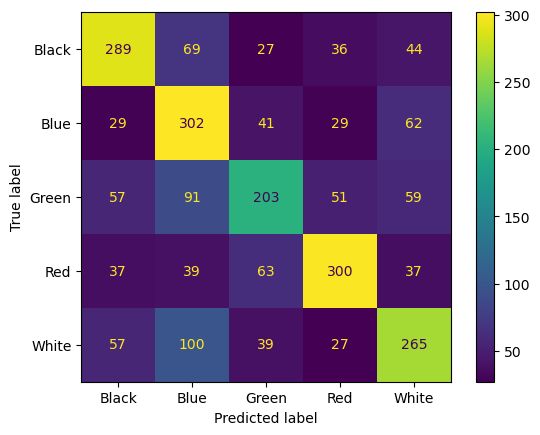

In [224]:
#Create confusion matrix of results
y_pred_TF350sw = nb_TF350sw.predict(test_X_TF350sw)
cm_TF350sw=confusion_matrix(label_test_TF350sw, y_pred_TF350sw, labels=nb_TF350sw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TF350sw,
                              display_labels=nb_TF350sw.classes_)
disp.plot()
plt.show()

In [225]:
## No Stop Words ##

In [226]:
# Creating instances of Count Vectorizer

#CountVectorizers for MultinomialNB
CV250nosw = CountVectorizer(input = "content", stop_words = None, tokenizer = MY_LEMMER, max_features = 250)
CV350nosw = CountVectorizer(input = "content", stop_words = None, tokenizer = MY_LEMMER, max_features = 350)

#CountVectorizers for BernoulliNB
CV250bnosw = CountVectorizer(input = "content", stop_words = None, 
                         tokenizer = MY_LEMMER, binary = True, max_features = 250)
CV350bnosw = CountVectorizer(input = "content", stop_words = None, 
                         tokenizer = MY_LEMMER, binary = True, max_features = 350)

#TfidfVectorizers for MultinomialNB
TF250nosw = TfidfVectorizer(input = "content", stop_words = None, tokenizer = MY_LEMMER, max_features = 250)
TF350nosw = TfidfVectorizer(input = "content", stop_words = None, tokenizer = MY_LEMMER, max_features = 350)

In [227]:
## MultinomialNB with CountVectorizers ##

In [228]:
## Count Vectorizer 250 to Train and Test ##

In [229]:
CVs_250nosw = CV250nosw.fit_transform(CleanTextListNoColors)
colnames_CV250nosw = CV250nosw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [230]:
CV250nosw_DF = pd.DataFrame(CVs_250nosw.toarray(), columns = colnames_CV250nosw)

In [231]:
CV250nosw_DF

ability  able  activate  activated  add  additional  age  all  also  \
0            0     0         0          0    0           0    0    0     0   
1            0     0         0          0    0           0    0    0     0   
2            0     0         0          0    0           0    0    0     0   
3            0     0         0          0    0           0    0    0     0   
4            2     0         1          0    0           0    0    0     0   
...        ...   ...       ...        ...  ...         ...  ...  ...   ...   
12039        0     0         0          0    0           0    0    0     0   
12040        0     0         0          0    0           0    0    0     0   
12041        0     0         0          0    0           0    0    0     0   
12042        0     0         0          0    0           0    0    0     0   
12043        0     0         0          0    0           0    0    0     0   

       among  ...  whenever  where  while  with  without  wizard  would  you  \
0          0  ...         0      0      0     0        0       0      0    1   
1          0  ...         0      0      0     0        0       0      0    0   
2          0  ...         0      0      0     0        0       0      0    0   
3          0  ...         0      0      0     0        0       0      0    0   
4          0  ...         0      0      0     0        0       0      0    0   
...      ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039      0  ...         0      0      0     2        0       0      0    1   
12040      0  ...         0      0      0     0        0       0      0    2   
12041      0  ...         1      0      0     0        0       0      0    0   
12042      0  ...         1      0      0     0        0       0      0    1   
12043      0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 250 columns]

In [232]:
#Get rid of column names with less than 3 characters
for nextcol in CV250nosw_DF.columns:
    if (len(str(nextcol))<3):
        CV250nosw_DF = CV250nosw_DF.drop([nextcol], axis = 1)

In [233]:
CV250nosw_DF

ability  able  activate  activated  add  additional  age  all  also  \
0            0     0         0          0    0           0    0    0     0   
1            0     0         0          0    0           0    0    0     0   
2            0     0         0          0    0           0    0    0     0   
3            0     0         0          0    0           0    0    0     0   
4            2     0         1          0    0           0    0    0     0   
...        ...   ...       ...        ...  ...         ...  ...  ...   ...   
12039        0     0         0          0    0           0    0    0     0   
12040        0     0         0          0    0           0    0    0     0   
12041        0     0         0          0    0           0    0    0     0   
12042        0     0         0          0    0           0    0    0     0   
12043        0     0         0          0    0           0    0    0     0   

       among  ...  whenever  where  while  with  without  wizard  would  you  \
0          0  ...         0      0      0     0        0       0      0    1   
1          0  ...         0      0      0     0        0       0      0    0   
2          0  ...         0      0      0     0        0       0      0    0   
3          0  ...         0      0      0     0        0       0      0    0   
4          0  ...         0      0      0     0        0       0      0    0   
...      ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039      0  ...         0      0      0     2        0       0      0    1   
12040      0  ...         0      0      0     0        0       0      0    2   
12041      0  ...         1      0      0     0        0       0      0    0   
12042      0  ...         1      0      0     0        0       0      0    1   
12043      0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 245 columns]

In [234]:
#Inserting the color labels into the dataframe
CV250nosw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [235]:
CV250nosw_DF

COLOR  ability  able  activate  activated  add  additional  age  all  \
0      White        0     0         0          0    0           0    0    0   
1      White        0     0         0          0    0           0    0    0   
2      White        0     0         0          0    0           0    0    0   
3      White        0     0         0          0    0           0    0    0   
4      White        2     0         1          0    0           0    0    0   
...      ...      ...   ...       ...        ...  ...         ...  ...  ...   
12039  Green        0     0         0          0    0           0    0    0   
12040  Green        0     0         0          0    0           0    0    0   
12041  Green        0     0         0          0    0           0    0    0   
12042  Green        0     0         0          0    0           0    0    0   
12043  Green        0     0         0          0    0           0    0    0   

       also  ...  whenever  where  while  with  without  wizard  would  you  \
0         0  ...         0      0      0     0        0       0      0    1   
1         0  ...         0      0      0     0        0       0      0    0   
2         0  ...         0      0      0     0        0       0      0    0   
3         0  ...         0      0      0     0        0       0      0    0   
4         0  ...         0      0      0     0        0       0      0    0   
...     ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039     0  ...         0      0      0     2        0       0      0    1   
12040     0  ...         0      0      0     0        0       0      0    2   
12041     0  ...         1      0      0     0        0       0      0    0   
12042     0  ...         1      0      0     0        0       0      0    1   
12043     0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 246 columns]

In [236]:
#Removing any rows where the row sum is 0
CV250nosw_DF = CV250nosw_DF.loc[(CV250nosw_DF.sum(axis=1, numeric_only = True) != 0)]

In [237]:
CV250nosw_DF

COLOR  ability  able  activate  activated  add  additional  age  all  \
0      White        0     0         0          0    0           0    0    0   
1      White        0     0         0          0    0           0    0    0   
2      White        0     0         0          0    0           0    0    0   
3      White        0     0         0          0    0           0    0    0   
4      White        2     0         1          0    0           0    0    0   
...      ...      ...   ...       ...        ...  ...         ...  ...  ...   
12039  Green        0     0         0          0    0           0    0    0   
12040  Green        0     0         0          0    0           0    0    0   
12041  Green        0     0         0          0    0           0    0    0   
12042  Green        0     0         0          0    0           0    0    0   
12043  Green        0     0         0          0    0           0    0    0   

       also  ...  whenever  where  while  with  without  wizard  would  you  \
0         0  ...         0      0      0     0        0       0      0    1   
1         0  ...         0      0      0     0        0       0      0    0   
2         0  ...         0      0      0     0        0       0      0    0   
3         0  ...         0      0      0     0        0       0      0    0   
4         0  ...         0      0      0     0        0       0      0    0   
...     ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039     0  ...         0      0      0     2        0       0      0    1   
12040     0  ...         0      0      0     0        0       0      0    2   
12041     0  ...         1      0      0     0        0       0      0    0   
12042     0  ...         1      0      0     0        0       0      0    1   
12043     0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12043 rows x 246 columns]

In [238]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV250nosw, test_X_CV250nosw, label_train_CV250nosw, label_test_CV250nosw = train_test_split(CV250nosw_DF.iloc[:, 1:], 
                                                                                 CV250nosw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV250nosw_DF.iloc[:, 0])

In [239]:
#Create the MNB
nb_CV250nosw = MultinomialNB()

In [240]:
#Training the MNB
nb_CV250nosw.fit(train_X_CV250nosw, label_train_CV250nosw)

MultinomialNB()

In [241]:
#Checking the balance of the labels present in the training data
unique, counts = np.unique(label_train_CV250nosw, return_counts=True)
print(np.asarray((unique, counts)))

[['Black' 'Blue' 'Green' 'Red' 'White']
 [1926 1883 1894 1939 1992]]


In [242]:
## Most Informative Features for Naive Bayes based on CountVectorizer data ##

In [243]:
#Get the 20 most informative features for the cards

for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(nb_CV250nosw.feature_log_prob_[i], train_X_CV250nosw.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-4.271285507839013, 'when'), (-4.2684486265038135, 'until'), (-4.232283350035744, 'from'), (-4.161107071567849, 'each'), (-4.158565774139176, 'battlefield'), (-4.156030918535988, 'end'), (-4.123649509032949, 'control'), (-4.116323468940876, 'get'), (-4.106638163206412, 'that'), (-3.9821839887330057, 'and'), (-3.9487080595366164, 'player'), (-3.8946408382663407, 'turn'), (-3.8601546621951712, 'this'), (-3.768446235705672, 'life'), (-3.6054978451748845, 'your'), (-3.414696528301815, 'target'), (-3.300807944623272, 'the'), (-3.215232833589699, 'card'), (-3.1726732191709033, 'you'), (-2.6533609815275936, 'creature')]


The 20 most informative features for the Blue cards are:
[(-4.436471629528944, 'and'), (-4.364779701072827, 'cast'), (-4.3430059015232665, 'counter'), (-4.324712708475941, 'may'), (-4.274628604078529, 'battlefield'), (-4.274628604078529, 'that'), (-4.205252664209188, 'hand'), (-4.197241940463109, 'player'), (-4.1606

In [244]:
#Test the model against the testing data
nb_CV250nosw.score(test_X_CV250nosw, label_test_CV250nosw)

0.5442092154420921

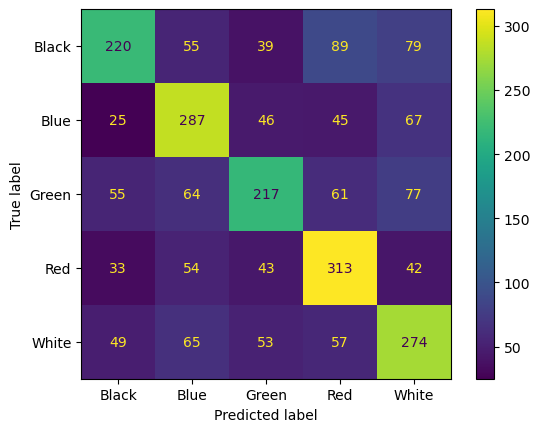

In [245]:
#Create confusion matrix of results
y_pred_CV250nosw = nb_CV250nosw.predict(test_X_CV250nosw)
cm_CV250nosw=confusion_matrix(label_test_CV250nosw, y_pred_CV250nosw, labels=nb_CV250nosw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV250nosw,
                              display_labels=nb_CV250nosw.classes_)
disp.plot()
plt.show()

In [246]:
## Count Vectorizer 350 to Train and Test ##

In [247]:
CVs_350nosw = CV350nosw.fit_transform(CleanTextListNoColors)
colnames_CV350nosw = CV350nosw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [248]:
CV350nosw_DF = pd.DataFrame(CVs_350nosw.toarray(), columns = colnames_CV350nosw)

In [249]:
CV350nosw_DF

ability  able  activate  activated  add  addition  additional  after  \
0            0     0         0          0    0         0           0      0   
1            0     0         0          0    0         0           0      0   
2            0     0         0          0    0         0           0      0   
3            0     0         0          0    0         0           0      0   
4            2     0         1          0    0         0           0      0   
...        ...   ...       ...        ...  ...       ...         ...    ...   
12039        0     0         0          0    0         0           0      0   
12040        0     0         0          0    0         0           0      0   
12041        0     0         0          0    0         0           0      0   
12042        0     0         0          0    0         0           0      0   
12043        0     0         0          0    0         0           0      0   

       age  all  ...  with  without  wizard  wolf  word  would  wurm  you  \
0        0    0  ...     0        0       0     0     0      0     0    1   
1        0    0  ...     0        0       0     0     0      0     0    0   
2        0    0  ...     0        0       0     0     0      0     0    0   
3        0    0  ...     0        0       0     0     0      0     0    0   
4        0    0  ...     0        0       0     0     0      0     0    0   
...    ...  ...  ...   ...      ...     ...   ...   ...    ...   ...  ...   
12039    0    0  ...     2        0       0     0     0      0     0    1   
12040    0    0  ...     0        0       0     0     0      0     0    2   
12041    0    0  ...     0        0       0     0     0      0     0    0   
12042    0    0  ...     0        0       0     0     0      0     0    1   
12043    0    0  ...     0        0       0     0     0      0     0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 350 columns]

In [250]:
#Get rid of column names with less than 3 characters
for nextcol in CV350nosw_DF.columns:
    if (len(str(nextcol))<3):
        CV350nosw_DF = CV350nosw_DF.drop([nextcol], axis = 1)

In [251]:
CV350nosw_DF

ability  able  activate  activated  add  addition  additional  after  \
0            0     0         0          0    0         0           0      0   
1            0     0         0          0    0         0           0      0   
2            0     0         0          0    0         0           0      0   
3            0     0         0          0    0         0           0      0   
4            2     0         1          0    0         0           0      0   
...        ...   ...       ...        ...  ...       ...         ...    ...   
12039        0     0         0          0    0         0           0      0   
12040        0     0         0          0    0         0           0      0   
12041        0     0         0          0    0         0           0      0   
12042        0     0         0          0    0         0           0      0   
12043        0     0         0          0    0         0           0      0   

       age  all  ...  with  without  wizard  wolf  word  would  wurm  you  \
0        0    0  ...     0        0       0     0     0      0     0    1   
1        0    0  ...     0        0       0     0     0      0     0    0   
2        0    0  ...     0        0       0     0     0      0     0    0   
3        0    0  ...     0        0       0     0     0      0     0    0   
4        0    0  ...     0        0       0     0     0      0     0    0   
...    ...  ...  ...   ...      ...     ...   ...   ...    ...   ...  ...   
12039    0    0  ...     2        0       0     0     0      0     0    1   
12040    0    0  ...     0        0       0     0     0      0     0    2   
12041    0    0  ...     0        0       0     0     0      0     0    0   
12042    0    0  ...     0        0       0     0     0      0     0    1   
12043    0    0  ...     0        0       0     0     0      0     0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 345 columns]

In [252]:
#Inserting the color labels into the dataframe
CV350nosw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [253]:
CV350nosw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       after  age  ...  with  without  wizard  wolf  word  would  wurm  you  \
0          0    0  ...     0        0       0     0     0      0     0    1   
1          0    0  ...     0        0       0     0     0      0     0    0   
2          0    0  ...     0        0       0     0     0      0     0    0   
3          0    0  ...     0        0       0     0     0      0     0    0   
4          0    0  ...     0        0       0     0     0      0     0    0   
...      ...  ...  ...   ...      ...     ...   ...   ...    ...   ...  ...   
12039      0    0  ...     2        0       0     0     0      0     0    1   
12040      0    0  ...     0        0       0     0     0      0     0    2   
12041      0    0  ...     0        0       0     0     0      0     0    0   
12042      0    0  ...     0        0       0     0     0      0     0    1   
12043      0    0  ...     0        0       0     0     0      0     0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 346 columns]

In [254]:
#Removing any rows where the row sum is 0
CV350nosw_DF = CV350nosw_DF.loc[(CV350nosw_DF.sum(axis=1, numeric_only = True) != 0)]

In [255]:
CV350nosw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        2     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       after  age  ...  with  without  wizard  wolf  word  would  wurm  you  \
0          0    0  ...     0        0       0     0     0      0     0    1   
1          0    0  ...     0        0       0     0     0      0     0    0   
2          0    0  ...     0        0       0     0     0      0     0    0   
3          0    0  ...     0        0       0     0     0      0     0    0   
4          0    0  ...     0        0       0     0     0      0     0    0   
...      ...  ...  ...   ...      ...     ...   ...   ...    ...   ...  ...   
12039      0    0  ...     2        0       0     0     0      0     0    1   
12040      0    0  ...     0        0       0     0     0      0     0    2   
12041      0    0  ...     0        0       0     0     0      0     0    0   
12042      0    0  ...     0        0       0     0     0      0     0    1   
12043      0    0  ...     0        0       0     0     0      0     0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12043 rows x 346 columns]

In [256]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350nosw, test_X_CV350nosw, label_train_CV350nosw, label_test_CV350nosw = train_test_split(CV350nosw_DF.iloc[:, 1:], 
                                                                                 CV350nosw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV350nosw_DF.iloc[:, 0])

In [257]:
#Create the MNB
nb_CV350nosw = MultinomialNB()

In [258]:
#Training the MNB
nb_CV350nosw.fit(train_X_CV350nosw, label_train_CV350nosw)

MultinomialNB()

In [259]:
#Test the model against the testing data
nb_CV350nosw.score(test_X_CV350nosw, label_test_CV350nosw)

0.5541718555417185

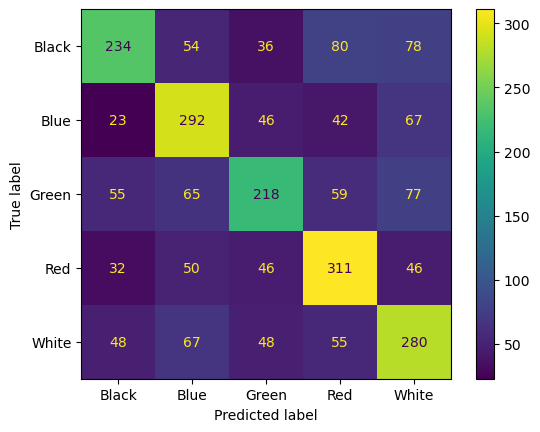

In [260]:
#Create confusion matrix of results
y_pred_CV350nosw = nb_CV350nosw.predict(test_X_CV350nosw)
cm_CV350nosw=confusion_matrix(label_test_CV350nosw, y_pred_CV350nosw, labels=nb_CV350nosw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV350nosw,
                              display_labels=nb_CV350nosw.classes_)
disp.plot()
plt.show()

In [261]:
## BernoulliNB with Binary CountVectorizers ##

In [262]:
## Binary Count Vectorizer 250 to Train and Test ##

In [263]:
CVs_250bnosw = CV250bnosw.fit_transform(CleanTextListNoColors)
colnames_CV250bnosw = CV250bnosw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [264]:
CV250bnosw_DF = pd.DataFrame(CVs_250bnosw.toarray(), columns = colnames_CV250bnosw)

In [265]:
CV250bnosw_DF

ability  able  activate  add  addition  additional  all  also  among  \
0            0     0         0    0         0           0    0     0      0   
1            0     0         0    0         0           0    0     0      0   
2            0     0         0    0         0           0    0     0      0   
3            0     0         0    0         0           0    0     0      0   
4            1     0         1    0         0           0    0     0      0   
...        ...   ...       ...  ...       ...         ...  ...   ...    ...   
12039        0     0         0    0         0           0    0     0      0   
12040        0     0         0    0         0           0    0     0      0   
12041        0     0         0    0         0           0    0     0      0   
12042        0     0         0    0         0           0    0     0      0   
12043        0     0         0    0         0           0    0     0      0   

       amount  ...  whenever  where  while  with  without  wizard  would  you  \
0           0  ...         0      0      0     0        0       0      0    1   
1           0  ...         0      0      0     0        0       0      0    0   
2           0  ...         0      0      0     0        0       0      0    0   
3           0  ...         0      0      0     0        0       0      0    0   
4           0  ...         0      0      0     0        0       0      0    0   
...       ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039       0  ...         0      0      0     1        0       0      0    1   
12040       0  ...         0      0      0     0        0       0      0    1   
12041       0  ...         1      0      0     0        0       0      0    0   
12042       0  ...         1      0      0     0        0       0      0    1   
12043       0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 250 columns]

In [266]:
#Get rid of column names with less than 3 characters
for nextcol in CV250bnosw_DF.columns:
    if (len(str(nextcol))<3):
        CV250bnosw_DF = CV250bnosw_DF.drop([nextcol], axis = 1)

In [267]:
CV250bnosw_DF

ability  able  activate  add  addition  additional  all  also  among  \
0            0     0         0    0         0           0    0     0      0   
1            0     0         0    0         0           0    0     0      0   
2            0     0         0    0         0           0    0     0      0   
3            0     0         0    0         0           0    0     0      0   
4            1     0         1    0         0           0    0     0      0   
...        ...   ...       ...  ...       ...         ...  ...   ...    ...   
12039        0     0         0    0         0           0    0     0      0   
12040        0     0         0    0         0           0    0     0      0   
12041        0     0         0    0         0           0    0     0      0   
12042        0     0         0    0         0           0    0     0      0   
12043        0     0         0    0         0           0    0     0      0   

       amount  ...  whenever  where  while  with  without  wizard  would  you  \
0           0  ...         0      0      0     0        0       0      0    1   
1           0  ...         0      0      0     0        0       0      0    0   
2           0  ...         0      0      0     0        0       0      0    0   
3           0  ...         0      0      0     0        0       0      0    0   
4           0  ...         0      0      0     0        0       0      0    0   
...       ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039       0  ...         0      0      0     1        0       0      0    1   
12040       0  ...         0      0      0     0        0       0      0    1   
12041       0  ...         1      0      0     0        0       0      0    0   
12042       0  ...         1      0      0     0        0       0      0    1   
12043       0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 245 columns]

In [268]:
#Inserting the color labels into the dataframe
CV250bnosw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [269]:
CV250bnosw_DF

COLOR  ability  able  activate  add  addition  additional  all  also  \
0      White        0     0         0    0         0           0    0     0   
1      White        0     0         0    0         0           0    0     0   
2      White        0     0         0    0         0           0    0     0   
3      White        0     0         0    0         0           0    0     0   
4      White        1     0         1    0         0           0    0     0   
...      ...      ...   ...       ...  ...       ...         ...  ...   ...   
12039  Green        0     0         0    0         0           0    0     0   
12040  Green        0     0         0    0         0           0    0     0   
12041  Green        0     0         0    0         0           0    0     0   
12042  Green        0     0         0    0         0           0    0     0   
12043  Green        0     0         0    0         0           0    0     0   

       among  ...  whenever  where  while  with  without  wizard  would  you  \
0          0  ...         0      0      0     0        0       0      0    1   
1          0  ...         0      0      0     0        0       0      0    0   
2          0  ...         0      0      0     0        0       0      0    0   
3          0  ...         0      0      0     0        0       0      0    0   
4          0  ...         0      0      0     0        0       0      0    0   
...      ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039      0  ...         0      0      0     1        0       0      0    1   
12040      0  ...         0      0      0     0        0       0      0    1   
12041      0  ...         1      0      0     0        0       0      0    0   
12042      0  ...         1      0      0     0        0       0      0    1   
12043      0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 246 columns]

In [270]:
#Removing any rows where the row sum is 0
CV250bnosw_DF = CV250bnosw_DF.loc[(CV250bnosw_DF.sum(axis=1, numeric_only = True) != 0)]

In [271]:
CV250bnosw_DF

COLOR  ability  able  activate  add  addition  additional  all  also  \
0      White        0     0         0    0         0           0    0     0   
1      White        0     0         0    0         0           0    0     0   
2      White        0     0         0    0         0           0    0     0   
3      White        0     0         0    0         0           0    0     0   
4      White        1     0         1    0         0           0    0     0   
...      ...      ...   ...       ...  ...       ...         ...  ...   ...   
12039  Green        0     0         0    0         0           0    0     0   
12040  Green        0     0         0    0         0           0    0     0   
12041  Green        0     0         0    0         0           0    0     0   
12042  Green        0     0         0    0         0           0    0     0   
12043  Green        0     0         0    0         0           0    0     0   

       among  ...  whenever  where  while  with  without  wizard  would  you  \
0          0  ...         0      0      0     0        0       0      0    1   
1          0  ...         0      0      0     0        0       0      0    0   
2          0  ...         0      0      0     0        0       0      0    0   
3          0  ...         0      0      0     0        0       0      0    0   
4          0  ...         0      0      0     0        0       0      0    0   
...      ...  ...       ...    ...    ...   ...      ...     ...    ...  ...   
12039      0  ...         0      0      0     1        0       0      0    1   
12040      0  ...         0      0      0     0        0       0      0    1   
12041      0  ...         1      0      0     0        0       0      0    0   
12042      0  ...         1      0      0     0        0       0      0    1   
12043      0  ...         0      0      0     0        0       0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12043 rows x 246 columns]

In [272]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV250bnosw, test_X_CV250bnosw, label_train_CV250bnosw, label_test_CV250bnosw = train_test_split(CV250bnosw_DF.iloc[:, 1:], 
                                                                                 CV250bnosw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV250bnosw_DF.iloc[:, 0])

In [273]:
#Create the BernoulliNB
bern_CV250nosw = BernoulliNB()

In [274]:
#Training the BernoulliNB
bern_CV250nosw.fit(train_X_CV250bnosw, label_train_CV250bnosw)

BernoulliNB()

In [275]:
## Most Informative Features for Bernoulli Naive Bayes based on CountVectorizer data ##

In [276]:
for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(bern_CV250nosw.feature_log_prob_[i], train_X_CV250bnosw.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-1.7501079433454247, 'each'), (-1.7471273152072868, 'until'), (-1.7441555448181294, 'that'), (-1.7441555448181294, 'when'), (-1.741192579687472, 'from'), (-1.6725942633447195, 'control'), (-1.661605141769125, 'player'), (-1.6399826777559587, 'battlefield'), (-1.63199328772248, 'end'), (-1.60840110570566, 'get'), (-1.5097991289011201, 'and'), (-1.4373692910563056, 'turn'), (-1.4308404321738424, 'your'), (-1.4243539229442357, 'life'), (-1.4136357067242118, 'this'), (-1.0103050711446802, 'the'), (-0.986377117449444, 'card'), (-0.9269804438860341, 'you'), (-0.9087981248028436, 'target'), (-0.4833705784797093, 'creature')]


The 20 most informative features for the Blue cards are:
[(-1.9322113046971516, 'cast'), (-1.910471318060746, 'counter'), (-1.910471318060746, 'when'), (-1.8547077435422912, 'player'), (-1.8148353522949145, 'that'), (-1.7891104610564783, 'may'), (-1.7486694914979672, 'battlefield'), (-1.6894806201076369, 'hand'

In [277]:
#Test the model against the testing data
bern_CV250nosw.score(test_X_CV250bnosw, label_test_CV250bnosw)

0.547530095475301

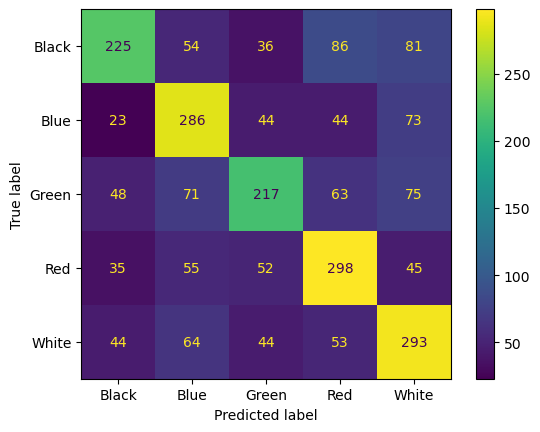

In [278]:
#Create confusion matrix of results
y_pred_CV250bnosw = bern_CV250nosw.predict(test_X_CV250bnosw)
cm_CV250bnosw=confusion_matrix(label_test_CV250bnosw, y_pred_CV250bnosw, labels=bern_CV250nosw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV250bnosw,
                              display_labels=bern_CV250nosw.classes_)
disp.plot()
plt.show()

In [279]:
## Binary Count Vectorizer 350 to Train and Test ##

In [280]:
CVs_350bnosw = CV350bnosw.fit_transform(CleanTextListNoColors)
colnames_CV350bnosw = CV350bnosw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [281]:
CV350bnosw_DF = pd.DataFrame(CVs_350bnosw.toarray(), columns = colnames_CV350bnosw)

In [282]:
CV350bnosw_DF

ability  able  activate  activated  add  addition  additional  after  \
0            0     0         0          0    0         0           0      0   
1            0     0         0          0    0         0           0      0   
2            0     0         0          0    0         0           0      0   
3            0     0         0          0    0         0           0      0   
4            1     0         1          0    0         0           0      0   
...        ...   ...       ...        ...  ...       ...         ...    ...   
12039        0     0         0          0    0         0           0      0   
12040        0     0         0          0    0         0           0      0   
12041        0     0         0          0    0         0           0      0   
12042        0     0         0          0    0         0           0      0   
12043        0     0         0          0    0         0           0      0   

       age  all  ...  who  win  with  without  wizard  wolf  would  you  your  \
0        0    0  ...    0    0     0        0       0     0      0    1     0   
1        0    0  ...    0    0     0        0       0     0      0    0     0   
2        0    0  ...    0    0     0        0       0     0      0    0     0   
3        0    0  ...    0    0     0        0       0     0      0    0     0   
4        0    0  ...    0    0     0        0       0     0      0    0     0   
...    ...  ...  ...  ...  ...   ...      ...     ...   ...    ...  ...   ...   
12039    0    0  ...    0    0     1        0       0     0      0    1     0   
12040    0    0  ...    0    0     0        0       0     0      0    1     0   
12041    0    0  ...    0    0     0        0       0     0      0    0     0   
12042    0    0  ...    0    0     0        0       0     0      0    1     1   
12043    0    0  ...    0    0     0        0       0     0      0    1     0   

       zombie  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
12039       0  
12040       0  
12041       0  
12042       0  
12043       0  

[12044 rows x 350 columns]

In [283]:
#Get rid of column names with less than 3 characters
for nextcol in CV350bnosw_DF.columns:
    if (len(str(nextcol))<3):
        CV350bnosw_DF = CV350bnosw_DF.drop([nextcol], axis = 1)

In [284]:
CV350bnosw_DF

ability  able  activate  activated  add  addition  additional  after  \
0            0     0         0          0    0         0           0      0   
1            0     0         0          0    0         0           0      0   
2            0     0         0          0    0         0           0      0   
3            0     0         0          0    0         0           0      0   
4            1     0         1          0    0         0           0      0   
...        ...   ...       ...        ...  ...       ...         ...    ...   
12039        0     0         0          0    0         0           0      0   
12040        0     0         0          0    0         0           0      0   
12041        0     0         0          0    0         0           0      0   
12042        0     0         0          0    0         0           0      0   
12043        0     0         0          0    0         0           0      0   

       age  all  ...  who  win  with  without  wizard  wolf  would  you  your  \
0        0    0  ...    0    0     0        0       0     0      0    1     0   
1        0    0  ...    0    0     0        0       0     0      0    0     0   
2        0    0  ...    0    0     0        0       0     0      0    0     0   
3        0    0  ...    0    0     0        0       0     0      0    0     0   
4        0    0  ...    0    0     0        0       0     0      0    0     0   
...    ...  ...  ...  ...  ...   ...      ...     ...   ...    ...  ...   ...   
12039    0    0  ...    0    0     1        0       0     0      0    1     0   
12040    0    0  ...    0    0     0        0       0     0      0    1     0   
12041    0    0  ...    0    0     0        0       0     0      0    0     0   
12042    0    0  ...    0    0     0        0       0     0      0    1     1   
12043    0    0  ...    0    0     0        0       0     0      0    1     0   

       zombie  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
12039       0  
12040       0  
12041       0  
12042       0  
12043       0  

[12044 rows x 345 columns]

In [285]:
#Inserting the color labels into the dataframe
CV350bnosw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [286]:
CV350bnosw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       after  age  ...  who  win  with  without  wizard  wolf  would  you  \
0          0    0  ...    0    0     0        0       0     0      0    1   
1          0    0  ...    0    0     0        0       0     0      0    0   
2          0    0  ...    0    0     0        0       0     0      0    0   
3          0    0  ...    0    0     0        0       0     0      0    0   
4          0    0  ...    0    0     0        0       0     0      0    0   
...      ...  ...  ...  ...  ...   ...      ...     ...   ...    ...  ...   
12039      0    0  ...    0    0     1        0       0     0      0    1   
12040      0    0  ...    0    0     0        0       0     0      0    1   
12041      0    0  ...    0    0     0        0       0     0      0    0   
12042      0    0  ...    0    0     0        0       0     0      0    1   
12043      0    0  ...    0    0     0        0       0     0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12044 rows x 346 columns]

In [287]:
#Removing any rows where the row sum is 0
CV350bnosw_DF = CV350bnosw_DF.loc[(CV350bnosw_DF.sum(axis=1, numeric_only = True) != 0)]

In [288]:
CV350bnosw_DF

COLOR  ability  able  activate  activated  add  addition  additional  \
0      White        0     0         0          0    0         0           0   
1      White        0     0         0          0    0         0           0   
2      White        0     0         0          0    0         0           0   
3      White        0     0         0          0    0         0           0   
4      White        1     0         1          0    0         0           0   
...      ...      ...   ...       ...        ...  ...       ...         ...   
12039  Green        0     0         0          0    0         0           0   
12040  Green        0     0         0          0    0         0           0   
12041  Green        0     0         0          0    0         0           0   
12042  Green        0     0         0          0    0         0           0   
12043  Green        0     0         0          0    0         0           0   

       after  age  ...  who  win  with  without  wizard  wolf  would  you  \
0          0    0  ...    0    0     0        0       0     0      0    1   
1          0    0  ...    0    0     0        0       0     0      0    0   
2          0    0  ...    0    0     0        0       0     0      0    0   
3          0    0  ...    0    0     0        0       0     0      0    0   
4          0    0  ...    0    0     0        0       0     0      0    0   
...      ...  ...  ...  ...  ...   ...      ...     ...   ...    ...  ...   
12039      0    0  ...    0    0     1        0       0     0      0    1   
12040      0    0  ...    0    0     0        0       0     0      0    1   
12041      0    0  ...    0    0     0        0       0     0      0    0   
12042      0    0  ...    0    0     0        0       0     0      0    1   
12043      0    0  ...    0    0     0        0       0     0      0    1   

       your  zombie  
0         0       0  
1         0       0  
2         0       0  
3         0       0  
4         0       0  
...     ...     ...  
12039     0       0  
12040     0       0  
12041     0       0  
12042     1       0  
12043     0       0  

[12043 rows x 346 columns]

In [289]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350bnosw, test_X_CV350bnosw, label_train_CV350bnosw, label_test_CV350bnosw = train_test_split(CV350bnosw_DF.iloc[:, 1:], 
                                                                                 CV350bnosw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = CV350bnosw_DF.iloc[:, 0])

In [290]:
#Create the BernoulliNB
bern_CV350nosw = BernoulliNB()

In [291]:
#Training the BernoulliNB
bern_CV350nosw.fit(train_X_CV350bnosw, label_train_CV350bnosw)

BernoulliNB()

In [292]:
#Test the model against the testing data
bern_CV350nosw.score(test_X_CV350bnosw, label_test_CV350bnosw)

0.5516811955168119

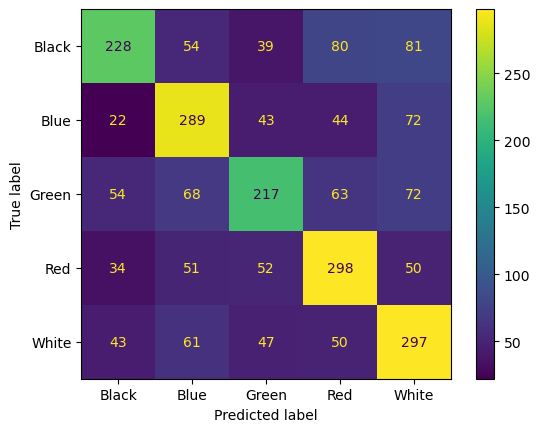

In [293]:
#Create confusion matrix of results
y_pred_CV350bnosw = bern_CV350nosw.predict(test_X_CV350bnosw)
cm_CV350bnosw=confusion_matrix(label_test_CV350bnosw, y_pred_CV350bnosw, labels=bern_CV350nosw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_CV350bnosw,
                              display_labels=bern_CV350nosw.classes_)
disp.plot()
plt.show()

In [294]:
## MultinomialNB with TFIDFVectorizers ##

In [295]:
## TFIDF Vectorizer 250 to Train and Test ##

In [296]:
CVs_250TFnosw = TF250nosw.fit_transform(CleanTextListNoColors)
colnames_TF250nosw = TF250nosw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [297]:
TF250nosw_DF = pd.DataFrame(CVs_250TFnosw.toarray(), columns = colnames_TF250nosw)

In [298]:
TF250nosw_DF

ability  able  activate  activated  add  additional  age  all  also  \
0      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
1      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
2      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
3      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
4      0.485557   0.0  0.257723        0.0  0.0         0.0  0.0  0.0   0.0   
...         ...   ...       ...        ...  ...         ...  ...  ...   ...   
12039  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12040  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12041  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12042  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12043  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   

       among  ...  whenever  where  while      with  without  wizard  would  \
0        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
1        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
2        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
3        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
4        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
...      ...  ...       ...    ...    ...       ...      ...     ...    ...   
12039    0.0  ...  0.000000    0.0    0.0  0.311527      0.0     0.0    0.0   
12040    0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
12041    0.0  ...  0.227799    0.0    0.0  0.000000      0.0     0.0    0.0   
12042    0.0  ...  0.137743    0.0    0.0  0.000000      0.0     0.0    0.0   
12043    0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   

            you      your  zombie  
0      0.176416  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.096365  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.130344  0.000000     0.0  

[12044 rows x 250 columns]

In [299]:
#Get rid of column names with less than 3 characters
for nextcol in TF250nosw_DF.columns:
    if (len(str(nextcol))<3):
        TF250nosw_DF = TF250nosw_DF.drop([nextcol], axis = 1)

In [300]:
TF250nosw_DF

ability  able  activate  activated  add  additional  age  all  also  \
0      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
1      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
2      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
3      0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
4      0.485557   0.0  0.257723        0.0  0.0         0.0  0.0  0.0   0.0   
...         ...   ...       ...        ...  ...         ...  ...  ...   ...   
12039  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12040  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12041  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12042  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   
12043  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   0.0   

       among  ...  whenever  where  while      with  without  wizard  would  \
0        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
1        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
2        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
3        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
4        0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
...      ...  ...       ...    ...    ...       ...      ...     ...    ...   
12039    0.0  ...  0.000000    0.0    0.0  0.311527      0.0     0.0    0.0   
12040    0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
12041    0.0  ...  0.227799    0.0    0.0  0.000000      0.0     0.0    0.0   
12042    0.0  ...  0.137743    0.0    0.0  0.000000      0.0     0.0    0.0   
12043    0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   

            you      your  zombie  
0      0.176416  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.096365  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.130344  0.000000     0.0  

[12044 rows x 245 columns]

In [301]:
#Inserting the color labels into the dataframe
TF250nosw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [302]:
TF250nosw_DF

COLOR   ability  able  activate  activated  add  additional  age  all  \
0      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
4      White  0.485557   0.0  0.257723        0.0  0.0         0.0  0.0  0.0   
...      ...       ...   ...       ...        ...  ...         ...  ...  ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   

       also  ...  whenever  where  while      with  without  wizard  would  \
0       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
1       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
2       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
3       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
4       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
...     ...  ...       ...    ...    ...       ...      ...     ...    ...   
12039   0.0  ...  0.000000    0.0    0.0  0.311527      0.0     0.0    0.0   
12040   0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
12041   0.0  ...  0.227799    0.0    0.0  0.000000      0.0     0.0    0.0   
12042   0.0  ...  0.137743    0.0    0.0  0.000000      0.0     0.0    0.0   
12043   0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   

            you      your  zombie  
0      0.176416  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.096365  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.130344  0.000000     0.0  

[12044 rows x 246 columns]

In [303]:
#Removing any rows where the row sum is 0
TF250nosw_DF = TF250nosw_DF.loc[(TF250nosw_DF.sum(axis=1, numeric_only = True) != 0)]

In [304]:
TF250nosw_DF

COLOR   ability  able  activate  activated  add  additional  age  all  \
0      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
4      White  0.485557   0.0  0.257723        0.0  0.0         0.0  0.0  0.0   
...      ...       ...   ...       ...        ...  ...         ...  ...  ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0         0.0  0.0  0.0   

       also  ...  whenever  where  while      with  without  wizard  would  \
0       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
1       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
2       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
3       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
4       0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
...     ...  ...       ...    ...    ...       ...      ...     ...    ...   
12039   0.0  ...  0.000000    0.0    0.0  0.311527      0.0     0.0    0.0   
12040   0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   
12041   0.0  ...  0.227799    0.0    0.0  0.000000      0.0     0.0    0.0   
12042   0.0  ...  0.137743    0.0    0.0  0.000000      0.0     0.0    0.0   
12043   0.0  ...  0.000000    0.0    0.0  0.000000      0.0     0.0    0.0   

            you      your  zombie  
0      0.176416  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.096365  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.130344  0.000000     0.0  

[12043 rows x 246 columns]

In [305]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_TF250nosw, test_X_TF250nosw, label_train_TF250nosw, label_test_TF250nosw = train_test_split(TF250nosw_DF.iloc[:, 1:], 
                                                                                 TF250nosw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = TF250nosw_DF.iloc[:, 0])

In [306]:
#Create the MNB
nb_TF250nosw = MultinomialNB()

In [307]:
#Training the MNB
nb_TF250nosw.fit(train_X_TF250nosw, label_train_TF250nosw)

MultinomialNB()

In [308]:
#Checking the balance of the labels present in the training data
unique, counts = np.unique(label_train_TF250nosw, return_counts=True)
print(np.asarray((unique, counts)))

[['Black' 'Blue' 'Green' 'Red' 'White']
 [1926 1883 1894 1939 1992]]


In [309]:
## Most Informative Features for Naive Bayes based on CountVectorizer data ##

In [310]:
#Get the 20 most informative features for the cards
for i in range(0,5):
    print("The 20 most informative features for the", OrderedColors[i], "cards are:")
    feature_ranks = sorted(zip(nb_TF250nosw.feature_log_prob_[i], train_X_TF250nosw.columns))
    features = feature_ranks[-20:]
    print(features)
    print()
    print()

The 20 most informative features for the Black cards are:
[(-4.299649894041285, 'graveyard'), (-4.291722241696693, 'battlefield'), (-4.266452495110904, 'when'), (-4.256543105275143, 'each'), (-4.250840646963531, 'this'), (-4.232533805144707, 'destroy'), (-4.207579838004678, 'and'), (-4.170829317841656, 'until'), (-4.124936521795983, 'sacrifice'), (-4.116013793017142, 'end'), (-4.040261065455593, 'turn'), (-4.0288693009959555, 'player'), (-3.9894878359315644, 'get'), (-3.949304937238283, 'your'), (-3.810675429954311, 'the'), (-3.7534836483839626, 'target'), (-3.752882320730439, 'you'), (-3.716205650765537, 'life'), (-3.6075142517387935, 'card'), (-3.2617629555828414, 'creature')]


The 20 most informative features for the Blue cards are:
[(-4.481187531961023, 'may'), (-4.457468723860156, 'cast'), (-4.455124169717432, 'battlefield'), (-4.386778129999639, 'turn'), (-4.349629736168086, 'return'), (-4.294788087497607, 'counter'), (-4.2706914328718115, 'this'), (-4.2700547910850135, 'player'

In [311]:
#Test the model against the testing data
nb_TF250nosw.score(test_X_TF250nosw, label_test_TF250nosw)

0.5624740556247405

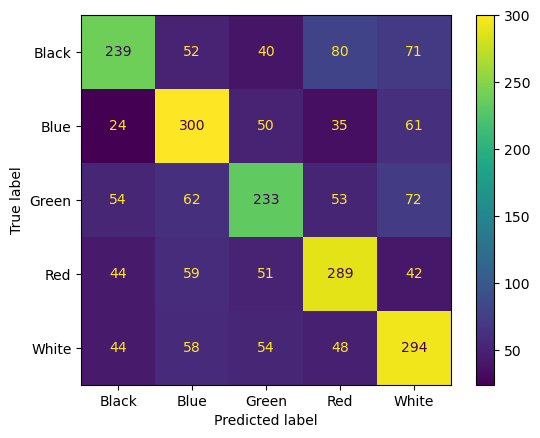

In [312]:
#Create confusion matrix of results
y_pred_TF250nosw = nb_TF250nosw.predict(test_X_TF250nosw)
cm_TF250nosw=confusion_matrix(label_test_TF250nosw, y_pred_TF250nosw, labels=nb_TF250nosw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TF250nosw,
                              display_labels=nb_TF250nosw.classes_)
disp.plot()
plt.show()

In [313]:
## TFIDF Vectorizer 350 to Train and Test ##

In [314]:
CVs_350TFnosw = TF350nosw.fit_transform(CleanTextListNoColors)
colnames_TF350nosw = TF350nosw.get_feature_names_out()

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [315]:
TF350nosw_DF = pd.DataFrame(CVs_350TFnosw.toarray(), columns = colnames_TF350nosw)

In [316]:
TF350nosw_DF

ability  able  activate  activated  add  addition  additional  after  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
4      0.485557   0.0  0.257723        0.0  0.0       0.0         0.0    0.0   
...         ...   ...       ...        ...  ...       ...         ...    ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   

       age  all  ...      with  without  wizard  wolf  word  would  wurm  \
0      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
1      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
2      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
3      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
4      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
...    ...  ...  ...       ...      ...     ...   ...   ...    ...   ...   
12039  0.0  0.0  ...  0.255437      0.0     0.0   0.0   0.0    0.0   0.0   
12040  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12041  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12042  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12043  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   

            you      your  zombie  
0      0.100807  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.079015  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.117592  0.000000     0.0  

[12044 rows x 350 columns]

In [317]:
#Get rid of column names with less than 3 characters
for nextcol in TF350nosw_DF.columns:
    if (len(str(nextcol))<3):
        TF350nosw_DF = TF350nosw_DF.drop([nextcol], axis = 1)

In [318]:
TF350nosw_DF

ability  able  activate  activated  add  addition  additional  after  \
0      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
1      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
2      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
3      0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
4      0.485557   0.0  0.257723        0.0  0.0       0.0         0.0    0.0   
...         ...   ...       ...        ...  ...       ...         ...    ...   
12039  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12040  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12041  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12042  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   
12043  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0    0.0   

       age  all  ...      with  without  wizard  wolf  word  would  wurm  \
0      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
1      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
2      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
3      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
4      0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
...    ...  ...  ...       ...      ...     ...   ...   ...    ...   ...   
12039  0.0  0.0  ...  0.255437      0.0     0.0   0.0   0.0    0.0   0.0   
12040  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12041  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12042  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12043  0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   

            you      your  zombie  
0      0.100807  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.079015  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.117592  0.000000     0.0  

[12044 rows x 345 columns]

In [319]:
#Inserting the color labels into the dataframe
TF350nosw_DF.insert(loc = 0, column = "COLOR", value = ColorList)

In [320]:
TF350nosw_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.485557   0.0  0.257723        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       after  age  ...      with  without  wizard  wolf  word  would  wurm  \
0        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
1        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
2        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
3        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
4        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
...      ...  ...  ...       ...      ...     ...   ...   ...    ...   ...   
12039    0.0  0.0  ...  0.255437      0.0     0.0   0.0   0.0    0.0   0.0   
12040    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12041    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12042    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12043    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   

            you      your  zombie  
0      0.100807  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.079015  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.117592  0.000000     0.0  

[12044 rows x 346 columns]

In [321]:
#Removing any rows where the row sum is 0
TF350nosw_DF = TF350nosw_DF.loc[(TF350nosw_DF.sum(axis=1, numeric_only = True) != 0)]

In [322]:
TF350nosw_DF

COLOR   ability  able  activate  activated  add  addition  additional  \
0      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
1      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
2      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
3      White  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
4      White  0.485557   0.0  0.257723        0.0  0.0       0.0         0.0   
...      ...       ...   ...       ...        ...  ...       ...         ...   
12039  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12040  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12041  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12042  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   
12043  Green  0.000000   0.0  0.000000        0.0  0.0       0.0         0.0   

       after  age  ...      with  without  wizard  wolf  word  would  wurm  \
0        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
1        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
2        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
3        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
4        0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
...      ...  ...  ...       ...      ...     ...   ...   ...    ...   ...   
12039    0.0  0.0  ...  0.255437      0.0     0.0   0.0   0.0    0.0   0.0   
12040    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12041    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12042    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   
12043    0.0  0.0  ...  0.000000      0.0     0.0   0.0   0.0    0.0   0.0   

            you      your  zombie  
0      0.100807  0.000000     0.0  
1      0.000000  0.000000     0.0  
2      0.000000  0.000000     0.0  
3      0.000000  0.000000     0.0  
4      0.000000  0.000000     0.0  
...         ...       ...     ...  
12039  0.079015  0.000000     0.0  
12040  0.271788  0.000000     0.0  
12041  0.000000  0.000000     0.0  
12042  0.091423  0.122593     0.0  
12043  0.117592  0.000000     0.0  

[12043 rows x 346 columns]

In [323]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 20% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_TF350nosw, test_X_TF350nosw, label_train_TF350nosw, label_test_TF350nosw = train_test_split(TF350nosw_DF.iloc[:, 1:], 
                                                                                 TF350nosw_DF.iloc[:, 0],
                                                                                test_size = 0.20,
                                                                                random_state = 99,
                                                                                stratify = TF350nosw_DF.iloc[:, 0])

In [324]:
#Create the MNB
nb_TF350nosw = MultinomialNB()

In [325]:
#Training the MNB
nb_TF350nosw.fit(train_X_TF350nosw, label_train_TF350nosw)

MultinomialNB()

In [326]:
#Test the model against the testing data
nb_TF350nosw.score(test_X_TF350nosw, label_test_TF350nosw)

0.5716064757160647

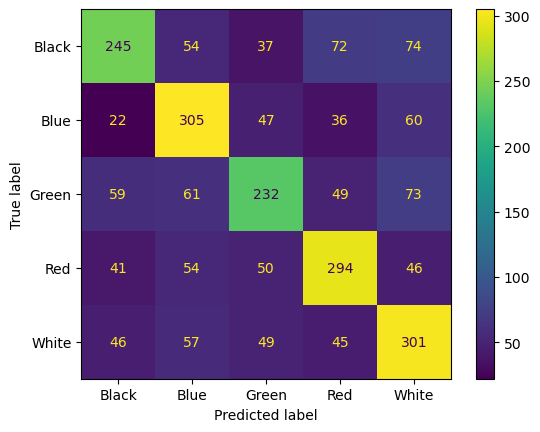

In [327]:
#Create confusion matrix of results
y_pred_TF350nosw = nb_TF350nosw.predict(test_X_TF350nosw)
cm_TF350nosw=confusion_matrix(label_test_TF350nosw, y_pred_TF350nosw, labels=nb_TF350nosw.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_TF350nosw,
                              display_labels=nb_TF350nosw.classes_)
disp.plot()
plt.show()

In [328]:
# Use Decision Trees on English + MTG Stop Words Data

With max depth of 8 , the accuracy is 0.4266893327666808


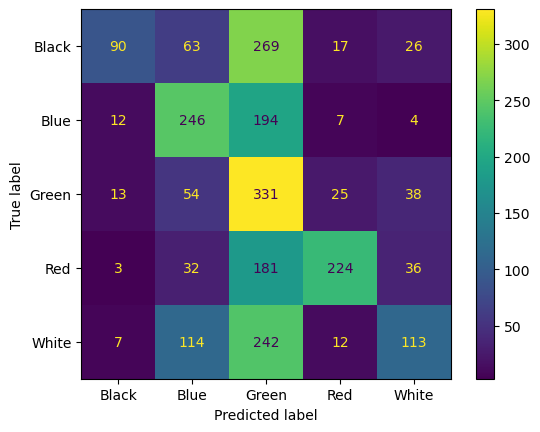

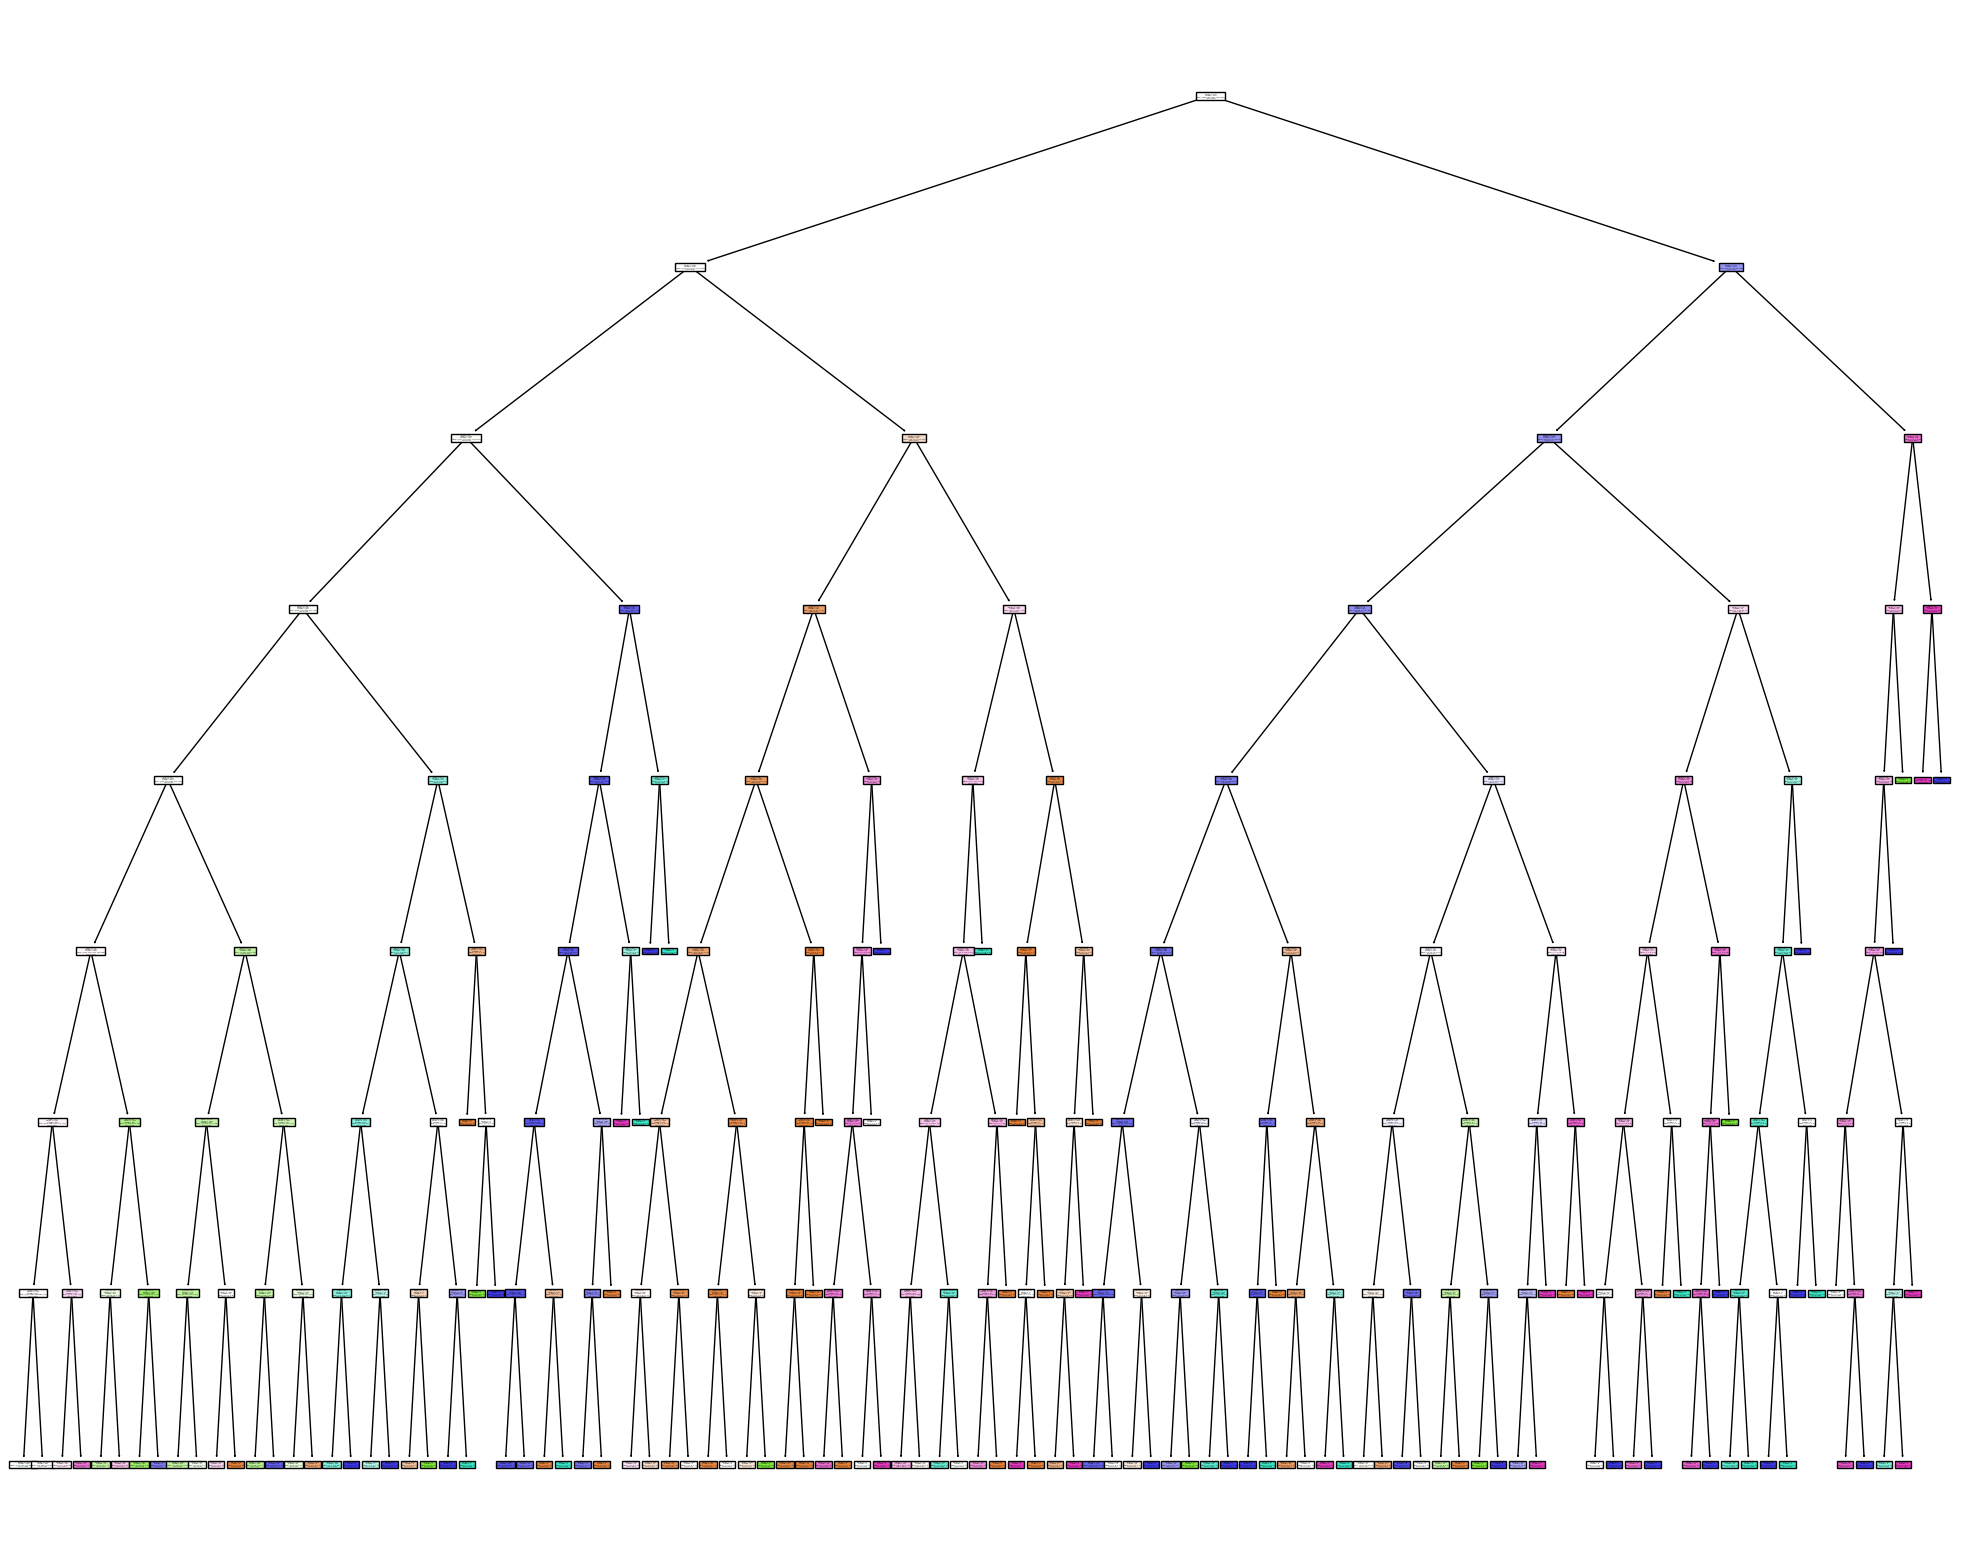

With max depth of 10 , the accuracy is 0.4266893327666808


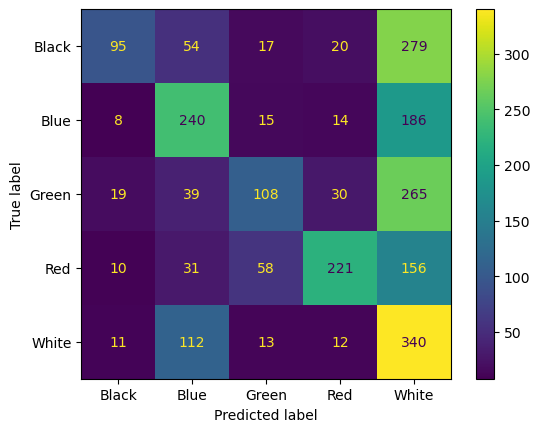

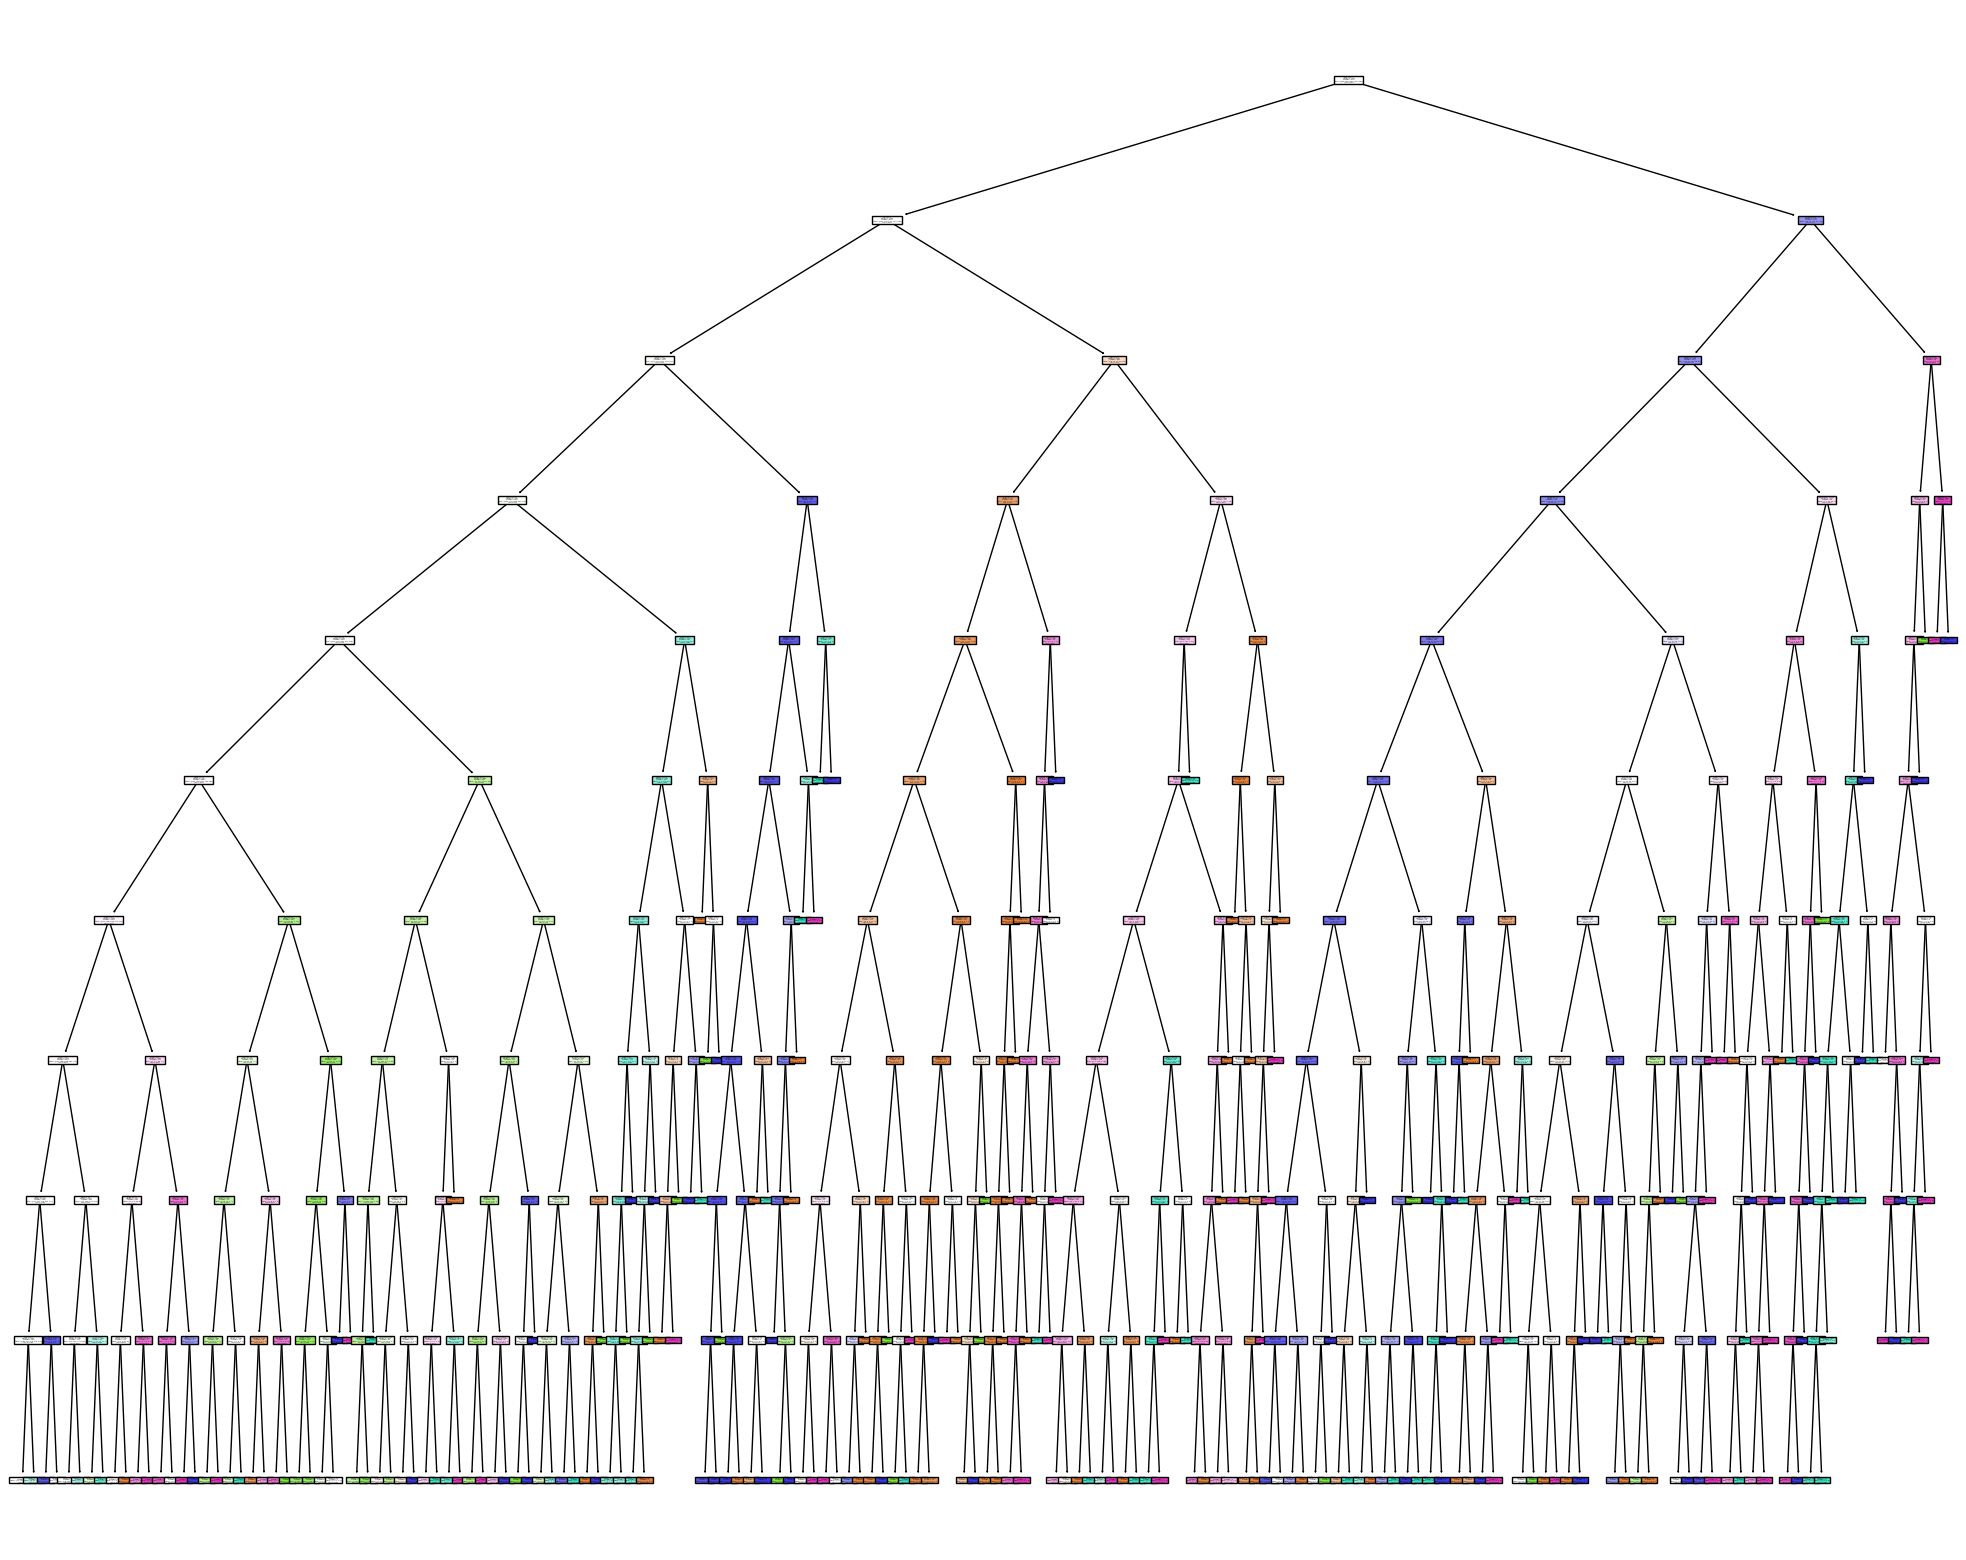

With max depth of 12 , the accuracy is 0.457713557161071


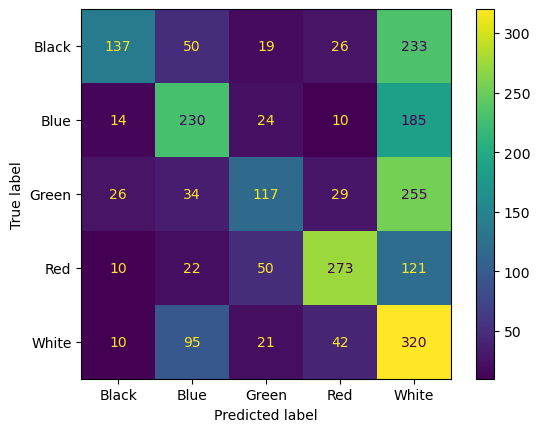

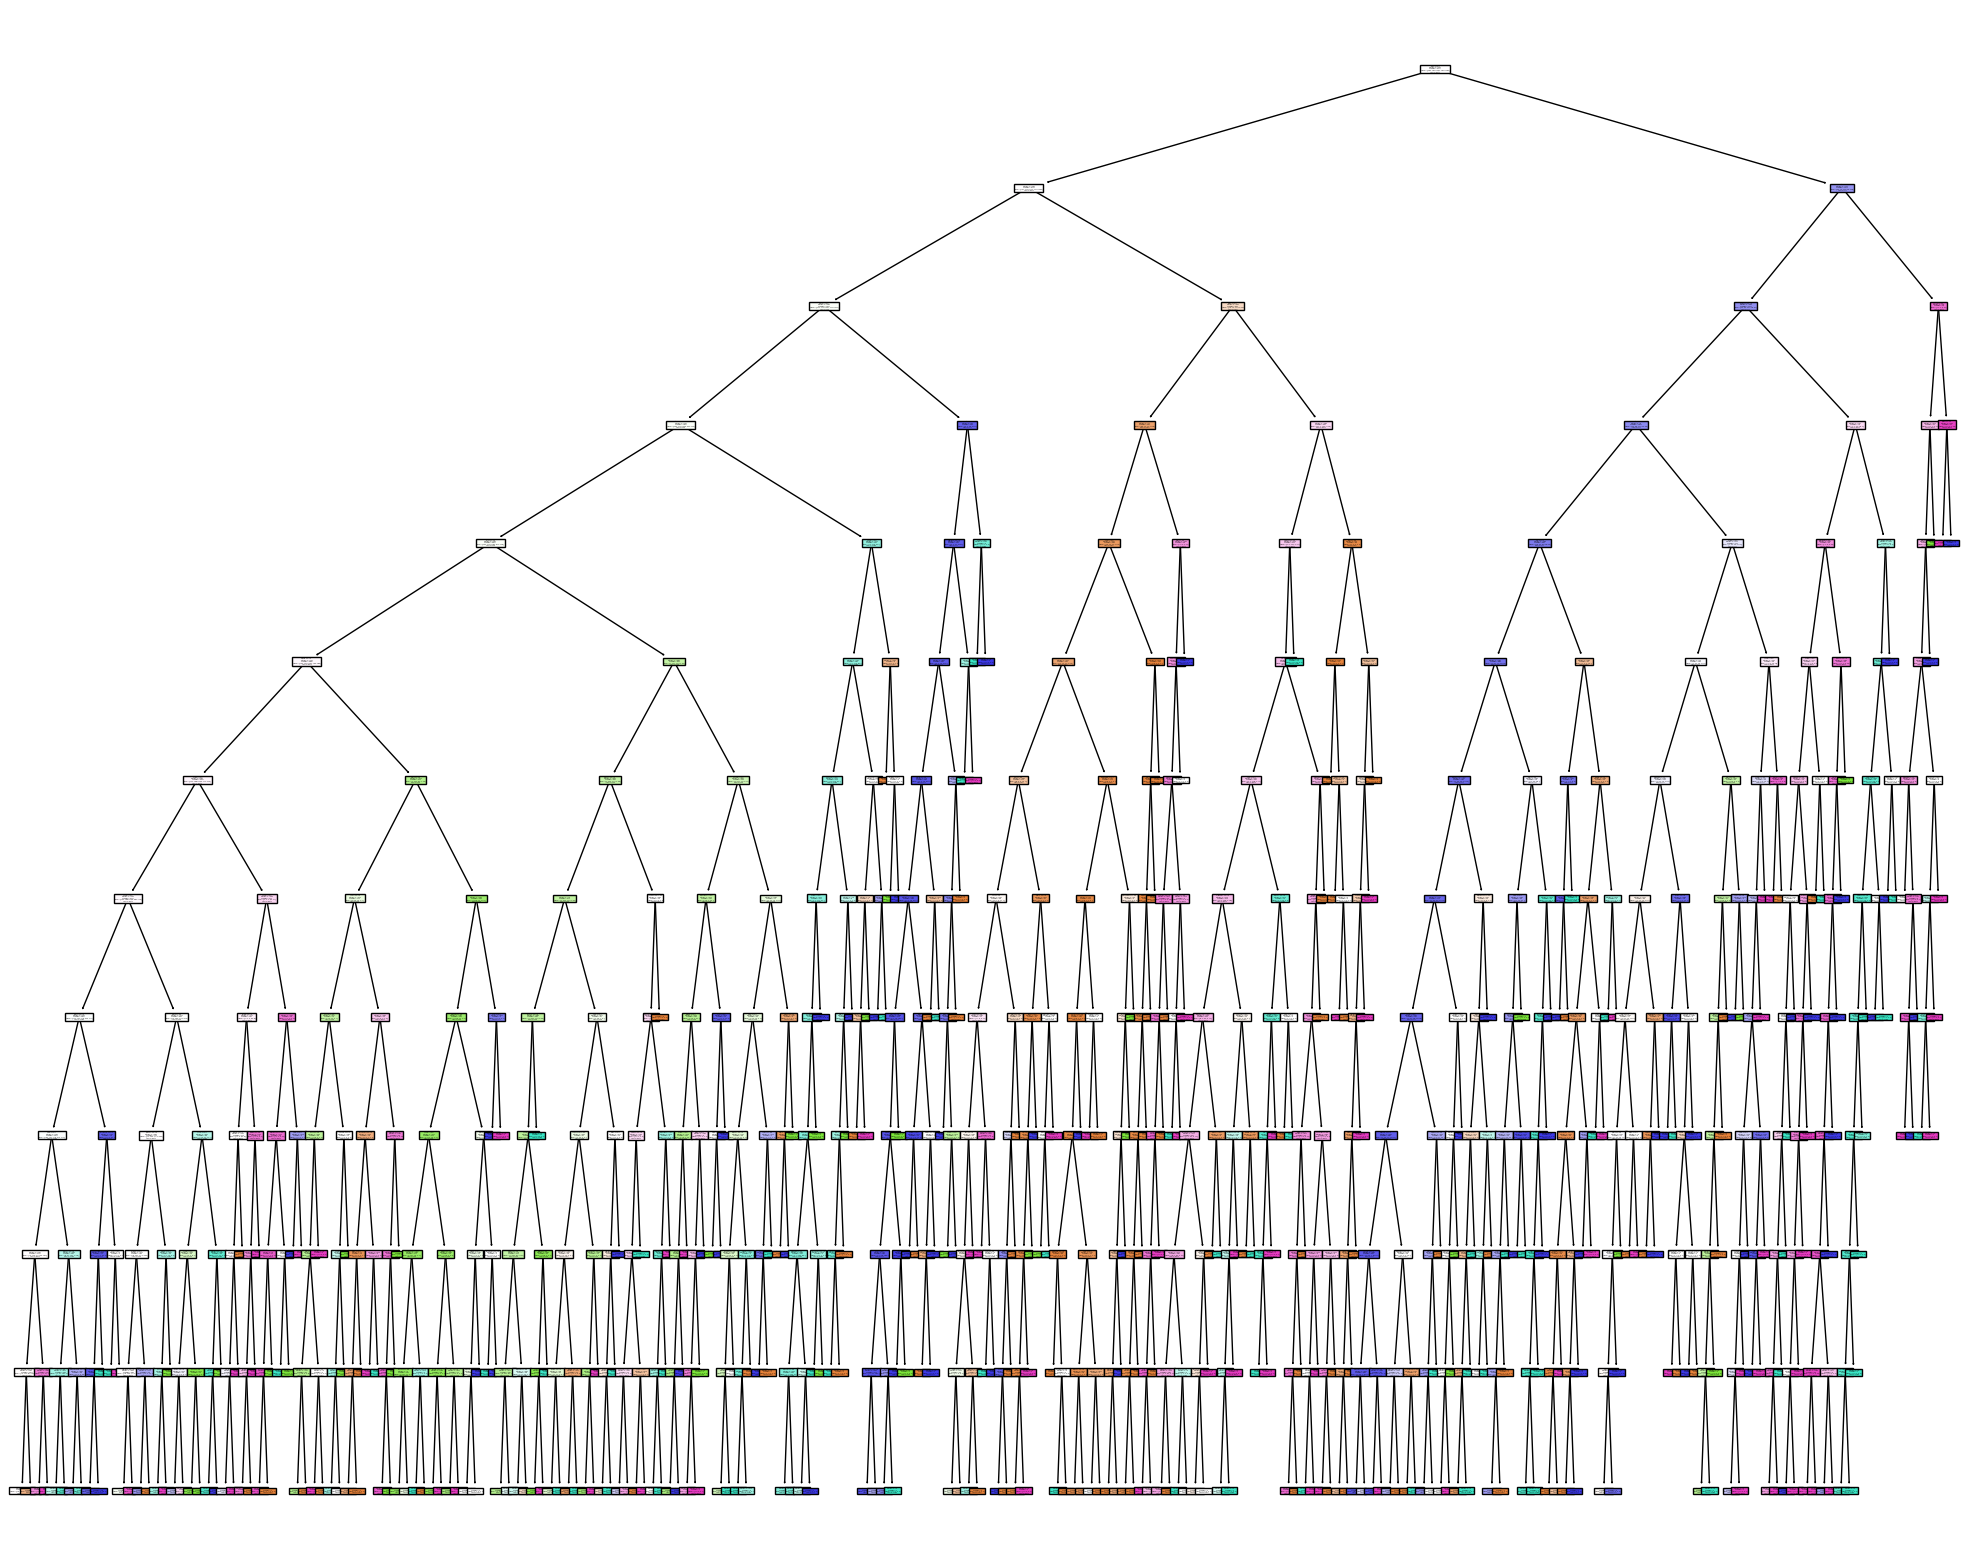

In [383]:
#Creating three models, with max_depth of 8, 10, 12. All other parameters are the same
#These decision trees use the English + MTG Stopwords CountVectorizer 350 data
for i in [8, 10, 12]:
    DT_SWCV = DecisionTreeClassifier(criterion = "entropy",
                                splitter = "best",
                                max_depth = i,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                min_weight_fraction_leaf = 0,
                                max_features = None,
                                random_state = 99,
                                max_leaf_nodes = None,
                                min_impurity_decrease = 0,
                                class_weight = None)
    #Using CV data
    DT_SWCV.fit(train_X_CV350sw, label_train_CV350sw)
    #Printing the model accuracy
    print("With max depth of", i, ", the accuracy is", DT_SWCV.score(test_X_CV350sw, label_test_CV350sw))
    #Creating the confusion matrix for the model
    y_pred = DT_SWCV.predict(test_X_CV350sw)
    cm=confusion_matrix(label_test_CV350sw, y_pred, labels=DT_SWCV.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=DT_SWCV.classes_)
    disp.plot()

    fig = plt.figure(figsize=(25,20))
    #Displaying the actual decision tree
    tree_SWCV = tree.plot_tree(DT_SWCV, 
                   feature_names=list(train_X_CV350sw.columns),  
                   class_names=DT_SWCV.classes_,
                   filled=True)
    plt.show()

With max depth of 8 , the accuracy is 0.42547770700636944


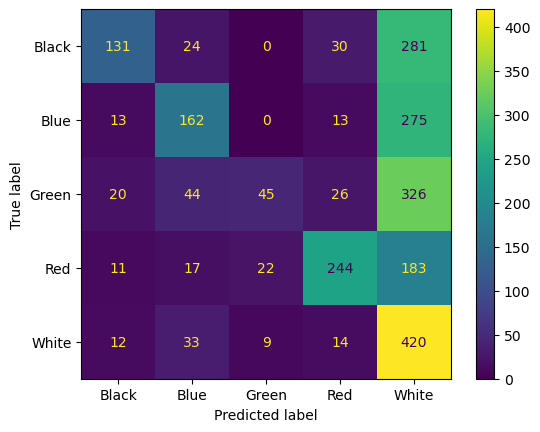

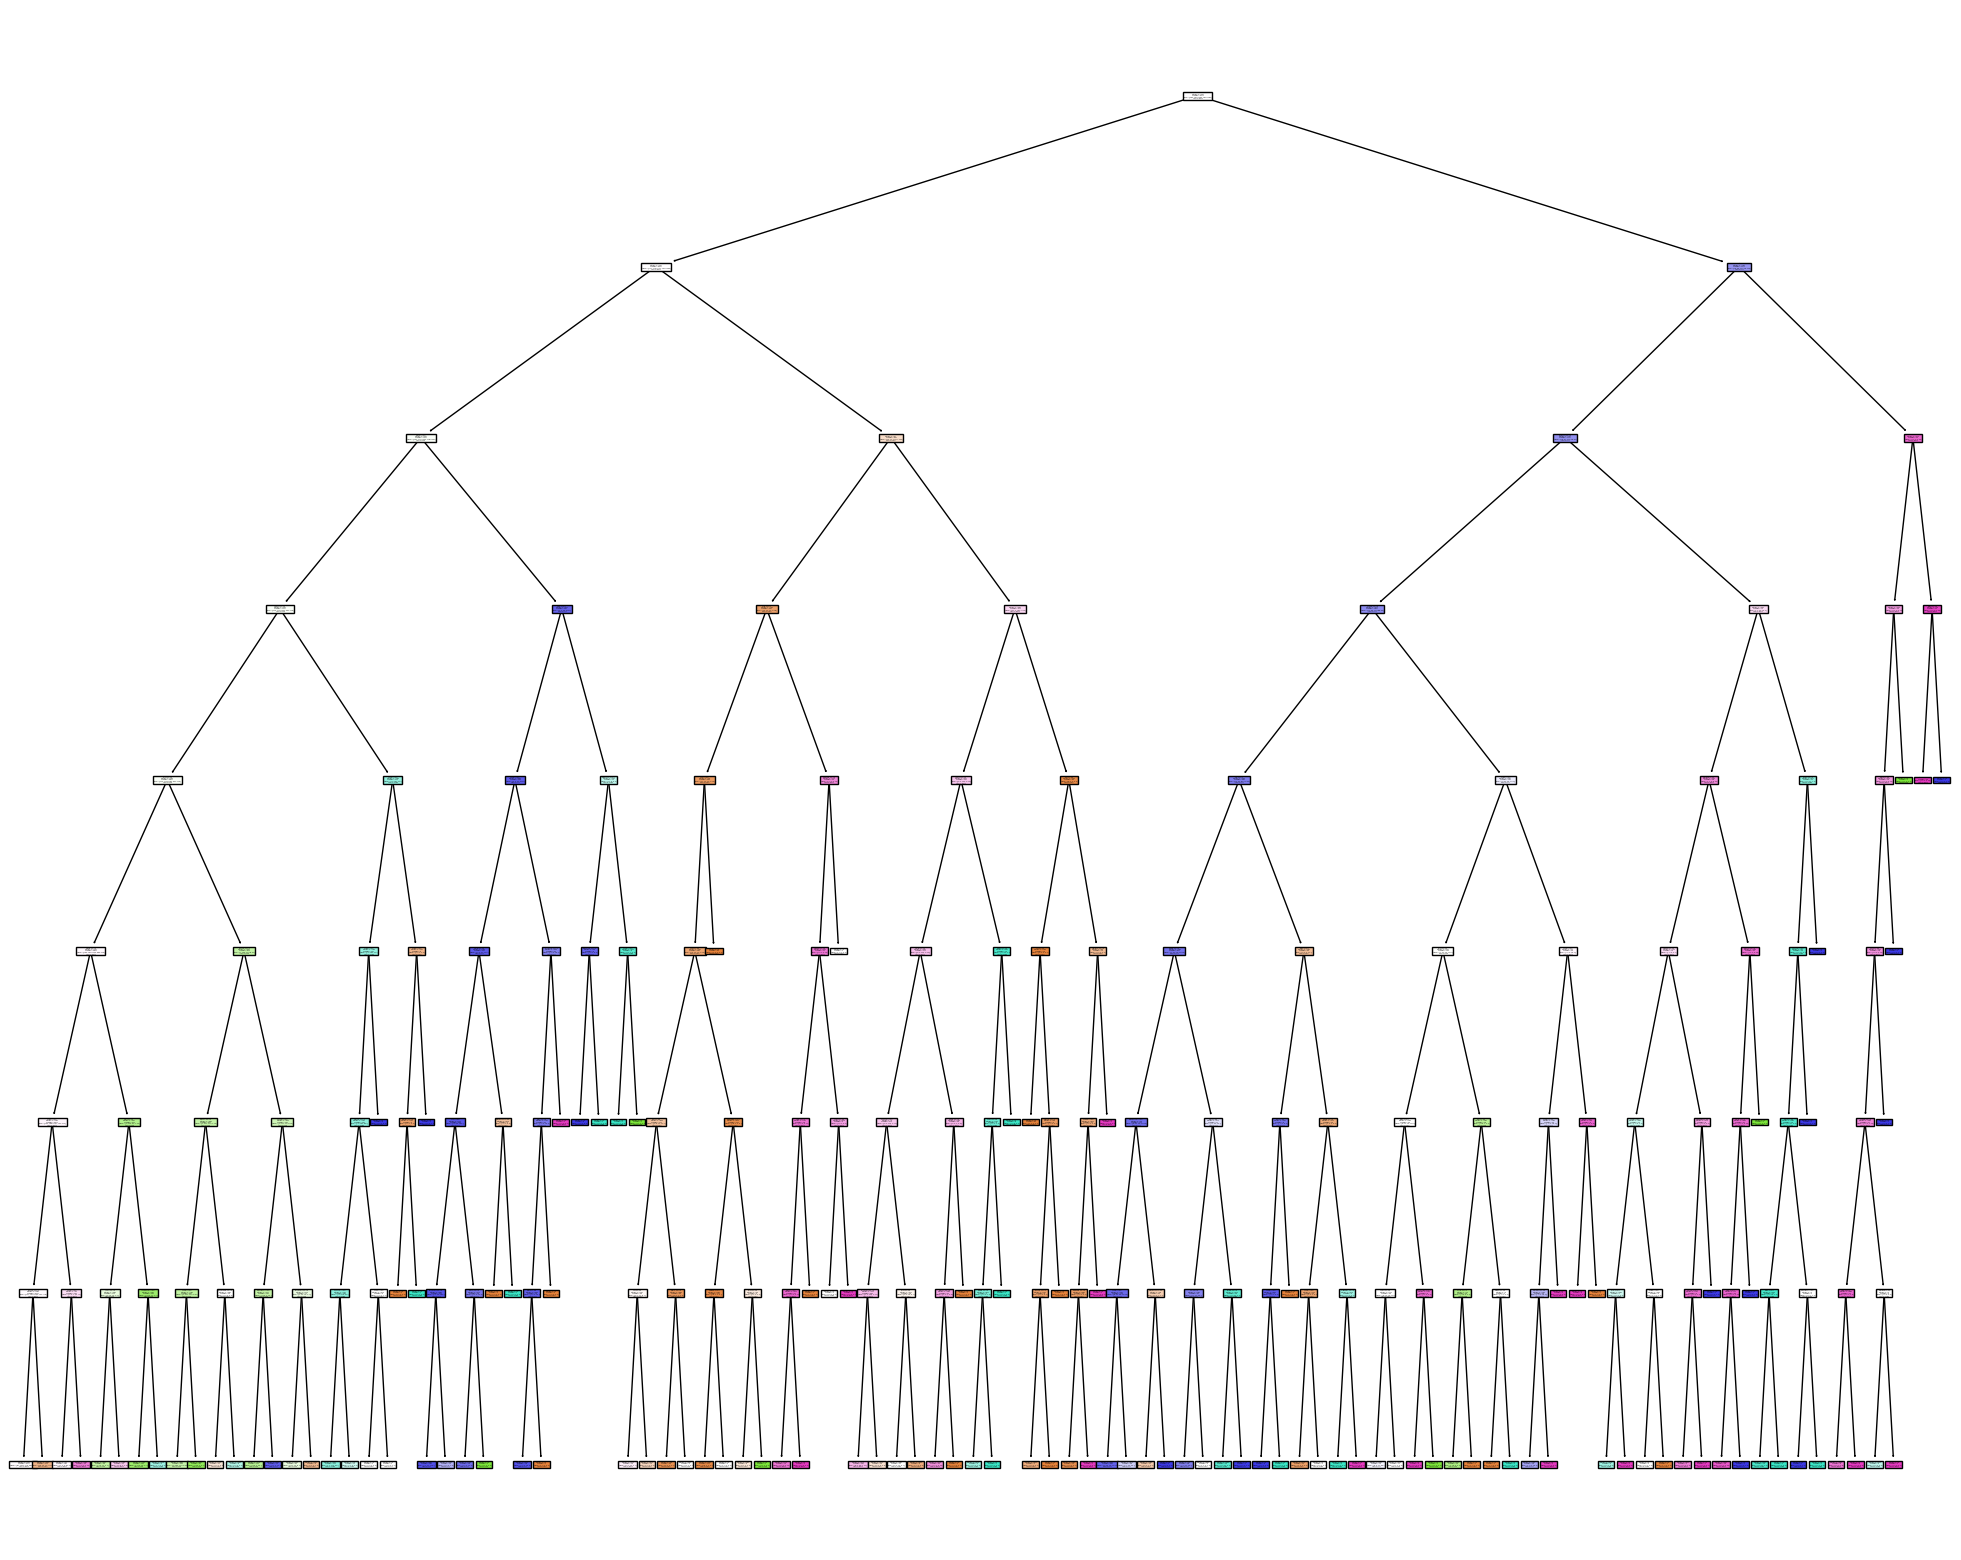

With max depth of 10 , the accuracy is 0.4526539278131635


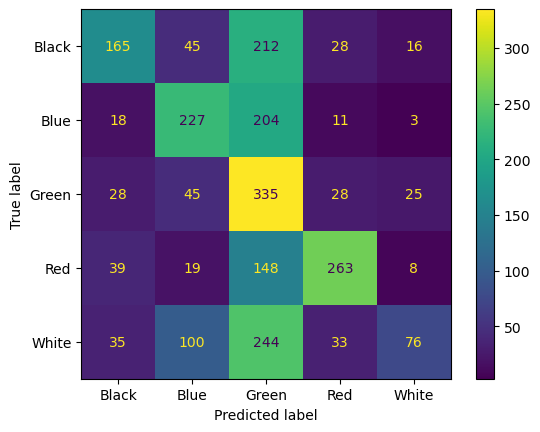

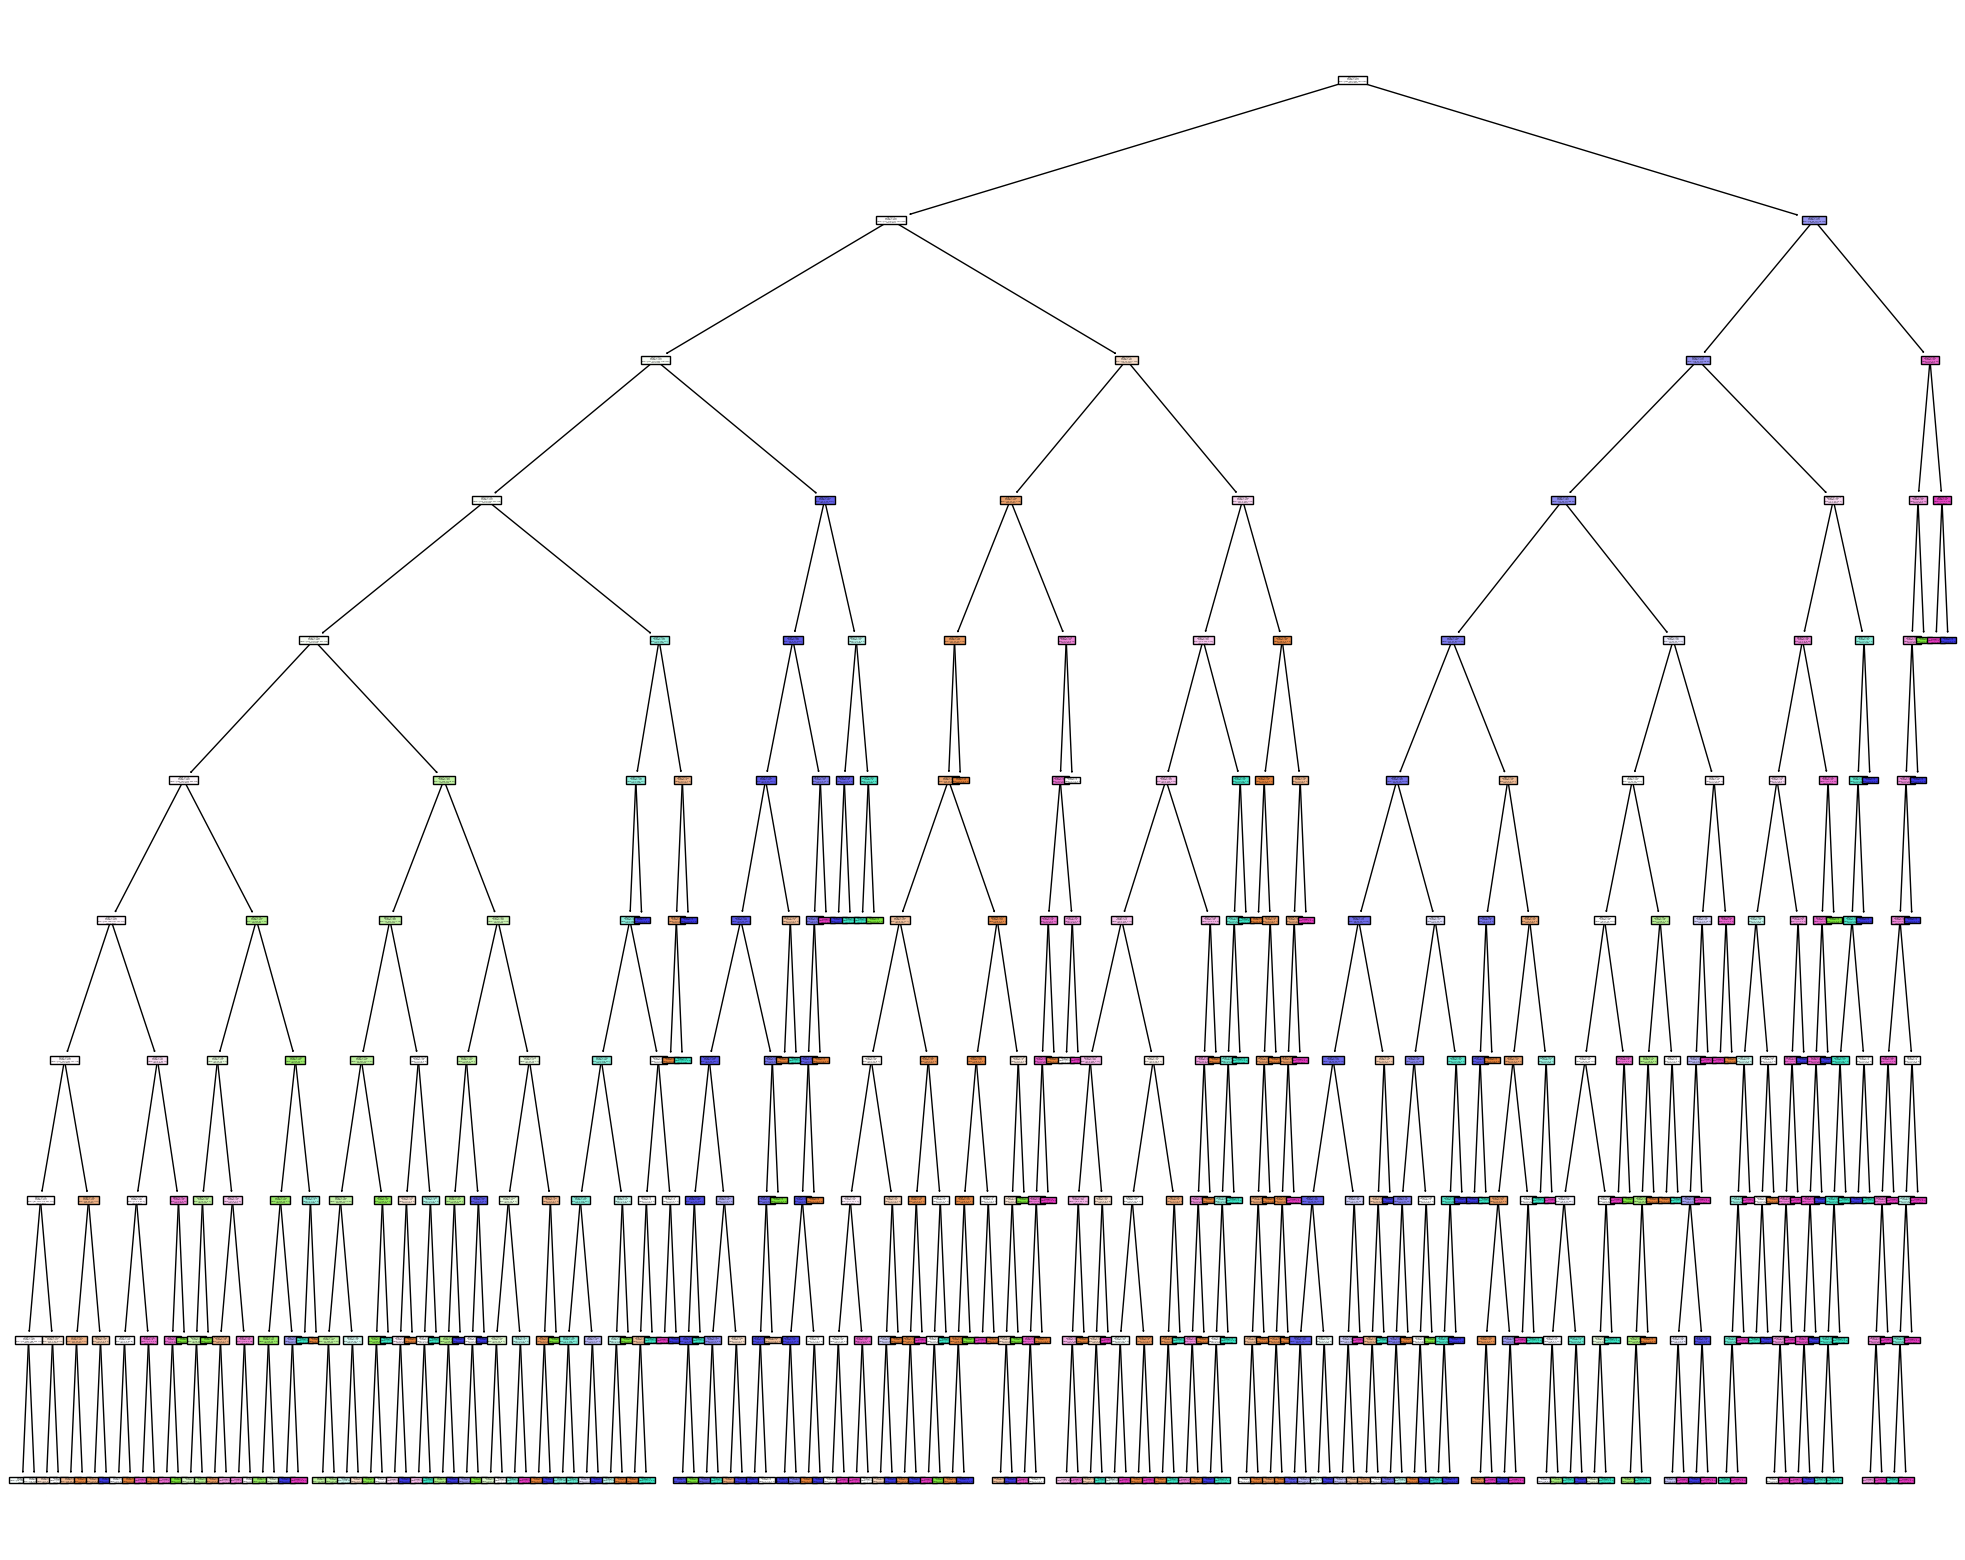

With max depth of 12 , the accuracy is 0.46284501061571126


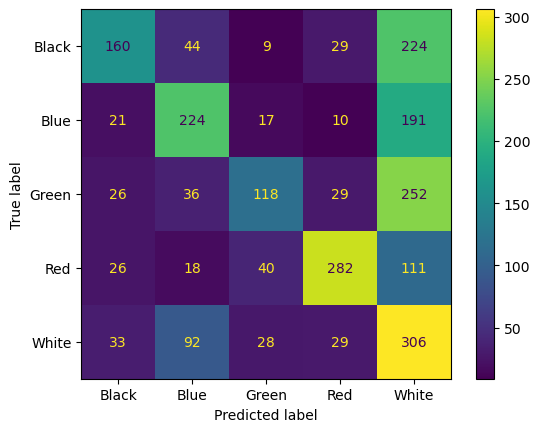

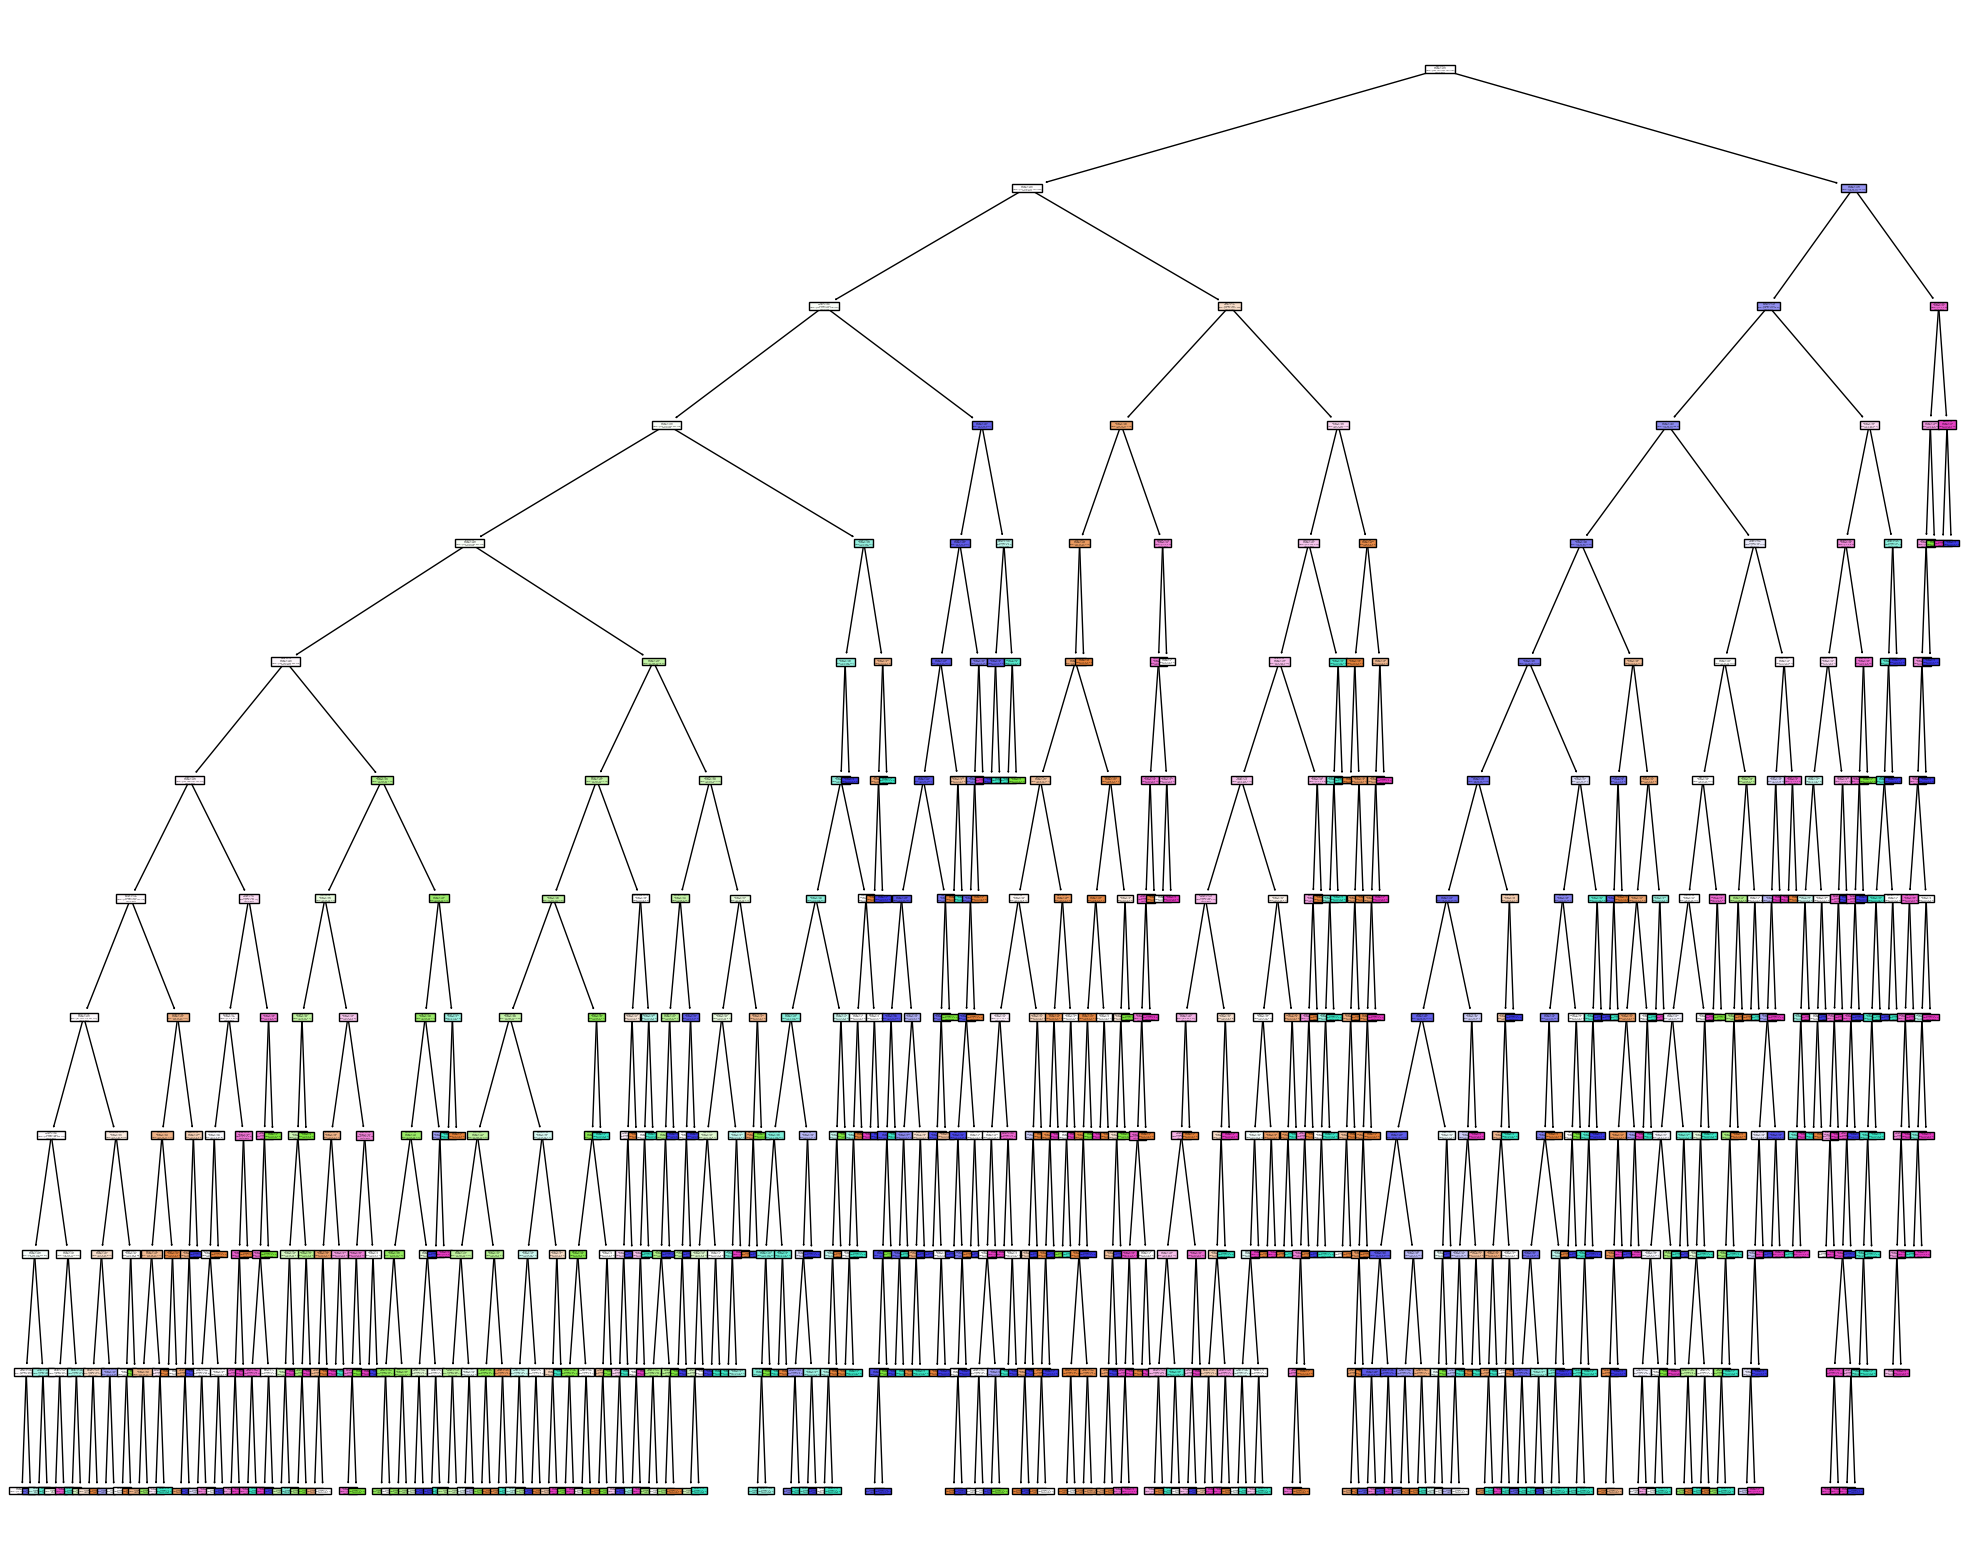

In [384]:
#Creating three models, with max_depth of 8, 10, 12. All other parameters are the same
#These decision trees use the English + MTG Stopwords CountVectorizer 350 binary data
for i in [8, 10, 12]:
    DT_SWCVb = DecisionTreeClassifier(criterion = "entropy",
                                splitter = "best",
                                max_depth = i,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                min_weight_fraction_leaf = 0,
                                max_features = None,
                                random_state = 99,
                                max_leaf_nodes = None,
                                min_impurity_decrease = 0,
                                class_weight = None)
    #Using CV data
    DT_SWCVb.fit(train_X_CV350bsw, label_train_CV350bsw)
    #Printing the model accuracy
    print("With max depth of", i, ", the accuracy is", DT_SWCVb.score(test_X_CV350bsw, label_test_CV350bsw))
    #Creating the confusion matrix for the model
    y_pred = DT_SWCVb.predict(test_X_CV350bsw)
    cm=confusion_matrix(label_test_CV350bsw, y_pred, labels=DT_SWCVb.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=DT_SWCVb.classes_)
    disp.plot()

    fig = plt.figure(figsize=(25,20))
    #Displaying the actual decision tree
    tree_SWCVb = tree.plot_tree(DT_SWCVb, 
                   feature_names=list(train_X_CV350bsw.columns),  
                   class_names=DT_SWCVb.classes_,
                   filled=True)
    plt.show()

With max depth of 8 , the accuracy is 0.4207394815129622


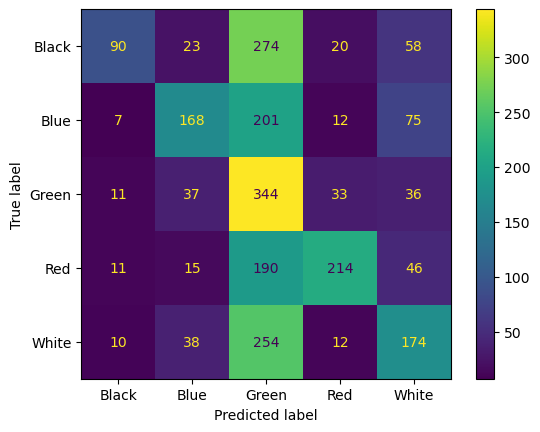

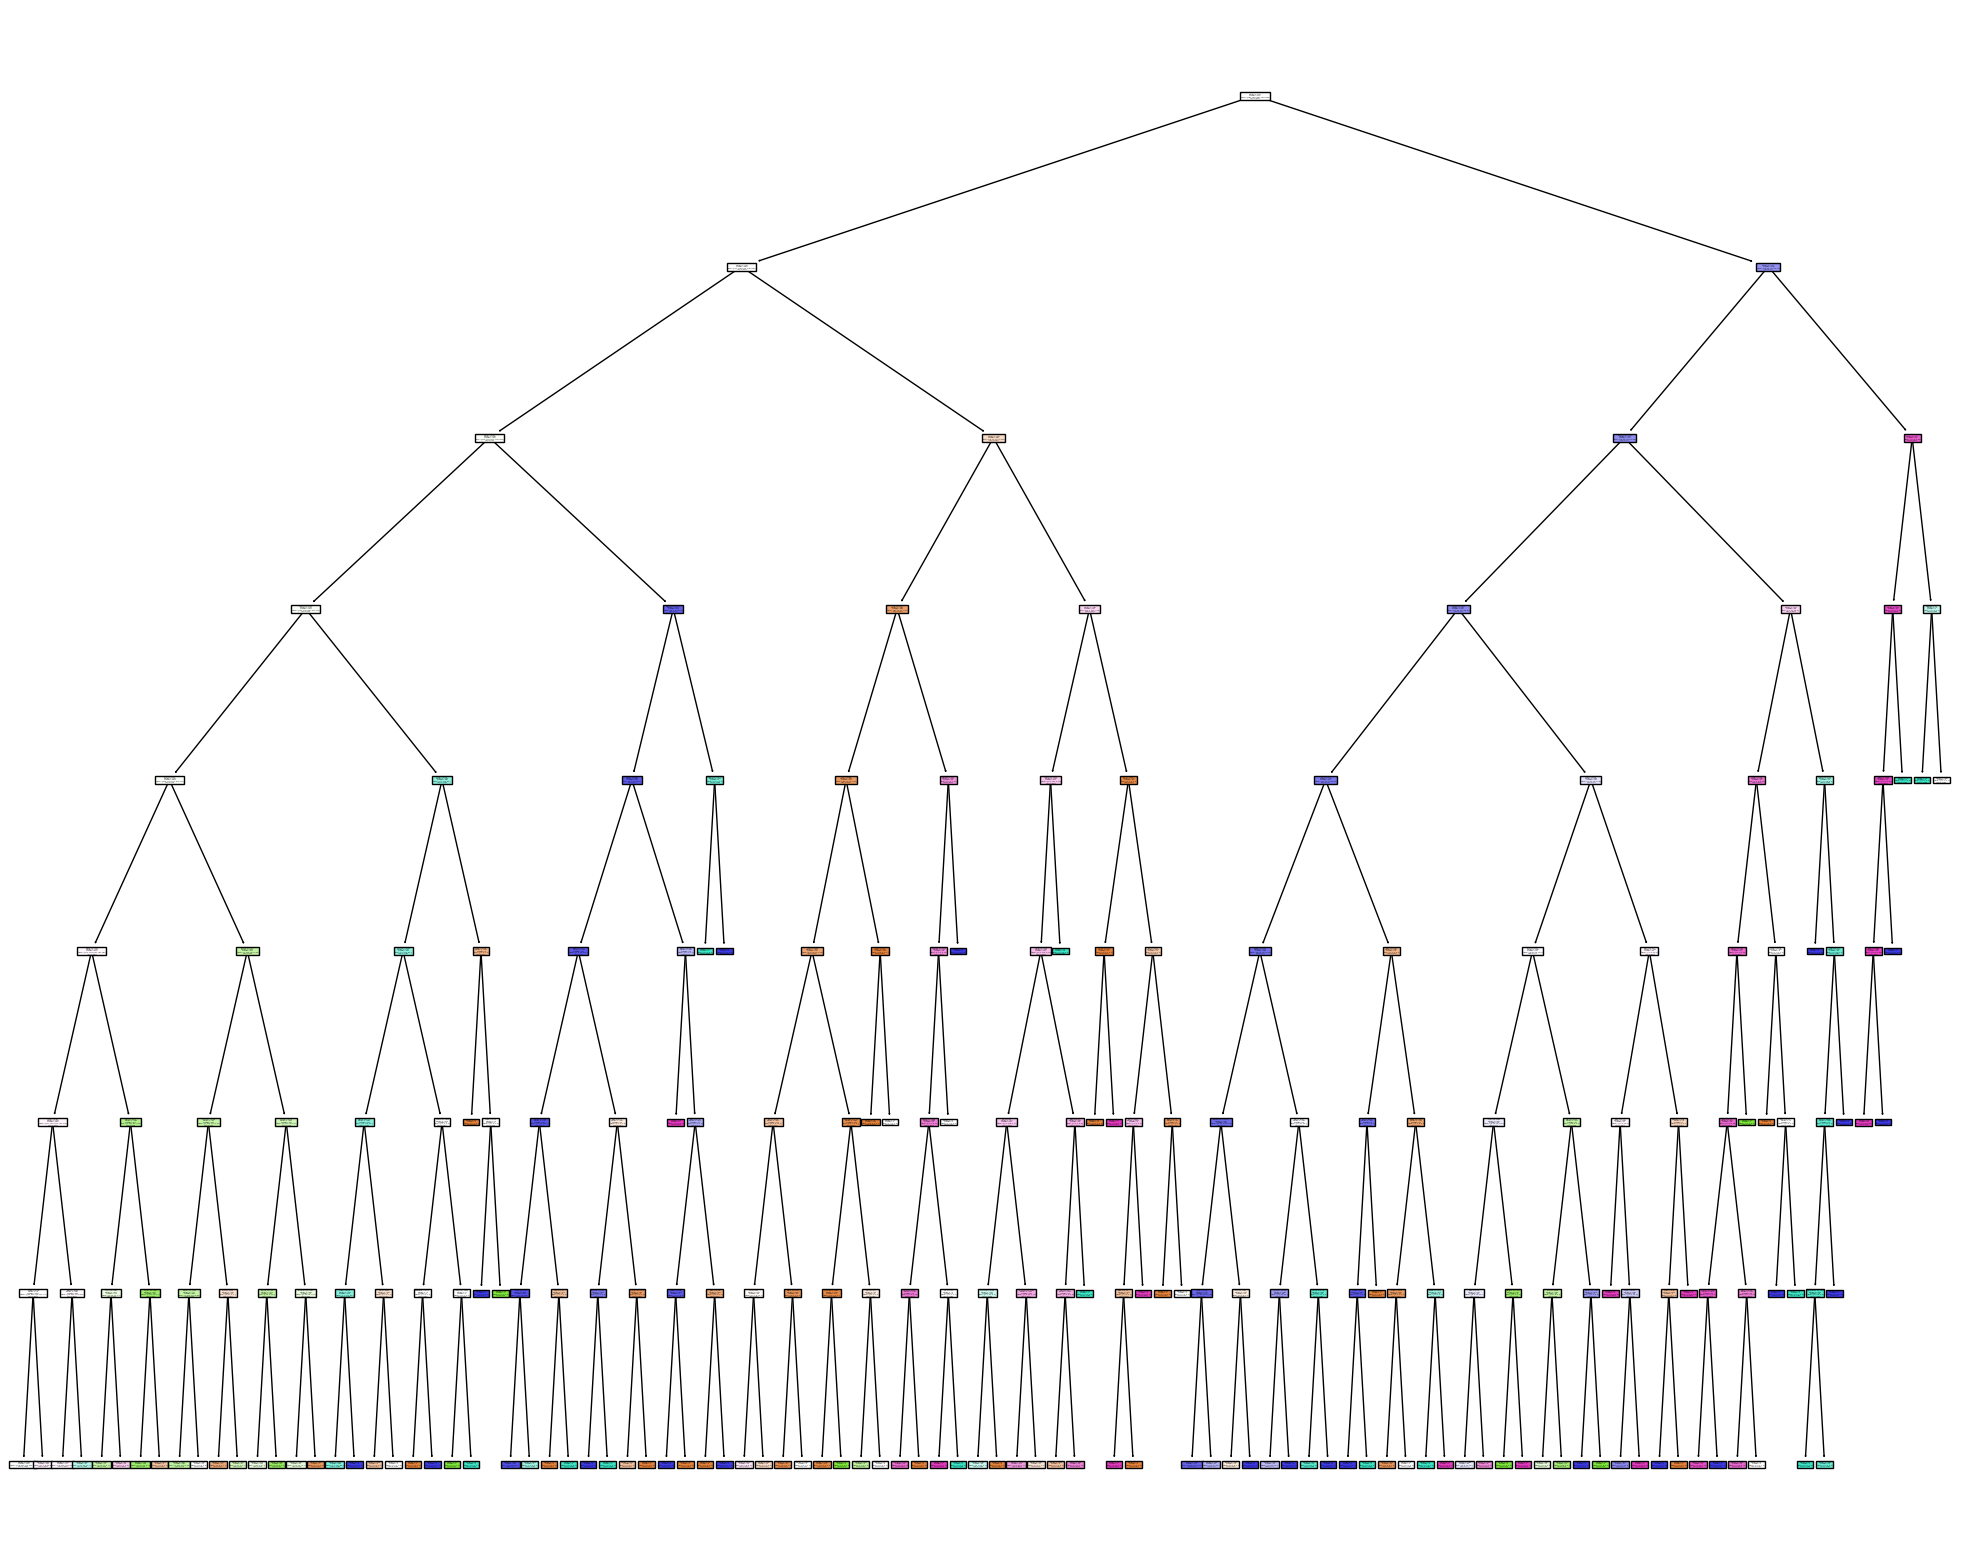

With max depth of 10 , the accuracy is 0.42966425839354017


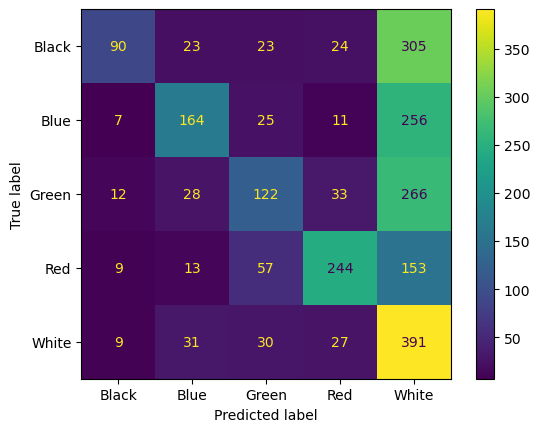

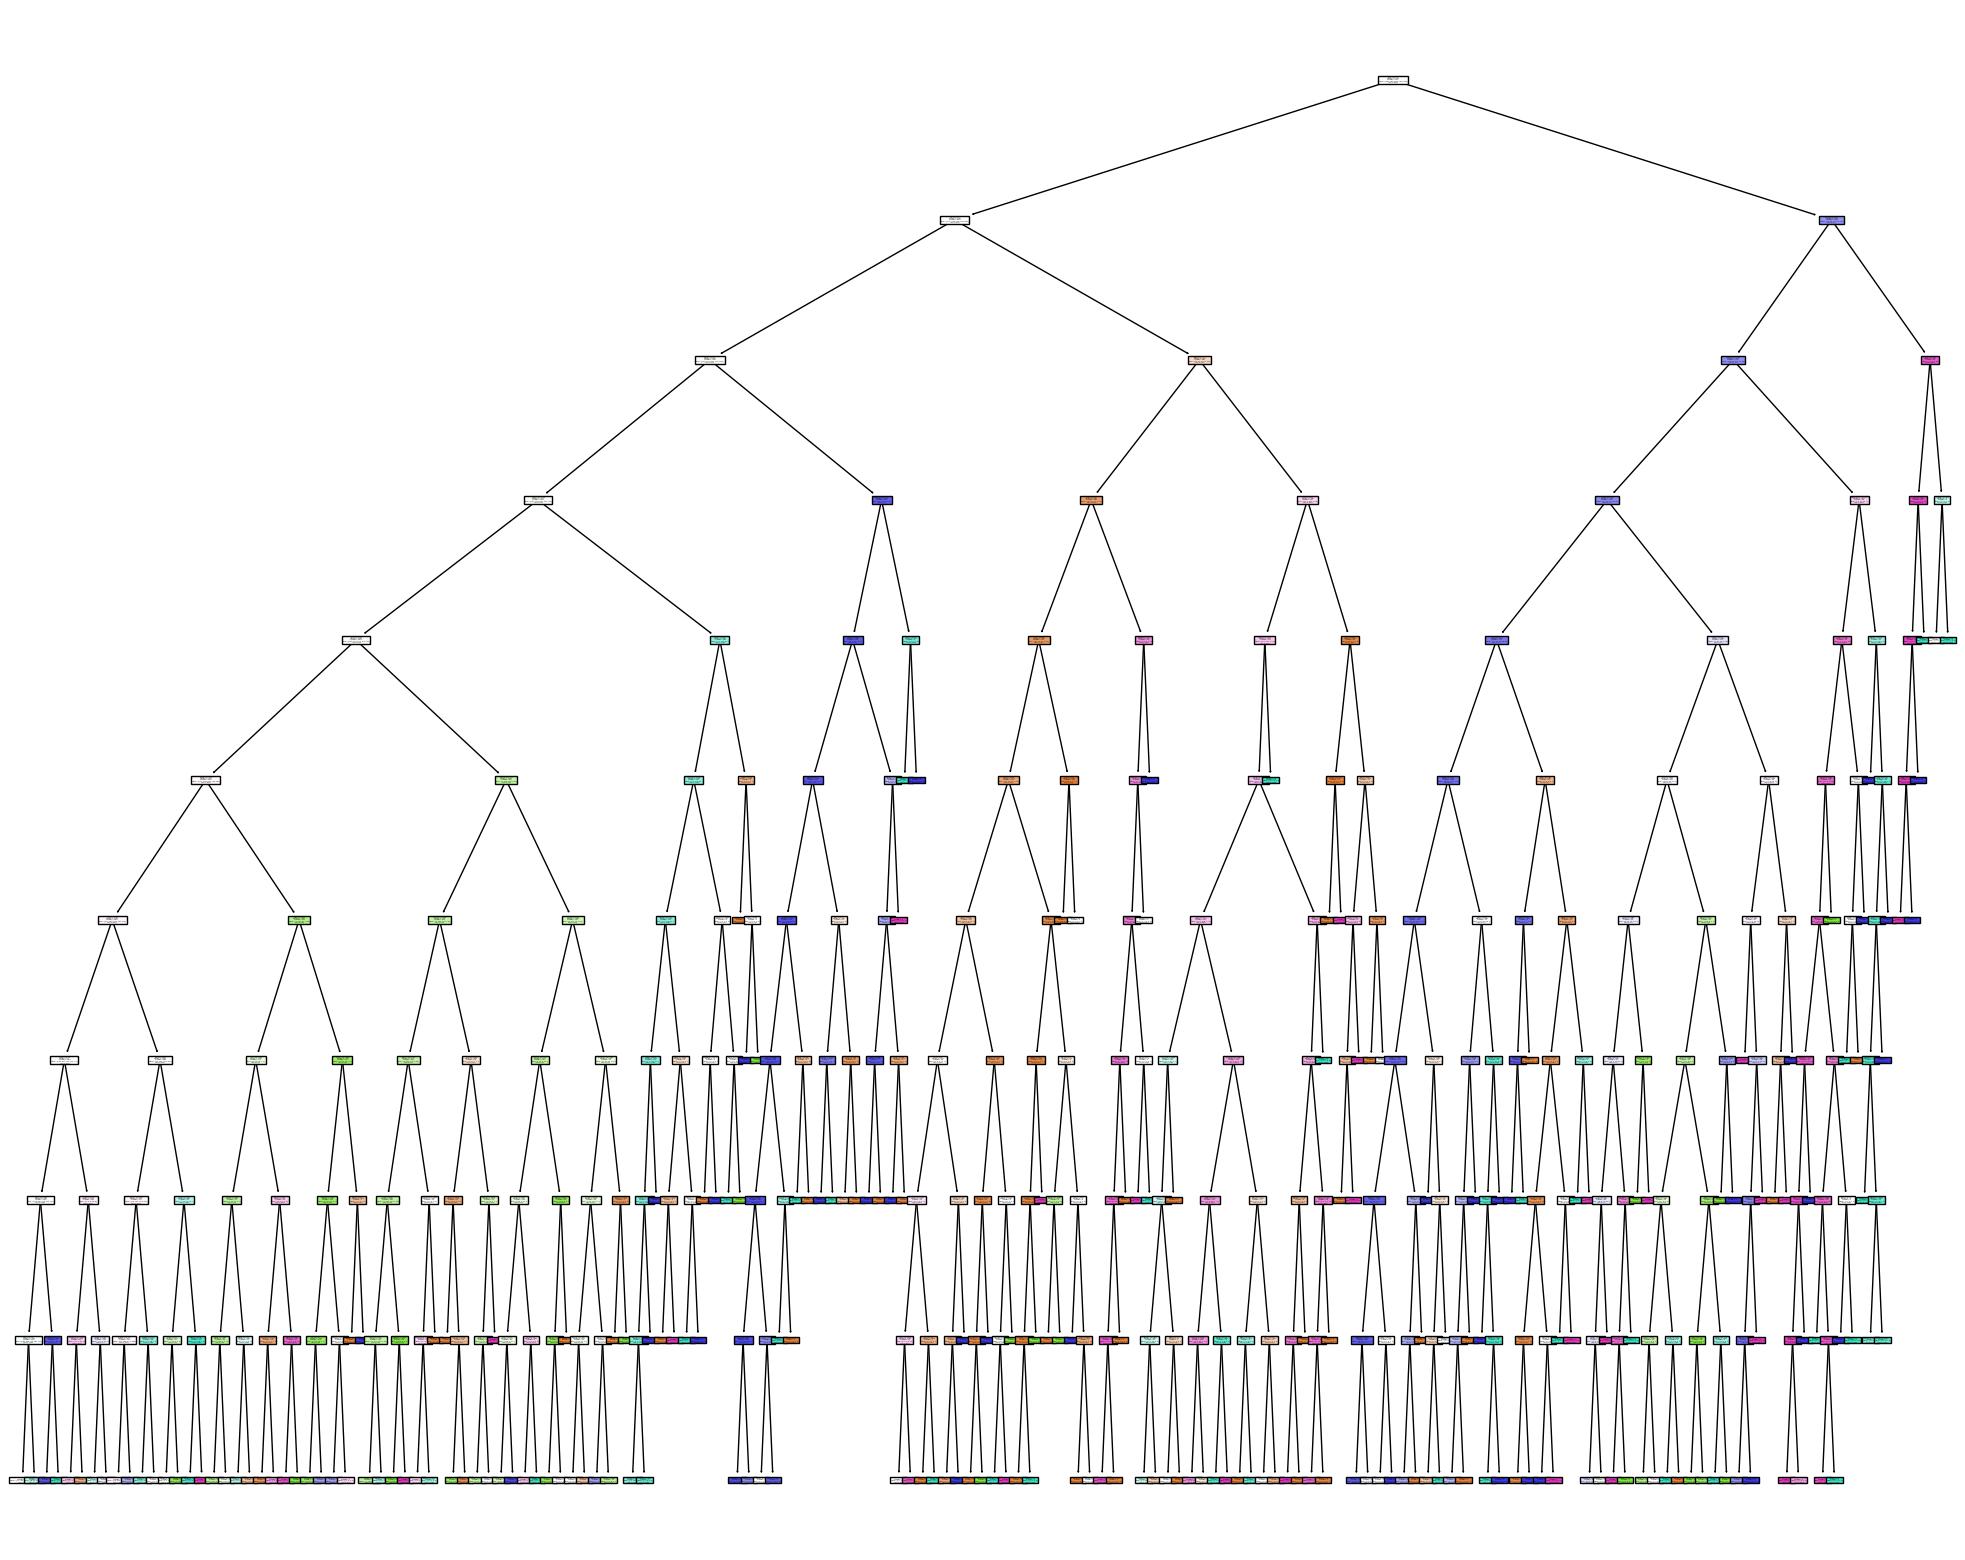

With max depth of 12 , the accuracy is 0.4492137696557586


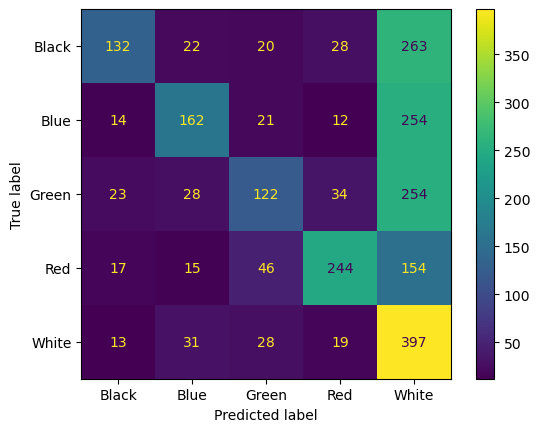

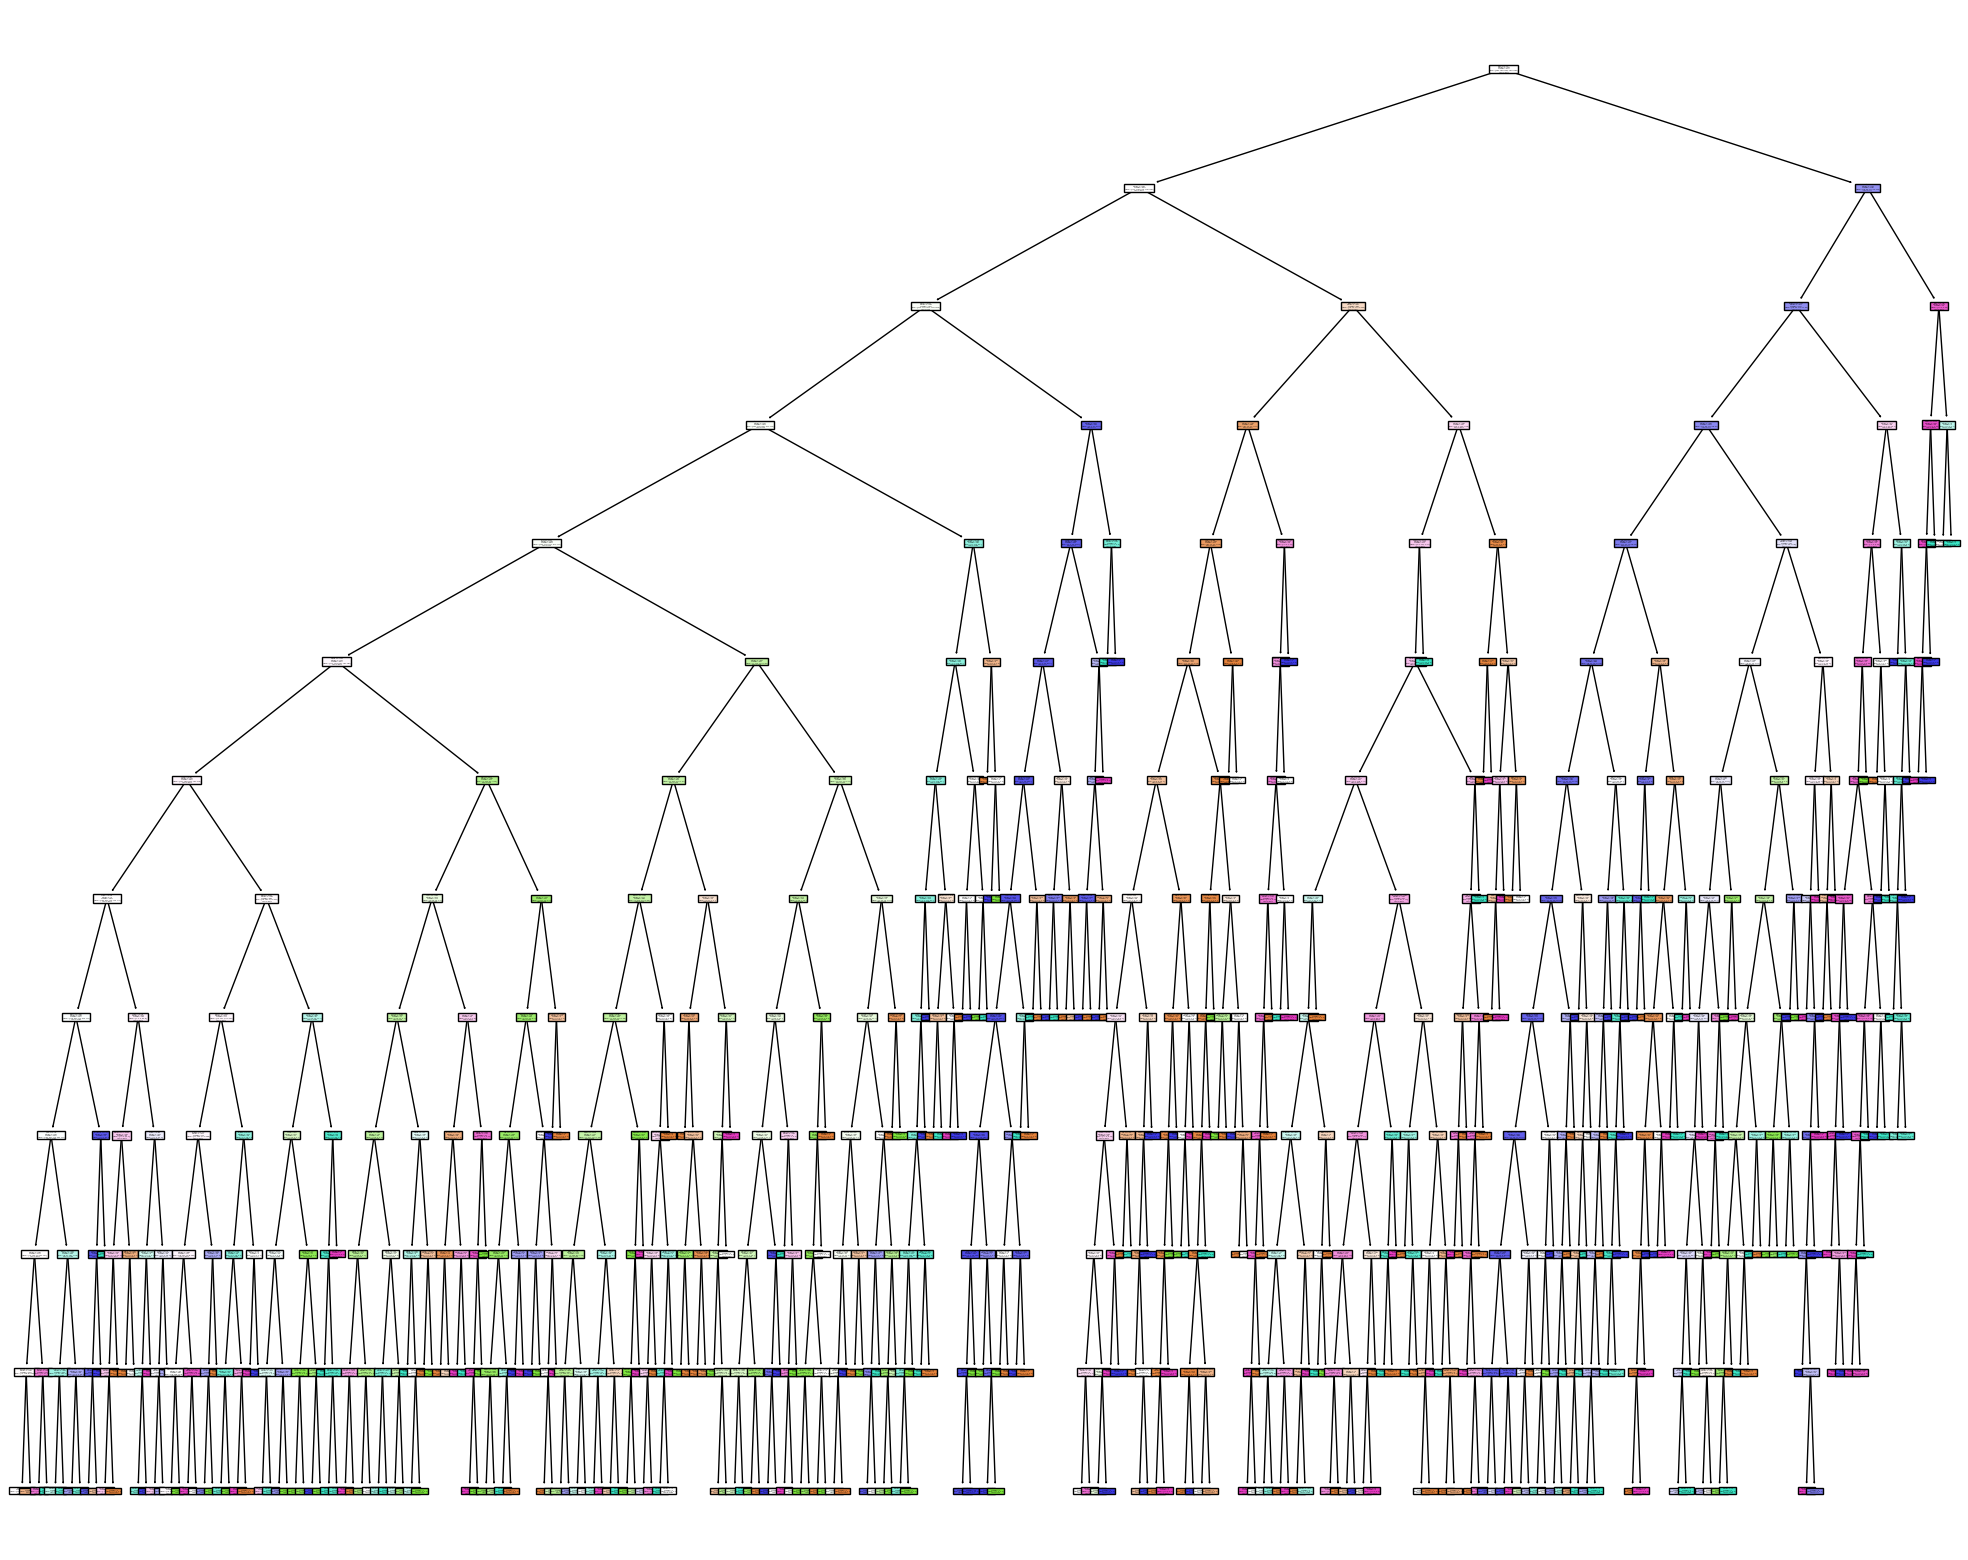

In [385]:
#Creating three models, with max_depth of 8, 10, 12. All other parameters are the same
#These decision trees use the English + MTG Stopwords CountVectorizer 350 data
for i in [8, 10, 12]:
    DT_SWTF = DecisionTreeClassifier(criterion = "entropy",
                                splitter = "best",
                                max_depth = i,
                                min_samples_split = 2,
                                min_samples_leaf = 1,
                                min_weight_fraction_leaf = 0,
                                max_features = None,
                                random_state = 99,
                                max_leaf_nodes = None,
                                min_impurity_decrease = 0,
                                class_weight = None)
    #Using CV data
    DT_SWTF.fit(train_X_TF350sw, label_train_TF350sw)
    #Printing the model accuracy
    print("With max depth of", i, ", the accuracy is", DT_SWTF.score(test_X_TF350sw, label_test_TF350sw))
    #Creating the confusion matrix for the model
    y_pred = DT_SWTF.predict(test_X_TF350sw)
    cm=confusion_matrix(label_test_TF350sw, y_pred, labels=DT_SWTF.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=DT_SWTF.classes_)
    disp.plot()

    fig = plt.figure(figsize=(25,20))
    #Displaying the actual decision tree
    tree_SWCV = tree.plot_tree(DT_SWTF, 
                   feature_names=list(train_X_TF350sw.columns),  
                   class_names=DT_SWTF.classes_,
                   filled=True)
    plt.show()

In [335]:
## Support Vector Machines ##

In [336]:
# Using CountVectorizer with least number of features due to processing times

In [386]:
#Linear Kernel
LinSVM = svm.SVC(kernel = "linear")

In [387]:
#Training the model on the vectorized data
LinSVM.fit(train_X_CV250sw, label_train_CV250sw)

SVC(kernel='linear')

In [388]:
#Test the model against the testing data
LinSVM.score(test_X_CV250sw, label_test_CV250sw)

0.610046828437633

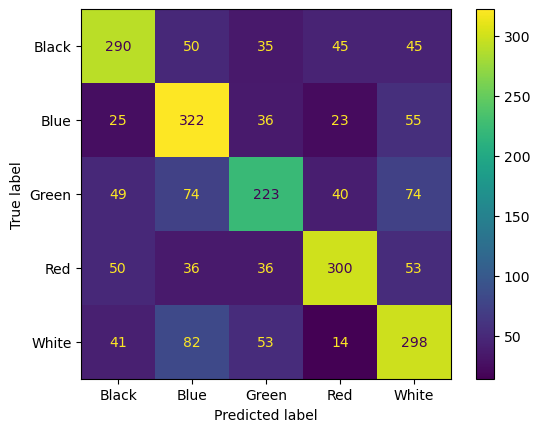

In [389]:
#Create confusion matrix of results
y_pred_LinSVM = LinSVM.predict(test_X_CV250sw)
cm_LinSVM=confusion_matrix(label_test_CV250sw, y_pred_LinSVM, labels=LinSVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LinSVM,
                              display_labels=LinSVM.classes_)
disp.plot()
plt.show()

In [390]:
#Polynomial Kernel
PolySVM = svm.SVC(kernel = "poly")

In [391]:
#Training the model on the vectorized data
PolySVM.fit(train_X_CV250sw, label_train_CV250sw)

SVC(kernel='poly')

In [392]:
#Test the model against the testing data
PolySVM.score(test_X_CV250sw, label_test_CV250sw)

0.6062154108131119

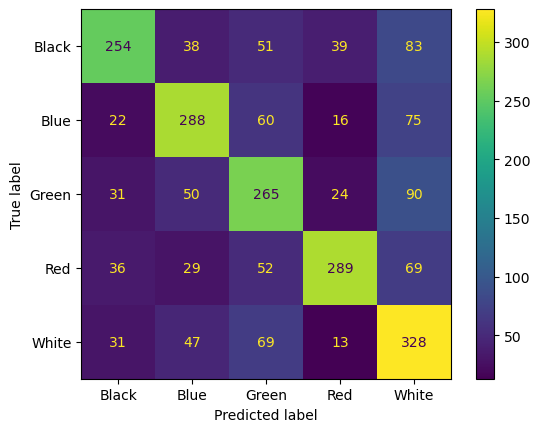

In [393]:
#Create confusion matrix of results
y_pred_PolySVM = PolySVM.predict(test_X_CV250sw)
cm_PolySVM=confusion_matrix(label_test_CV250sw, y_pred_PolySVM, labels=PolySVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_PolySVM,
                              display_labels=PolySVM.classes_)
disp.plot()
plt.show()

In [394]:
#RBF Kernel
RBFSVM = svm.SVC(kernel = "rbf")

In [395]:
#Training the model on the vectorized data
RBFSVM.fit(train_X_CV250sw, label_train_CV250sw)

SVC()

In [396]:
#Test the model against the testing data
RBFSVM.score(test_X_CV250sw, label_test_CV250sw)

0.6326096211153682

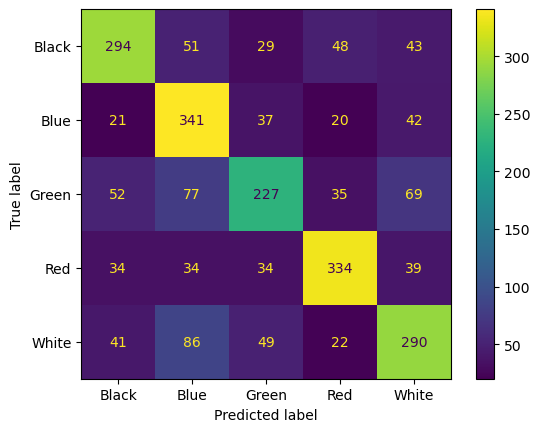

In [397]:
#Create confusion matrix of results
y_pred_RBFSVM = RBFSVM.predict(test_X_CV250sw)
cm_RBFSVM=confusion_matrix(label_test_CV250sw, y_pred_RBFSVM, labels=RBFSVM.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RBFSVM,
                              display_labels=RBFSVM.classes_)
disp.plot()
plt.show()

In [336]:
# Using CountVectorizer Binary with least number of features due to processing times

In [398]:
#Linear Kernel
LinSVMb = svm.SVC(kernel = "linear")

In [399]:
#Training the model on the vectorized data
LinSVMb.fit(train_X_CV250bsw, label_train_CV250bsw)

SVC(kernel='linear')

In [400]:
#Test the model against the testing data
LinSVMb.score(test_X_CV250bsw, label_test_CV250bsw)

0.6051063829787234

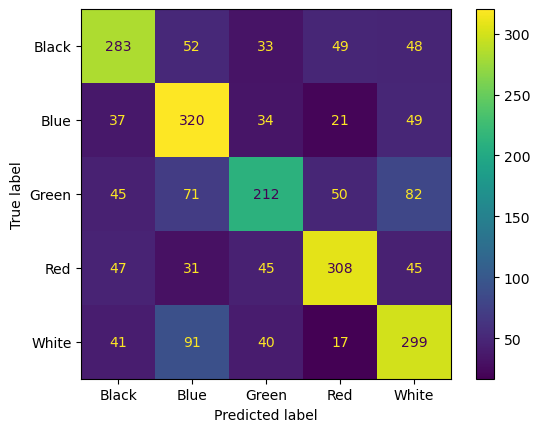

In [402]:
#Create confusion matrix of results
y_pred_LinSVMb = LinSVMb.predict(test_X_CV250bsw)
cm_LinSVMb=confusion_matrix(label_test_CV250bsw, y_pred_LinSVMb, labels=LinSVMb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LinSVMb,
                              display_labels=LinSVMb.classes_)
disp.plot()
plt.show()

In [403]:
#Polynomial Kernel
PolySVMb = svm.SVC(kernel = "poly")

In [404]:
#Training the model on the vectorized data
PolySVMb.fit(train_X_CV250bsw, label_train_CV250bsw)

SVC(kernel='poly')

In [405]:
#Test the model against the testing data
PolySVMb.score(test_X_CV250bsw, label_test_CV250bsw)

0.6153191489361702

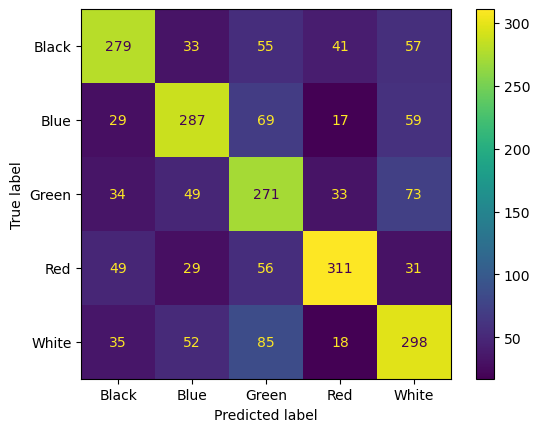

In [406]:
#Create confusion matrix of results
y_pred_PolySVMb = PolySVMb.predict(test_X_CV250bsw)
cm_PolySVMb=confusion_matrix(label_test_CV250bsw, y_pred_PolySVMb, labels=PolySVMb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_PolySVMb,
                              display_labels=PolySVMb.classes_)
disp.plot()
plt.show()

In [407]:
#RBF Kernel
RBFSVMb = svm.SVC(kernel = "rbf")

In [408]:
#Training the model on the vectorized data
RBFSVMb.fit(train_X_CV250bsw, label_train_CV250bsw)

SVC()

In [409]:
#Test the model against the testing data
RBFSVMb.score(test_X_CV250bsw, label_test_CV250bsw)

0.642127659574468

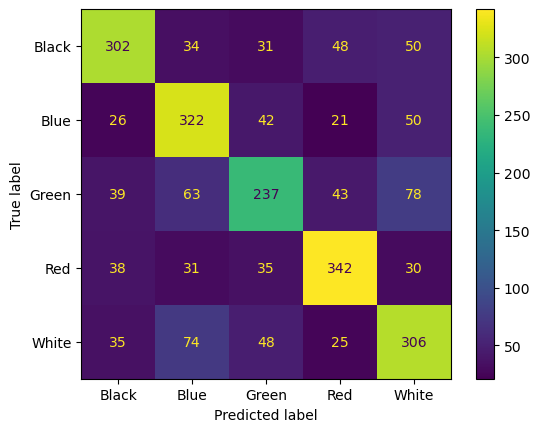

In [410]:
#Create confusion matrix of results
y_pred_RBFSVMb = RBFSVMb.predict(test_X_CV250bsw)
cm_RBFSVMb=confusion_matrix(label_test_CV250bsw, y_pred_RBFSVMb, labels=RBFSVMb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RBFSVMb,
                              display_labels=RBFSVMb.classes_)
disp.plot()
plt.show()

In [336]:
# Using TFIDFVectorizer with least number of features due to processing times

In [411]:
#Linear Kernel
LinSVMTF = svm.SVC(kernel = "linear")

In [412]:
#Training the model on the vectorized data
LinSVMTF.fit(train_X_TF250sw, label_train_TF250sw)

SVC(kernel='linear')

In [413]:
#Test the model against the testing data
LinSVMTF.score(test_X_TF250sw, label_test_TF250sw)

0.6057896977437207

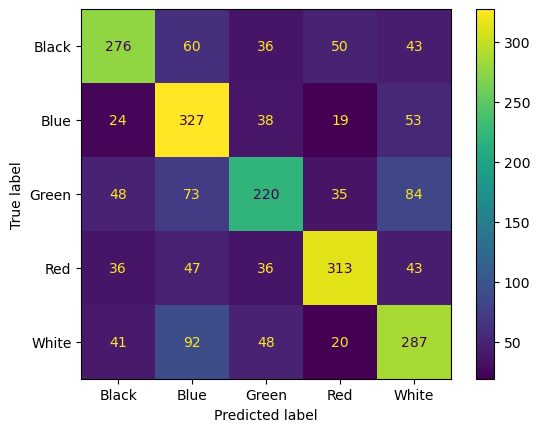

In [414]:
#Create confusion matrix of results
y_pred_LinSVMTF = LinSVMTF.predict(test_X_TF250sw)
cm_LinSVMTF=confusion_matrix(label_test_TF250sw, y_pred_LinSVMTF, labels=LinSVMTF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_LinSVMTF,
                              display_labels=LinSVMTF.classes_)
disp.plot()
plt.show()

In [415]:
#Polynomial Kernel
PolySVMTF = svm.SVC(kernel = "poly")

In [416]:
#Training the model on the vectorized data
PolySVMTF.fit(train_X_TF250sw, label_train_TF250sw)

SVC(kernel='poly')

In [417]:
#Test the model against the testing data
PolySVMTF.score(test_X_TF250sw, label_test_TF250sw)

0.6138782460621541

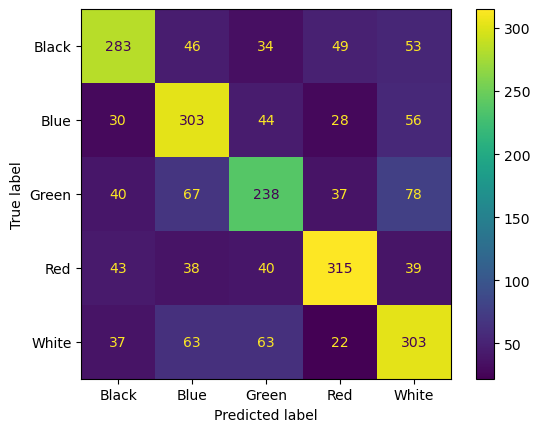

In [418]:
#Create confusion matrix of results
y_pred_PolySVMTF = PolySVMTF.predict(test_X_TF250sw)
cm_PolySVMTF=confusion_matrix(label_test_TF250sw, y_pred_PolySVMTF, labels=PolySVMTF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_PolySVMTF,
                              display_labels=PolySVMTF.classes_)
disp.plot()
plt.show()

In [419]:
#RBF Kernel
RBFSVMTF = svm.SVC(kernel = "rbf")

In [420]:
#Training the model on the vectorized data
RBFSVMTF.fit(train_X_TF250sw, label_train_TF250sw)

SVC()

In [421]:
#Test the model against the testing data
RBFSVMTF.score(test_X_TF250sw, label_test_TF250sw)

0.6364410387398893

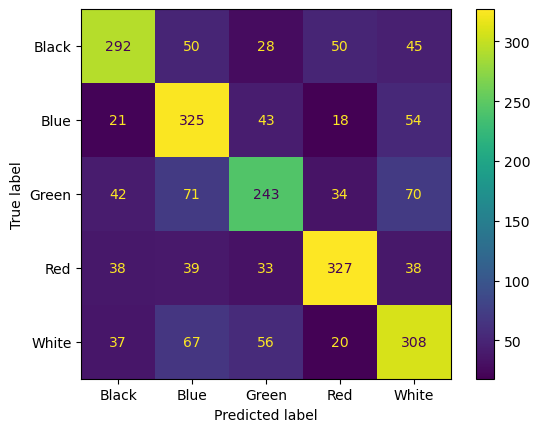

In [422]:
#Create confusion matrix of results
y_pred_RBFSVMTF = RBFSVMTF.predict(test_X_TF250sw)
cm_RBFSVMTF=confusion_matrix(label_test_TF250sw, y_pred_RBFSVMTF, labels=RBFSVMTF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RBFSVMTF,
                              display_labels=RBFSVMTF.classes_)
disp.plot()
plt.show()

In [378]:
#Testing best performing model RBF with CV250b with 350 word features

In [423]:
#RBF Kernel
RBFSVM350b = svm.SVC(kernel = "rbf")

In [424]:
#Training the model on the vectorized data
RBFSVM350b.fit(train_X_CV350bsw, label_train_CV350bsw)

SVC()

In [425]:
#Test the model against the testing data
RBFSVM350b.score(test_X_CV350bsw, label_test_CV350bsw)

0.6526539278131634

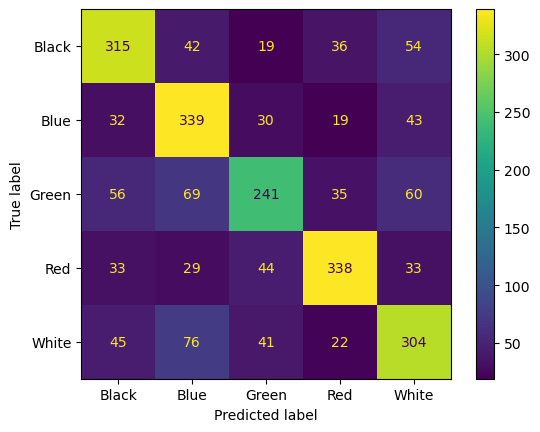

In [426]:
#Create confusion matrix of results
y_pred_RBFSVM350b = RBFSVM350b.predict(test_X_CV350bsw)
cm_RBFSVM350b=confusion_matrix(label_test_CV350bsw, y_pred_RBFSVM350b, labels=RBFSVM350b.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RBFSVM350b,
                              display_labels=RBFSVM350b.classes_)
disp.plot()
plt.show()